In [1]:
data = {
  "data": {
    "tokenDayDatas": [
      {
        "dailyVolumeETH": "0.011",
        "dailyVolumeToken": "0.011",
        "dailyVolumeUSD": "0",
        "date": 1588636800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18387",
        "priceUSD": "0",
        "totalLiquidityETH": "0",
        "totalLiquidityToken": "0.989",
        "totalLiquidityUSD": "0"
      },
      {
        "dailyVolumeETH": "0.001689",
        "dailyVolumeToken": "0.001689",
        "dailyVolumeUSD": "0",
        "date": 1588723200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18388",
        "priceUSD": "0",
        "totalLiquidityETH": "0",
        "totalLiquidityToken": "0.988689",
        "totalLiquidityUSD": "0"
      },
      {
        "dailyVolumeETH": "0",
        "dailyVolumeToken": "0",
        "dailyVolumeUSD": "0",
        "date": 1588809600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18389",
        "priceUSD": "0",
        "totalLiquidityETH": "0",
        "totalLiquidityToken": "0.98869",
        "totalLiquidityUSD": "0"
      },
      {
        "dailyVolumeETH": "0",
        "dailyVolumeToken": "0",
        "dailyVolumeUSD": "0",
        "date": 1588896000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18390",
        "priceUSD": "0",
        "totalLiquidityETH": "0",
        "totalLiquidityToken": "6.574471",
        "totalLiquidityUSD": "0"
      },
      {
        "dailyVolumeETH": "0.397513",
        "dailyVolumeToken": "0.397513",
        "dailyVolumeUSD": "0",
        "date": 1589155200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18393",
        "priceUSD": "0",
        "totalLiquidityETH": "0",
        "totalLiquidityToken": "6.562244",
        "totalLiquidityUSD": "0"
      },
      {
        "dailyVolumeETH": "3.213554",
        "dailyVolumeToken": "3.213554",
        "dailyVolumeUSD": "0",
        "date": 1589241600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18394",
        "priceUSD": "0",
        "totalLiquidityETH": "0",
        "totalLiquidityToken": "6.662242",
        "totalLiquidityUSD": "0"
      },
      {
        "dailyVolumeETH": "17.446875",
        "dailyVolumeToken": "17.446875",
        "dailyVolumeUSD": "0",
        "date": 1589328000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18395",
        "priceUSD": "0",
        "totalLiquidityETH": "0",
        "totalLiquidityToken": "140.225424",
        "totalLiquidityUSD": "0"
      },
      {
        "dailyVolumeETH": "4.548898",
        "dailyVolumeToken": "4.548898",
        "dailyVolumeUSD": "0",
        "date": 1589414400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18396",
        "priceUSD": "0",
        "totalLiquidityETH": "0",
        "totalLiquidityToken": "140.224424",
        "totalLiquidityUSD": "0"
      },
      {
        "dailyVolumeETH": "148.427504",
        "dailyVolumeToken": "148.428504",
        "dailyVolumeUSD": "0",
        "date": 1589500800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18397",
        "priceUSD": "0",
        "totalLiquidityETH": "0",
        "totalLiquidityToken": "165.644323",
        "totalLiquidityUSD": "0"
      },
      {
        "dailyVolumeETH": "86.256842",
        "dailyVolumeToken": "86.256842",
        "dailyVolumeUSD": "0",
        "date": 1589587200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18398",
        "priceUSD": "0",
        "totalLiquidityETH": "0",
        "totalLiquidityToken": "235.760403",
        "totalLiquidityUSD": "0"
      },
      {
        "dailyVolumeETH": "0.153148",
        "dailyVolumeToken": "0.306296",
        "dailyVolumeUSD": "0",
        "date": 1589673600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18399",
        "priceUSD": "0",
        "totalLiquidityETH": "0",
        "totalLiquidityToken": "451.998035",
        "totalLiquidityUSD": "0"
      },
      {
        "dailyVolumeETH": "794.0406935920973412053435984070289",
        "dailyVolumeToken": "2265.626705",
        "dailyVolumeUSD": "2278.377411997280348241919644946389",
        "date": 1589760000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18400",
        "priceUSD": "1.005647415250887982453796440645539",
        "totalLiquidityETH": "420.2191217400078897120777524417468",
        "totalLiquidityToken": "88949.779393",
        "totalLiquidityUSD": "89452.11573370714978662004821074935"
      },
      {
        "dailyVolumeETH": "69873.93737900399943277197343692507",
        "dailyVolumeToken": "95822.087287",
        "dailyVolumeUSD": "96036.05004448136708514133324011504",
        "date": 1589846400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18401",
        "priceUSD": "0.9973303618708316096533911650326783",
        "totalLiquidityETH": "1363.946336020634075131786525808813",
        "totalLiquidityToken": "291580.264156",
        "totalLiquidityUSD": "290801.850365096151094130475501425"
      },
      {
        "dailyVolumeETH": "72689.0926365898345546221375475717",
        "dailyVolumeToken": "79964.827442",
        "dailyVolumeUSD": "79942.75524705223769140368999677015",
        "date": 1589932800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18402",
        "priceUSD": "0.9956562748411454645290729746172225",
        "totalLiquidityETH": "1852.118427784262150889856539528918",
        "totalLiquidityToken": "390877.895573",
        "totalLiquidityUSD": "389180.0294239594440478975617949271"
      },
      {
        "dailyVolumeETH": "236841.1660263707160221382430033167",
        "dailyVolumeToken": "247493.559642",
        "dailyVolumeUSD": "250804.7261940842864327822366657283",
        "date": 1590019200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18403",
        "priceUSD": "0.9995356860771938274325721151194565",
        "totalLiquidityETH": "2425.776274011177040418091281291585",
        "totalLiquidityToken": "483227.253165",
        "totalLiquidityUSD": "483002.8840234761073815348474399491"
      },
      {
        "dailyVolumeETH": "136091.6394256623503138434944943152",
        "dailyVolumeToken": "153544.278593",
        "dailyVolumeUSD": "153064.4475561409403680279872477926",
        "date": 1590105600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18404",
        "priceUSD": "1.00103920374920725742236451902744",
        "totalLiquidityETH": "2753.321330522482787160258813914861",
        "totalLiquidityToken": "570161.165983",
        "totalLiquidityUSD": "570753.6796043419150038609852695341"
      },
      {
        "dailyVolumeETH": "102745.7592961617479129438816669261",
        "dailyVolumeToken": "113959.64537",
        "dailyVolumeUSD": "113765.2696183366855252522530319665",
        "date": 1590192000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18405",
        "priceUSD": "0.9963077551552628665293391087083488",
        "totalLiquidityETH": "3102.14529349561141446655675157998",
        "totalLiquidityToken": "644474.12743",
        "totalLiquidityUSD": "642094.5711554301200787763745793871"
      },
      {
        "dailyVolumeETH": "219657.5034575327680170130337133936",
        "dailyVolumeToken": "239630.128499",
        "dailyVolumeUSD": "228917.6653727265615747299877394679",
        "date": 1590278400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18406",
        "priceUSD": "1.000659825693558309811008176947232",
        "totalLiquidityETH": "3220.244503848219398217904902156474",
        "totalLiquidityToken": "646949.841032",
        "totalLiquidityUSD": "647376.7151595563776786543460396638"
      },
      {
        "dailyVolumeETH": "76736.00888174566402857511248701953",
        "dailyVolumeToken": "91709.73597",
        "dailyVolumeUSD": "91630.55421892895162486537839456594",
        "date": 1590364800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18407",
        "priceUSD": "0.9995402748164742099512668225868449",
        "totalLiquidityETH": "3376.915800953589734530261838678489",
        "totalLiquidityToken": "689014.865989",
        "totalLiquidityUSD": "688698.1085032812093390467599854569"
      },
      {
        "dailyVolumeETH": "97906.87860083445742912040478723942",
        "dailyVolumeToken": "140538.543554",
        "dailyVolumeUSD": "140197.8735157962089036729763968554",
        "date": 1590451200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18408",
        "priceUSD": "0.9977872392836321088853438667769664",
        "totalLiquidityETH": "3671.551323798277416731896235949123",
        "totalLiquidityToken": "736750.392903",
        "totalLiquidityUSD": "735120.1405758156324781835712261913"
      },
      {
        "dailyVolumeETH": "74016.57637774438489790644520201253",
        "dailyVolumeToken": "94274.729996",
        "dailyVolumeUSD": "94096.55442014538758965795274133375",
        "date": 1590537600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18409",
        "priceUSD": "0.9972896911861717803503897141446259",
        "totalLiquidityETH": "3896.278215174285723778432014784284",
        "totalLiquidityToken": "807383.039827",
        "totalLiquidityUSD": "805194.7824580214614063021945902017"
      },
      {
        "dailyVolumeETH": "143660.0753605044233706526382159446",
        "dailyVolumeToken": "207684.091616",
        "dailyVolumeUSD": "207523.2544994027409271828133625107",
        "date": 1590624000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18410",
        "priceUSD": "1.0004915261976057857129528966348",
        "totalLiquidityETH": "3818.891158915099224827474544943099",
        "totalLiquidityToken": "834453.386169",
        "totalLiquidityUSD": "834863.5418689829209087593464409058"
      },
      {
        "dailyVolumeETH": "155267.1529277889347791254015424039",
        "dailyVolumeToken": "204569.060061",
        "dailyVolumeUSD": "204611.9407690434801296991771383158",
        "date": 1590710400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18411",
        "priceUSD": "0.9999618447674613442013872660042974",
        "totalLiquidityETH": "4397.205379752861574993940361774602",
        "totalLiquidityToken": "967373.016736",
        "totalLiquidityUSD": "967336.1063935948169523616602307924"
      },
      {
        "dailyVolumeETH": "151846.1928632915525883327375661202",
        "dailyVolumeToken": "176231.827149",
        "dailyVolumeUSD": "175997.1189011804184033267008906125",
        "date": 1590796800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18412",
        "priceUSD": "1.000154866760520626908763995737591",
        "totalLiquidityETH": "5887.321434653085359797304237321448",
        "totalLiquidityToken": "1433769.07873",
        "totalLiquidityUSD": "1433991.12190255755877814060193168"
      },
      {
        "dailyVolumeETH": "185497.3357493285341405881271624134",
        "dailyVolumeToken": "227451.001376",
        "dailyVolumeUSD": "227498.4800646832494423963435600959",
        "date": 1590883200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18413",
        "priceUSD": "0.9992770495247051129241886033093625",
        "totalLiquidityETH": "6222.366063273394672112687803260601",
        "totalLiquidityToken": "1441281.115921",
        "totalLiquidityUSD": "1440239.141053211367813828869651188"
      },
      {
        "dailyVolumeETH": "147490.7789226207559793730136999688",
        "dailyVolumeToken": "168716.218979",
        "dailyVolumeUSD": "168577.917361968526889825077903997",
        "date": 1590969600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18414",
        "priceUSD": "0.9970880622483370692471771308359601",
        "totalLiquidityETH": "6119.678832397060169707158852032181",
        "totalLiquidityToken": "1524061.560686",
        "totalLiquidityUSD": "1519623.588291580111865040033121741"
      },
      {
        "dailyVolumeETH": "255137.1302576219628574974176517729",
        "dailyVolumeToken": "285987.783744",
        "dailyVolumeUSD": "285163.5663695740564238277014898677",
        "date": 1591056000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18415",
        "priceUSD": "0.9972103945430246638912333026940321",
        "totalLiquidityETH": "6609.496157494219597796150686778537",
        "totalLiquidityToken": "1565182.34452",
        "totalLiquidityUSD": "1560816.103310565557441465526984948"
      },
      {
        "dailyVolumeETH": "123704.0030254477663150992698957977",
        "dailyVolumeToken": "158337.444456",
        "dailyVolumeUSD": "158164.3537849831678087676961531143",
        "date": 1591142400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18416",
        "priceUSD": "0.9997961718234865376273260597925033",
        "totalLiquidityETH": "6186.396291042017342580978168912112",
        "totalLiquidityToken": "1505200.971303",
        "totalLiquidityUSD": "1504894.16893373301710459564223436"
      },
      {
        "dailyVolumeETH": "142346.6875279830133928826062882307",
        "dailyVolumeToken": "166291.257342",
        "dailyVolumeUSD": "166104.5433098327576679975597830354",
        "date": 1591228800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18417",
        "priceUSD": "0.9988562987432819718926788501599496",
        "totalLiquidityETH": "6350.922947551644570453259257355802",
        "totalLiquidityToken": "1543213.807383",
        "totalLiquidityUSD": "1541448.831812111449937644919018614"
      },
      {
        "dailyVolumeETH": "136895.3202289727506333380423716692",
        "dailyVolumeToken": "161156.110827",
        "dailyVolumeUSD": "160622.3676209641799157767307539702",
        "date": 1591315200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18418",
        "priceUSD": "0.9925049934448738421317371710662683",
        "totalLiquidityETH": "6239.457800368728384244462308054942",
        "totalLiquidityToken": "1506673.409638",
        "totalLiquidityUSD": "1495380.882556328911117381781902479"
      },
      {
        "dailyVolumeETH": "188653.9890770302572866989987914499",
        "dailyVolumeToken": "236862.720498",
        "dailyVolumeUSD": "236725.6052676218344104484805763164",
        "date": 1591401600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18419",
        "priceUSD": "0.9960843555962794744941951367069576",
        "totalLiquidityETH": "6007.745047889199068479786733436124",
        "totalLiquidityToken": "1458876.501968",
        "totalLiquidityUSD": "1453164.060357349624585408677160644"
      },
      {
        "dailyVolumeETH": "145343.5458184349594785706870759734",
        "dailyVolumeToken": "197935.061545",
        "dailyVolumeUSD": "197465.2256150266570347931011902633",
        "date": 1591488000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18420",
        "priceUSD": "0.9934924430557160339864276307312086",
        "totalLiquidityETH": "6251.319981369161469971481380335892",
        "totalLiquidityToken": "1533825.301859",
        "totalLiquidityUSD": "1523843.846364569014184618663815354"
      },
      {
        "dailyVolumeETH": "169689.9639840217874136552745969451",
        "dailyVolumeToken": "207754.434299",
        "dailyVolumeUSD": "207858.9331071075591330660070165969",
        "date": 1591574400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18421",
        "priceUSD": "0.998551713595985793467710374154497",
        "totalLiquidityETH": "6310.807779193062338779417532558042",
        "totalLiquidityToken": "1551908.958743",
        "totalLiquidityUSD": "1549661.350097784668925095057946404"
      },
      {
        "dailyVolumeETH": "233228.4129334144210321879333019375",
        "dailyVolumeToken": "274710.246955",
        "dailyVolumeUSD": "274181.6859485513929150469484979178",
        "date": 1591660800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18422",
        "priceUSD": "1.002329412470157379478554600611343",
        "totalLiquidityETH": "6673.903407226317266026629218527686",
        "totalLiquidityToken": "1621544.905412",
        "totalLiquidityUSD": "1625322.152335586881179306609730797"
      },
      {
        "dailyVolumeETH": "311324.3249386474963424287609109873",
        "dailyVolumeToken": "374176.169271",
        "dailyVolumeUSD": "374003.3056199938842002158631817488",
        "date": 1591747200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18423",
        "priceUSD": "0.9989709032425793263347127553951921",
        "totalLiquidityETH": "6246.301060906830328460892131737813",
        "totalLiquidityToken": "1548889.699293",
        "totalLiquidityUSD": "1547295.741925855291400271755571591"
      },
      {
        "dailyVolumeETH": "291272.7515912798283865328786422516",
        "dailyVolumeToken": "378326.068853",
        "dailyVolumeUSD": "378297.8516255622259732612200060723",
        "date": 1591833600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18424",
        "priceUSD": "0.9957314391148497715031369404904366",
        "totalLiquidityETH": "7318.895599088190533799750588312382",
        "totalLiquidityToken": "1689155.330857",
        "totalLiquidityUSD": "1681945.068482760817005232128927502"
      },
      {
        "dailyVolumeETH": "361140.5211077134929836989740559947",
        "dailyVolumeToken": "371808.981556",
        "dailyVolumeUSD": "371763.865747046954146567147027414",
        "date": 1591920000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18425",
        "priceUSD": "0.997455474226298068205722751804515",
        "totalLiquidityETH": "7368.396646923832074620144034718467",
        "totalLiquidityToken": "1752665.375144",
        "totalLiquidityUSD": "1748205.672924271126862145565759116"
      },
      {
        "dailyVolumeETH": "202234.3618193134910599892632420913",
        "dailyVolumeToken": "284967.206795",
        "dailyVolumeUSD": "284150.0939347324169584692744440193",
        "date": 1592006400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18426",
        "priceUSD": "0.9979333553653635802164175141373773",
        "totalLiquidityETH": "7613.573186419804827007070493339435",
        "totalLiquidityToken": "1816150.843918",
        "totalLiquidityUSD": "1812397.505520726459436948557379234"
      },
      {
        "dailyVolumeETH": "189421.4752903865493807654983194334",
        "dailyVolumeToken": "220639.708971",
        "dailyVolumeUSD": "219784.086512280453083010220820134",
        "date": 1592092800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18427",
        "priceUSD": "0.9914595929276185705287212578571779",
        "totalLiquidityETH": "8187.140350937116556948034497088674",
        "totalLiquidityToken": "1897163.463042",
        "totalLiquidityUSD": "1880960.914784772458510338542480246"
      },
      {
        "dailyVolumeETH": "529926.7675063632383459448724333882",
        "dailyVolumeToken": "695413.717815",
        "dailyVolumeUSD": "689432.2210515454507556117765010329",
        "date": 1592179200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18428",
        "priceUSD": "0.9899216651247826525087320573036132",
        "totalLiquidityETH": "7905.983885337355798471835468462859",
        "totalLiquidityToken": "1832986.541206",
        "totalLiquidityUSD": "1814513.089021959550614490972429562"
      },
      {
        "dailyVolumeETH": "436887.7781968714981322418327486972",
        "dailyVolumeToken": "690853.847559",
        "dailyVolumeUSD": "689184.166213935226255663314346741",
        "date": 1592265600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18429",
        "priceUSD": "0.9922088068246114062693718836357981",
        "totalLiquidityETH": "8192.840077671076048118110031559349",
        "totalLiquidityToken": "1932991.004862",
        "totalLiquidityUSD": "1917930.698536831645597300084002731"
      },
      {
        "dailyVolumeETH": "435869.169010519242170305240990249",
        "dailyVolumeToken": "681545.288575",
        "dailyVolumeUSD": "679038.3138750213737615774549543156",
        "date": 1592352000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18430",
        "priceUSD": "0.9918718718271880768892291153442183",
        "totalLiquidityETH": "7928.74043415640918039536410263336",
        "totalLiquidityToken": "1845146.861434",
        "totalLiquidityUSD": "1830149.271246602806901787372257117"
      },
      {
        "dailyVolumeETH": "864857.8315770767904199976723806472",
        "dailyVolumeToken": "1387609.282854",
        "dailyVolumeUSD": "1377348.384711757082556472199530253",
        "date": 1592438400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18431",
        "priceUSD": "0.99146300633663488268359809292674",
        "totalLiquidityETH": "9112.919869682603710297845016544182",
        "totalLiquidityToken": "2116480.300231",
        "totalLiquidityUSD": "2098411.921319290851956409154696926"
      },
      {
        "dailyVolumeETH": "1324291.191296611755345435608222619",
        "dailyVolumeToken": "1581355.944322",
        "dailyVolumeUSD": "1575621.828882352647935473051330289",
        "date": 1592524800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18432",
        "priceUSD": "0.9963419610305457173836265498947498",
        "totalLiquidityETH": "8136.626989590292004208273179282102",
        "totalLiquidityToken": "1854296.219841",
        "totalLiquidityUSD": "1847513.132007909856477790232297479"
      },
      {
        "dailyVolumeETH": "1309963.220680911216794952320135695",
        "dailyVolumeToken": "1296517.284096",
        "dailyVolumeUSD": "1289769.866648881281347382242748243",
        "date": 1592611200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18433",
        "priceUSD": "0.9946487341951003353070110942377486",
        "totalLiquidityETH": "13786.0239459303702907385470615173",
        "totalLiquidityToken": "3148049.576231",
        "totalLiquidityUSD": "3131203.526181586169439762282498359"
      },
      {
        "dailyVolumeETH": "1602813.149481735420172870761493524",
        "dailyVolumeToken": "2207916.123487",
        "dailyVolumeUSD": "2202842.88554791312300429388549534",
        "date": 1592697600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18434",
        "priceUSD": "0.9954776062678153079297091243776061",
        "totalLiquidityETH": "10115.55602267241224269446986600664",
        "totalLiquidityToken": "2310413.949263",
        "totalLiquidityUSD": "2299965.347700100927644965698460112"
      },
      {
        "dailyVolumeETH": "2211576.493634474504095186153053157",
        "dailyVolumeToken": "2859975.925487",
        "dailyVolumeUSD": "2856536.352003128715830817868994573",
        "date": 1592784000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18435",
        "priceUSD": "0.999657344456133787400789559768117",
        "totalLiquidityETH": "12581.76217304736078927695014695992",
        "totalLiquidityToken": "3045800.260309",
        "totalLiquidityUSD": "3044756.599964295967697054905653859"
      },
      {
        "dailyVolumeETH": "2096867.702348916663385348231370867",
        "dailyVolumeToken": "2576060.275553",
        "dailyVolumeUSD": "2494405.724495354201099299674351031",
        "date": 1592870400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18436",
        "priceUSD": "0.994715718215488099353892446191487",
        "totalLiquidityETH": "12334.74138662310443056533447767997",
        "totalLiquidityToken": "2998886.628661",
        "totalLiquidityUSD": "2983039.666675350373385961130306784"
      },
      {
        "dailyVolumeETH": "2075279.432848322255845371333951846",
        "dailyVolumeToken": "2714478.056562",
        "dailyVolumeUSD": "2706817.475758937884167678308352795",
        "date": 1592956800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18437",
        "priceUSD": "1.00315375661494306783532773974961",
        "totalLiquidityETH": "13347.12335857269532281917474159948",
        "totalLiquidityToken": "3102186.739411",
        "totalLiquidityUSD": "3111970.281361206108247472750850403"
      },
      {
        "dailyVolumeETH": "1895290.242036184390533348813258745",
        "dailyVolumeToken": "2859755.39115",
        "dailyVolumeUSD": "2854000.107266358997116151641585189",
        "date": 1593043200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18438",
        "priceUSD": "0.9966422173201245653336068996006536",
        "totalLiquidityETH": "13794.19991483069573779868711862602",
        "totalLiquidityToken": "3215055.856275",
        "totalLiquidityUSD": "3204260.397405967720188301711629828"
      },
      {
        "dailyVolumeETH": "1924834.483247882842860043839618114",
        "dailyVolumeToken": "2805943.164746",
        "dailyVolumeUSD": "2799564.122314201964945355867869978",
        "date": 1593129600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18439",
        "priceUSD": "0.9977121240739601016363728953980125",
        "totalLiquidityETH": "13792.72763233479070135702881239031",
        "totalLiquidityToken": "3171408.39067",
        "totalLiquidityUSD": "3164152.601761345169984398997730219"
      },
      {
        "dailyVolumeETH": "1771480.419719094691326982245586466",
        "dailyVolumeToken": "2200901.122301",
        "dailyVolumeUSD": "2198912.681897635449548652160922938",
        "date": 1593216000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18440",
        "priceUSD": "0.9976574754668175506518483428734916",
        "totalLiquidityETH": "14454.15477268658739694215425077498",
        "totalLiquidityToken": "3188185.682248",
        "totalLiquidityUSD": "3180717.279070993035010303406146351"
      },
      {
        "dailyVolumeETH": "1195708.531853056604462184213113324",
        "dailyVolumeToken": "1434557.208125",
        "dailyVolumeUSD": "1431321.364101885819290012616250386",
        "date": 1593302400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18441",
        "priceUSD": "0.99621552776991759466888784091029",
        "totalLiquidityETH": "14783.18715598162806302653150563366",
        "totalLiquidityToken": "3329457.709465",
        "totalLiquidityUSD": "3316857.469222295934278077605896165"
      },
      {
        "dailyVolumeETH": "1334396.015531849220610162834260084",
        "dailyVolumeToken": "1939877.632245",
        "dailyVolumeUSD": "1938080.279747967092869256873849154",
        "date": 1593388800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18442",
        "priceUSD": "0.9983579907984838434862474354507645",
        "totalLiquidityETH": "16576.94863319628496684706246728273",
        "totalLiquidityToken": "3763830.835801",
        "totalLiquidityUSD": "3757650.590935664511992437554621744"
      },
      {
        "dailyVolumeETH": "1424766.996072687744040695336996475",
        "dailyVolumeToken": "1886435.859069",
        "dailyVolumeUSD": "1881333.815396807803925131449122967",
        "date": 1593475200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18443",
        "priceUSD": "0.9951713018909352912051933985541564",
        "totalLiquidityETH": "15261.47282681687834429600609499346",
        "totalLiquidityToken": "3443102.682933",
        "totalLiquidityUSD": "3426476.979518605797301295029584957"
      },
      {
        "dailyVolumeETH": "1430372.973133494327031358087066347",
        "dailyVolumeToken": "2029527.863481",
        "dailyVolumeUSD": "2011891.978391820896998552083418113",
        "date": 1593561600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18444",
        "priceUSD": "0.9913826330474726565108530403873202",
        "totalLiquidityETH": "15844.30734355526736907269917777399",
        "totalLiquidityToken": "3656199.296115",
        "totalLiquidityUSD": "3624692.485128804864114690058122328"
      },
      {
        "dailyVolumeETH": "1930491.404105639588728197391527507",
        "dailyVolumeToken": "2605868.600055",
        "dailyVolumeUSD": "2585206.082920251397875740352413562",
        "date": 1593648000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18445",
        "priceUSD": "0.9886810178329708844680487971115764",
        "totalLiquidityETH": "15964.27777576264331567083904598867",
        "totalLiquidityToken": "3621032.930291",
        "totalLiquidityUSD": "3580046.52312681098857942475456811"
      },
      {
        "dailyVolumeETH": "1763716.317267333615890438604002198",
        "dailyVolumeToken": "2258337.465996",
        "dailyVolumeUSD": "2235448.283950784656349180118417956",
        "date": 1593734400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18446",
        "priceUSD": "0.9865971740745622047365703728336018",
        "totalLiquidityETH": "15899.76381541908695466815825765899",
        "totalLiquidityToken": "3595528.373236",
        "totalLiquidityUSD": "3547338.132339545357765370446552235"
      },
      {
        "dailyVolumeETH": "1200095.502666705732755946593808767",
        "dailyVolumeToken": "1728993.177197",
        "dailyVolumeUSD": "1712658.909246698130862036988344388",
        "date": 1593820800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18447",
        "priceUSD": "0.9919079679863309735063638982385191",
        "totalLiquidityETH": "16520.14222847449706747261557566884",
        "totalLiquidityToken": "3780279.215931",
        "totalLiquidityUSD": "3749689.075495078701452097251071874"
      },
      {
        "dailyVolumeETH": "1100904.562135781313152575055057951",
        "dailyVolumeToken": "1388643.713157",
        "dailyVolumeUSD": "1380105.587888975839447641552494315",
        "date": 1593907200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18448",
        "priceUSD": "0.9931560528834517712557185604461518",
        "totalLiquidityETH": "16658.29464070764688469380065165272",
        "totalLiquidityToken": "3780716.198",
        "totalLiquidityUSD": "3754841.176278210717738285961608008"
      },
      {
        "dailyVolumeETH": "1572818.756187939398970924602968917",
        "dailyVolumeToken": "2090748.431566",
        "dailyVolumeUSD": "2076655.369352795938447711115986037",
        "date": 1593993600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18449",
        "priceUSD": "0.9931682342624410728190398713864571",
        "totalLiquidityETH": "17002.66711304529957027481109328092",
        "totalLiquidityToken": "4105191.6859",
        "totalLiquidityUSD": "4077145.977994156610775398955236288"
      },
      {
        "dailyVolumeETH": "1329624.094033403089689072045756756",
        "dailyVolumeToken": "1772393.120231",
        "dailyVolumeUSD": "1759572.26937746972861966780190423",
        "date": 1594080000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18450",
        "priceUSD": "0.9945594902253730465440106543531446",
        "totalLiquidityETH": "18628.74168933079557079402432673361",
        "totalLiquidityToken": "4439907.130498",
        "totalLiquidityUSD": "4415751.77235608972239281054023741"
      },
      {
        "dailyVolumeETH": "1475982.972943427620602387919908835",
        "dailyVolumeToken": "1985300.998181",
        "dailyVolumeUSD": "1971171.429482889984870134693707023",
        "date": 1594166400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18451",
        "priceUSD": "0.9893662054816784431775047502587746",
        "totalLiquidityETH": "19541.24144806354481794641468316377",
        "totalLiquidityToken": "4844947.976051",
        "totalLiquidityUSD": "4793427.794821715754835248249098689"
      },
      {
        "dailyVolumeETH": "1727008.367587487653775479644733944",
        "dailyVolumeToken": "2110708.083767",
        "dailyVolumeUSD": "2095137.138612496064283183020994205",
        "date": 1594252800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18452",
        "priceUSD": "0.993675269216872531825143456727855",
        "totalLiquidityETH": "20609.06531600038743053576125168355",
        "totalLiquidityToken": "4993722.51718",
        "totalLiquidityUSD": "4962138.56665319486695305504234563"
      },
      {
        "dailyVolumeETH": "1290903.569882031727623858847531416",
        "dailyVolumeToken": "1941811.442263",
        "dailyVolumeUSD": "1924458.375792731994816741035535807",
        "date": 1594339200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18453",
        "priceUSD": "0.9900566489986626501760167678029558",
        "totalLiquidityETH": "22738.89484405061964053413761557071",
        "totalLiquidityToken": "5504999.859522",
        "totalLiquidityUSD": "5450261.713656459951184840535328787"
      },
      {
        "dailyVolumeETH": "1262251.18465382885084600985458285",
        "dailyVolumeToken": "1732425.779714",
        "dailyVolumeUSD": "1718344.758939630368727482078904614",
        "date": 1594425600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18454",
        "priceUSD": "0.9905465569483006135472322726269664",
        "totalLiquidityETH": "22682.00083893603456879988155850705",
        "totalLiquidityToken": "5436365.566616",
        "totalLiquidityUSD": "5384973.19432377617678499981945826"
      },
      {
        "dailyVolumeETH": "1976442.604969151852560704878519215",
        "dailyVolumeToken": "2744352.217229",
        "dailyVolumeUSD": "2725319.456462926940141123492410205",
        "date": 1594512000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18455",
        "priceUSD": "0.9927931438699964182046670910841185",
        "totalLiquidityETH": "22793.01227156592024725353105923483",
        "totalLiquidityToken": "5508443.050716",
        "totalLiquidityUSD": "5468744.494149171764395309350880572"
      },
      {
        "dailyVolumeETH": "3825735.068569621088504848939475754",
        "dailyVolumeToken": "5875270.061384",
        "dailyVolumeUSD": "5821879.666422032882436146287588979",
        "date": 1594598400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18456",
        "priceUSD": "0.9926997510964015467195837595400705",
        "totalLiquidityETH": "23384.8060820370235765834733318622",
        "totalLiquidityToken": "5591333.730023",
        "totalLiquidityUSD": "5550515.602090746544072596761851155"
      },
      {
        "dailyVolumeETH": "1850095.167842061479906540742356055",
        "dailyVolumeToken": "2431689.262815",
        "dailyVolumeUSD": "2416701.350908807607688306238902045",
        "date": 1594684800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18457",
        "priceUSD": "0.9938394564308062739683399159705005",
        "totalLiquidityETH": "23943.99196214771640706470700346229",
        "totalLiquidityToken": "5763623.836667",
        "totalLiquidityUSD": "5728116.780904769442781618033774698"
      },
      {
        "dailyVolumeETH": "2588013.111983039468914571900570235",
        "dailyVolumeToken": "3737278.934256",
        "dailyVolumeUSD": "3722803.170455448396289147865056756",
        "date": 1594771200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18458",
        "priceUSD": "0.9961008062061552114365370583349799",
        "totalLiquidityETH": "28472.03106176220375409544378923785",
        "totalLiquidityToken": "6775846.974796",
        "totalLiquidityUSD": "6749426.634323833451326689368061418"
      },
      {
        "dailyVolumeETH": "2510356.452510907525154033459549677",
        "dailyVolumeToken": "3313912.504404",
        "dailyVolumeUSD": "3298228.829314190532577654022849028",
        "date": 1594857600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18459",
        "priceUSD": "0.9930533782876043605795863519843233",
        "totalLiquidityETH": "30664.34223188278871281606660377967",
        "totalLiquidityToken": "7185919.732929",
        "totalLiquidityUSD": "7136001.866888703134127276974100482"
      },
      {
        "dailyVolumeETH": "2672863.083517131445798113294822581",
        "dailyVolumeToken": "3763945.379349",
        "dailyVolumeUSD": "3748467.287056642430809842903860983",
        "date": 1594944000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18460",
        "priceUSD": "0.9957002825024340305346136530883249",
        "totalLiquidityETH": "32029.054644585370773251591324056",
        "totalLiquidityToken": "7456997.270508",
        "totalLiquidityUSD": "7424934.288864695077562947139095951"
      },
      {
        "dailyVolumeETH": "4908127.298807887395353329824156208",
        "dailyVolumeToken": "6300933.206828",
        "dailyVolumeUSD": "6275718.297328886202697499574475283",
        "date": 1595030400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18461",
        "priceUSD": "0.9964213212769544185908872694024519",
        "totalLiquidityETH": "31582.61008659189730362450509227763",
        "totalLiquidityToken": "7425934.229271",
        "totalLiquidityUSD": "7399359.196445971983952918368774144"
      },
      {
        "dailyVolumeETH": "4338406.063470634236208722841491458",
        "dailyVolumeToken": "6115164.292261",
        "dailyVolumeUSD": "6082750.323518980660919277468129924",
        "date": 1595116800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18462",
        "priceUSD": "0.9964959106813885985171718576664379",
        "totalLiquidityETH": "31826.95676480596462671723447665017",
        "totalLiquidityToken": "7632449.623863",
        "totalLiquidityUSD": "7605704.838661182052786925064592733"
      },
      {
        "dailyVolumeETH": "5377749.013147437459120170786591261",
        "dailyVolumeToken": "7101279.108353",
        "dailyVolumeUSD": "7082478.950445287734315330838314523",
        "date": 1595203200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18463",
        "priceUSD": "0.9970278722044182075453719828167315",
        "totalLiquidityETH": "31982.78611817500441189281289710479",
        "totalLiquidityToken": "7518148.258355",
        "totalLiquidityUSD": "7495803.360945038261593289292254224"
      },
      {
        "dailyVolumeETH": "4412918.988205937899646744045384352",
        "dailyVolumeToken": "6357111.095779",
        "dailyVolumeUSD": "6345429.882259538546575349395796645",
        "date": 1595289600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18464",
        "priceUSD": "0.9979603745884355127322763380098619",
        "totalLiquidityETH": "31210.03767833234086571567065616183",
        "totalLiquidityToken": "7623106.473966",
        "totalLiquidityUSD": "7607558.192286637189904918373607092"
      },
      {
        "dailyVolumeETH": "4464588.639207011126810334934737667",
        "dailyVolumeToken": "6083838.617114",
        "dailyVolumeUSD": "6051849.054787277234171406592782584",
        "date": 1595376000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18465",
        "priceUSD": "0.9941210560255574983257964528227832",
        "totalLiquidityETH": "28898.14010698917447282898645126485",
        "totalLiquidityToken": "7612084.85441",
        "totalLiquidityUSD": "7567333.834022221302882404110332809"
      },
      {
        "dailyVolumeETH": "7227058.671349736330994459808971671",
        "dailyVolumeToken": "8923935.619918",
        "dailyVolumeUSD": "8873704.554469118221624258665969505",
        "date": 1595462400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18466",
        "priceUSD": "0.9915828862031080990417389483761957",
        "totalLiquidityETH": "27805.94333448493921054092597774799",
        "totalLiquidityToken": "7676604.95067",
        "totalLiquidityUSD": "7611990.093226426872244985894070463"
      },
      {
        "dailyVolumeETH": "6957530.663926216084994136985296724",
        "dailyVolumeToken": "8567438.804058",
        "dailyVolumeUSD": "8488429.794757256430359051251993235",
        "date": 1595548800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18467",
        "priceUSD": "0.9871742610758667530565314800468469",
        "totalLiquidityETH": "25438.6879484459535758429501368143",
        "totalLiquidityToken": "7113301.700094",
        "totalLiquidityUSD": "7022068.349600001184031637047908066"
      },
      {
        "dailyVolumeETH": "8082683.412077563894154126175681164",
        "dailyVolumeToken": "10097564.638708",
        "dailyVolumeUSD": "10076420.83293099855513112334341398",
        "date": 1595635200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18468",
        "priceUSD": "0.9973297688399909679989892739685657",
        "totalLiquidityETH": "25817.90103334308221153020614288686",
        "totalLiquidityToken": "7878579.176864",
        "totalLiquidityUSD": "7857541.549249339436782671479287228"
      },
      {
        "dailyVolumeETH": "9087497.800676896878498847698367897",
        "dailyVolumeToken": "11230697.920506",
        "dailyVolumeUSD": "11204152.92871354632813452077979127",
        "date": 1595721600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18469",
        "priceUSD": "0.9961529073678882592140940026239749",
        "totalLiquidityETH": "27303.70095689132080236339426189704",
        "totalLiquidityToken": "8504706.581926",
        "totalLiquidityUSD": "8471988.187896400258433403680101002"
      },
      {
        "dailyVolumeETH": "11939678.18074629059277086826032183",
        "dailyVolumeToken": "14998079.665255",
        "dailyVolumeUSD": "14950328.99363545378975472858718818",
        "date": 1595808000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18470",
        "priceUSD": "0.9937449276519071778917032270925633",
        "totalLiquidityETH": "29267.640970168343075023776018476",
        "totalLiquidityToken": "9398967.417414",
        "totalLiquidityUSD": "9340176.196220708282960430957723918"
      },
      {
        "dailyVolumeETH": "9147101.975816050578679283465686303",
        "dailyVolumeToken": "11062594.897466",
        "dailyVolumeUSD": "10974112.43492872021125307717030965",
        "date": 1595894400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18471",
        "priceUSD": "0.9879551300617702693225291212185261",
        "totalLiquidityETH": "32344.19980184305839193352819403101",
        "totalLiquidityToken": "10312545.535359",
        "totalLiquidityUSD": "10188332.26565352915678997069061637"
      },
      {
        "dailyVolumeETH": "8685221.351630068341817641205854297",
        "dailyVolumeToken": "11640029.350626",
        "dailyVolumeUSD": "11498546.22459732936043377985647214",
        "date": 1595980800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18472",
        "priceUSD": "0.9895245247743804592615875770457845",
        "totalLiquidityETH": "33865.03509733625232496705311086751",
        "totalLiquidityToken": "10754400.225031",
        "totalLiquidityUSD": "10641742.7719072905455864265666755"
      },
      {
        "dailyVolumeETH": "10108522.45720705933217256126223888",
        "dailyVolumeToken": "12586754.895598",
        "dailyVolumeUSD": "12414484.15027185493785263068309828",
        "date": 1596067200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18473",
        "priceUSD": "0.9825031404936378635918115316917655",
        "totalLiquidityETH": "32013.70749493593127094679762536483",
        "totalLiquidityToken": "10804713.414534",
        "totalLiquidityUSD": "10615664.86191339228343235089618793"
      },
      {
        "dailyVolumeETH": "8909635.343533677025831099558044464",
        "dailyVolumeToken": "10722649.158979",
        "dailyVolumeUSD": "10621817.3680167912433320071701096",
        "date": 1596153600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18474",
        "priceUSD": "0.9898948724340979378604312961559052",
        "totalLiquidityETH": "33006.40569989092342173460592048947",
        "totalLiquidityToken": "11467704.928281",
        "totalLiquidityUSD": "11351822.30709259673639068727167128"
      },
      {
        "dailyVolumeETH": "9763915.387235795051823998097530521",
        "dailyVolumeToken": "11549206.757928",
        "dailyVolumeUSD": "11472566.14984971542864319869661319",
        "date": 1596240000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18475",
        "priceUSD": "0.9914099160070896709600393874377242",
        "totalLiquidityETH": "30947.74257287367548616260534272823",
        "totalLiquidityToken": "11971792.953467",
        "totalLiquidityUSD": "11868954.24645098645161379915946772"
      },
      {
        "dailyVolumeETH": "13822647.33683777685137817271235411",
        "dailyVolumeToken": "17131849.91044",
        "dailyVolumeUSD": "17039234.84329181357367373293596941",
        "date": 1596326400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18476",
        "priceUSD": "0.9929434763309493462052723154769003",
        "totalLiquidityETH": "31051.31346616960085746878906037765",
        "totalLiquidityToken": "11513769.818406",
        "totalLiquidityUSD": "11432522.62916241701301546265296825"
      },
      {
        "dailyVolumeETH": "9618315.702505656163650281026005465",
        "dailyVolumeToken": "11974715.402925",
        "dailyVolumeUSD": "11913280.41682756055281692017470887",
        "date": 1596412800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18477",
        "priceUSD": "0.9952530325323540294786037625086233",
        "totalLiquidityETH": "31949.06334432891623922691998949918",
        "totalLiquidityToken": "12343441.886929",
        "totalLiquidityUSD": "12284847.96985296944486963331633176"
      },
      {
        "dailyVolumeETH": "7241487.806931736626762982395582168",
        "dailyVolumeToken": "9192529.547679",
        "dailyVolumeUSD": "9138595.566181657132544513711027082",
        "date": 1596499200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18478",
        "priceUSD": "0.9949816611928767097719024330894108",
        "totalLiquidityETH": "34151.47677598393886166079108284528",
        "totalLiquidityToken": "13324107.266233",
        "totalLiquidityUSD": "13257242.38166858952317191868474655"
      },
      {
        "dailyVolumeETH": "6388385.776996061078155976108234234",
        "dailyVolumeToken": "7620908.82387",
        "dailyVolumeUSD": "7571149.699143188628703451446599369",
        "date": 1596585600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18479",
        "priceUSD": "0.9926931251267274406270908504226298",
        "totalLiquidityETH": "31681.28161941748457267694637871687",
        "totalLiquidityToken": "12713905.794107",
        "totalLiquidityUSD": "12621006.87531888515603612119269976"
      },
      {
        "dailyVolumeETH": "6914189.4903355747358025433022959",
        "dailyVolumeToken": "8096960.85229",
        "dailyVolumeUSD": "8054992.151746329409532115614029823",
        "date": 1596672000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18480",
        "priceUSD": "0.9964848856286643184478902810014801",
        "totalLiquidityETH": "33629.7830964187796871505540514058",
        "totalLiquidityToken": "13250905.038911",
        "totalLiquidityUSD": "13204326.59217551954533969885909978"
      },
      {
        "dailyVolumeETH": "9700037.964394789351782879160283522",
        "dailyVolumeToken": "12649912.332079",
        "dailyVolumeUSD": "12587863.58672518532968051809427464",
        "date": 1596758400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18481",
        "priceUSD": "0.9938544385171893103675588995967733",
        "totalLiquidityETH": "34760.78457868268998283803881416108",
        "totalLiquidityToken": "13181316.025862",
        "totalLiquidityUSD": "13100309.43780070722070841994892315"
      },
      {
        "dailyVolumeETH": "8576133.501308735414920904599191172",
        "dailyVolumeToken": "10242265.023642",
        "dailyVolumeUSD": "10187823.02325219651336526898993398",
        "date": 1596844800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18482",
        "priceUSD": "0.9963728809983408828787838419819367",
        "totalLiquidityETH": "34118.63370992915387831519898665912",
        "totalLiquidityToken": "13441637.320839",
        "totalLiquidityUSD": "13392882.90269917451654281792733268"
      },
      {
        "dailyVolumeETH": "9351845.218028419515504228580327366",
        "dailyVolumeToken": "10833311.101492",
        "dailyVolumeUSD": "10797773.21458860161515764818128145",
        "date": 1596931200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18483",
        "priceUSD": "0.9979428161993796451595707506098894",
        "totalLiquidityETH": "34532.23149553444973181237028163815",
        "totalLiquidityToken": "13466504.10166",
        "totalLiquidityUSD": "13438801.02757107748388887487829304"
      },
      {
        "dailyVolumeETH": "26386057.25838105040200727402242672",
        "dailyVolumeToken": "33122431.682936",
        "dailyVolumeUSD": "33265776.55418856375335136024130686",
        "date": 1597017600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18484",
        "priceUSD": "0.9966293066121561300251047492413459",
        "totalLiquidityETH": "38183.31182169029127997900969677532",
        "totalLiquidityToken": "15091714.324121",
        "totalLiquidityUSD": "15040844.78243745672612435071545909"
      },
      {
        "dailyVolumeETH": "15154801.06735978810824225188588276",
        "dailyVolumeToken": "17079554.839216",
        "dailyVolumeUSD": "17036017.82990869309898099154685298",
        "date": 1597104000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18485",
        "priceUSD": "0.9973606644374292797449760641524935",
        "totalLiquidityETH": "41293.85638714044944551468551591394",
        "totalLiquidityToken": "15670676.20088",
        "totalLiquidityUSD": "15629316.02789348678798767624425973"
      },
      {
        "dailyVolumeETH": "23668286.70952034681815846468012159",
        "dailyVolumeToken": "26817355.117257",
        "dailyVolumeUSD": "26704472.38644995049495651407334844",
        "date": 1597190400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18486",
        "priceUSD": "0.993409561212880625566100573043351",
        "totalLiquidityETH": "39612.94374715851966668174125972651",
        "totalLiquidityToken": "15350908.661215",
        "totalLiquidityUSD": "15249739.43735660191542252064922495"
      },
      {
        "dailyVolumeETH": "27064675.08673000373811760843638531",
        "dailyVolumeToken": "31222941.65161",
        "dailyVolumeUSD": "31079868.64769708264662608736135325",
        "date": 1597276800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18487",
        "priceUSD": "0.9963825567420623583136250901879653",
        "totalLiquidityETH": "59396.80735816216977439994243653631",
        "totalLiquidityToken": "25256093.603606",
        "totalLiquidityUSD": "25164731.11807779347821753029717462"
      },
      {
        "dailyVolumeETH": "22635657.46990853309761629210470099",
        "dailyVolumeToken": "26898240.193695",
        "dailyVolumeUSD": "26853245.80261770049988816717959708",
        "date": 1597363200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18488",
        "priceUSD": "0.9973386046641774564246629712981295",
        "totalLiquidityETH": "34030.97752334737880756228921588591",
        "totalLiquidityToken": "14859585.232399",
        "totalLiquidityUSD": "14820038.00156923575417625221399237"
      },
      {
        "dailyVolumeETH": "13167009.55966763803931141470439587",
        "dailyVolumeToken": "15458732.974688",
        "dailyVolumeUSD": "15434221.25887120774878073212007873",
        "date": 1597449600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18489",
        "priceUSD": "0.9966210079186056103190836187914713",
        "totalLiquidityETH": "34610.15595440615324115741941032592",
        "totalLiquidityToken": "14953743.29089",
        "totalLiquidityUSD": "14903214.71072287820851291041663587"
      },
      {
        "dailyVolumeETH": "11819782.34446712763145271922271682",
        "dailyVolumeToken": "13743822.881778",
        "dailyVolumeUSD": "13723517.10113111388284587743534536",
        "date": 1597536000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18490",
        "priceUSD": "0.99669988567146789476885308631846",
        "totalLiquidityETH": "34047.57267072239614544385523513806",
        "totalLiquidityToken": "14758488.482601",
        "totalLiquidityUSD": "14709783.78329209239226745853153722"
      },
      {
        "dailyVolumeETH": "17360883.93345815571942332852094673",
        "dailyVolumeToken": "19982212.024704",
        "dailyVolumeUSD": "19969958.24081715742984285540069487",
        "date": 1597622400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18491",
        "priceUSD": "0.9998772617707728576304443418548462",
        "totalLiquidityETH": "34422.91639657188727877734056661717",
        "totalLiquidityToken": "14794862.607991",
        "totalLiquidityUSD": "14793046.71275283632326203152001476"
      },
      {
        "dailyVolumeETH": "17603383.30441944136558748824400202",
        "dailyVolumeToken": "21756363.075969",
        "dailyVolumeUSD": "21741137.00669598010293699697781628",
        "date": 1597708800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18492",
        "priceUSD": "0.9969369796782545694542986809800009",
        "totalLiquidityETH": "37309.68752706797249150184930928443",
        "totalLiquidityToken": "15782973.22989",
        "totalLiquidityUSD": "15734629.66214928281505776378769169"
      },
      {
        "dailyVolumeETH": "19891260.78254706283270630935918134",
        "dailyVolumeToken": "22882561.312831",
        "dailyVolumeUSD": "22858549.06752262205131153683265182",
        "date": 1597795200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18493",
        "priceUSD": "0.9971135912914946496722506389137359",
        "totalLiquidityETH": "36745.61544566209933059061687324554",
        "totalLiquidityToken": "14921406.186427",
        "totalLiquidityUSD": "14878336.90966735149828689177143992"
      },
      {
        "dailyVolumeETH": "17114120.23852170229260283410228002",
        "dailyVolumeToken": "19570320.765276",
        "dailyVolumeUSD": "19571338.08060197435095499834148171",
        "date": 1597881600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18494",
        "priceUSD": "0.9968882341753138976016727088022065",
        "totalLiquidityETH": "37550.85017177737862458208394754051",
        "totalLiquidityToken": "15640099.720679",
        "totalLiquidityUSD": "15591431.39287350843179706814094057"
      },
      {
        "dailyVolumeETH": "18335503.67888811554293474964957477",
        "dailyVolumeToken": "21151047.985188",
        "dailyVolumeUSD": "21132496.50046301418103472624899676",
        "date": 1597968000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18495",
        "priceUSD": "0.9979047351017964135745375419734257",
        "totalLiquidityETH": "41297.52478286607626342456524411918",
        "totalLiquidityToken": "15907845.955744",
        "totalLiquidityUSD": "15874514.80450689971383095065977706"
      },
      {
        "dailyVolumeETH": "12783292.83993784848087291805160431",
        "dailyVolumeToken": "14901172.510731",
        "dailyVolumeUSD": "14878766.98101348677367259963894309",
        "date": 1598054400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18496",
        "priceUSD": "1.002827783394635507297247436367602",
        "totalLiquidityETH": "45281.85894112990192211785183456963",
        "totalLiquidityToken": "17809886.415278",
        "totalLiquidityUSD": "17860248.91634346762907358915488558"
      },
      {
        "dailyVolumeETH": "9002795.015122570085440156023919616",
        "dailyVolumeToken": "11085620.44424",
        "dailyVolumeUSD": "11071189.53264728946084073373667463",
        "date": 1598140800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18497",
        "priceUSD": "0.9960128265738755827187622707882151",
        "totalLiquidityETH": "45391.43452877522029859320821810269",
        "totalLiquidityToken": "17797307.069781",
        "totalLiquidityUSD": "17726346.11997579297660131883093295"
      },
      {
        "dailyVolumeETH": "10942775.72018785101524754949570798",
        "dailyVolumeToken": "13390718.549073",
        "dailyVolumeUSD": "13361634.90845116239889718274438492",
        "date": 1598227200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18498",
        "priceUSD": "0.9945910177944286666945311956677437",
        "totalLiquidityETH": "43426.57098998369390836959191876821",
        "totalLiquidityToken": "17783077.04532",
        "totalLiquidityUSD": "17686888.6980215600772796909060577"
      },
      {
        "dailyVolumeETH": "14205136.29635726018316309609672696",
        "dailyVolumeToken": "16651024.705352",
        "dailyVolumeUSD": "16627327.6188786349823448225305848",
        "date": 1598313600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18499",
        "priceUSD": "0.9945810752409181888687127299903747",
        "totalLiquidityETH": "45136.95929899539401664441326750597",
        "totalLiquidityToken": "17332435.507842",
        "totalLiquidityUSD": "17238512.34393336626138306179769553"
      },
      {
        "dailyVolumeETH": "11281899.75975478337268656345488495",
        "dailyVolumeToken": "13528152.875022",
        "dailyVolumeUSD": "13490894.59698012322905508294269846",
        "date": 1598400000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18500",
        "priceUSD": "0.9968564408560417658587440532334761",
        "totalLiquidityETH": "49287.97190428027907833008554916195",
        "totalLiquidityToken": "19008838.250058",
        "totalLiquidityUSD": "18949082.84276100713602288847848434"
      },
      {
        "dailyVolumeETH": "12045483.46024779437499566765726747",
        "dailyVolumeToken": "14135046.819372",
        "dailyVolumeUSD": "14097324.14670426068794261138055258",
        "date": 1598486400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18501",
        "priceUSD": "0.9941152366825718761559772194896386",
        "totalLiquidityETH": "47829.12850039062346145640369923083",
        "totalLiquidityToken": "18250919.241808",
        "totalLiquidityUSD": "18143516.90174446517514011182827516"
      },
      {
        "dailyVolumeETH": "18901009.18362679039128922055030152",
        "dailyVolumeToken": "21258414.106995",
        "dailyVolumeUSD": "21209618.73336364354941266893211494",
        "date": 1598572800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18502",
        "priceUSD": "0.9968023447156347896502681560070415",
        "totalLiquidityETH": "70529.38543640141113560473604206645",
        "totalLiquidityToken": "27884285.161418",
        "totalLiquidityUSD": "27795120.82962084530983146406429179"
      },
      {
        "dailyVolumeETH": "18990413.53548585869945732244777914",
        "dailyVolumeToken": "21126412.569117",
        "dailyVolumeUSD": "21065707.93468475953792306732634987",
        "date": 1598659200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18503",
        "priceUSD": "0.9944670301238424014195715529536696",
        "totalLiquidityETH": "90661.90483410412227715104706436193",
        "totalLiquidityToken": "36291611.947597",
        "totalLiquidityUSD": "36090811.55193374460188762664444222"
      },
      {
        "dailyVolumeETH": "39461017.91411651705317361385719345",
        "dailyVolumeToken": "43091734.860279",
        "dailyVolumeUSD": "42950639.66228012921335774969095375",
        "date": 1598745600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18504",
        "priceUSD": "0.9949732406858662830441383028616261",
        "totalLiquidityETH": "110902.6345628949353544583703059607",
        "totalLiquidityToken": "47376428.346602",
        "totalLiquidityUSD": "47138278.44414032974447086456323046"
      },
      {
        "dailyVolumeETH": "43700963.63323844198705325530699362",
        "dailyVolumeToken": "46363510.986514",
        "dailyVolumeUSD": "46230296.20250765670860467755321153",
        "date": 1598832000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18505",
        "priceUSD": "0.995170678608227138001424636559608",
        "totalLiquidityETH": "175502.5240504319114553482143316465",
        "totalLiquidityToken": "76745785.004971",
        "totalLiquidityUSD": "76375154.9437180926075841619541119"
      },
      {
        "dailyVolumeETH": "63786585.26373216154472259906424645",
        "dailyVolumeToken": "70713479.212024",
        "dailyVolumeUSD": "70605509.42502601644063000743137244",
        "date": 1598918400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18506",
        "priceUSD": "1.001368651040352693609097141243465",
        "totalLiquidityETH": "228667.6132613682494445534935127419",
        "totalLiquidityToken": "109321685.353222",
        "totalLiquidityUSD": "109471308.591613797117410689951411"
      },
      {
        "dailyVolumeETH": "99188452.39553475068604363113702345",
        "dailyVolumeToken": "126069943.113876",
        "dailyVolumeUSD": "126026298.2769732820322085056070727",
        "date": 1599004800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18507",
        "priceUSD": "0.9984173650353543775000853160058909",
        "totalLiquidityETH": "267350.5078484584927071570742373987",
        "totalLiquidityToken": "118407829.67876",
        "totalLiquidityUSD": "118220433.3074225907768286868549944"
      },
      {
        "dailyVolumeETH": "88207132.18964796284698633564160767",
        "dailyVolumeToken": "97401868.865302",
        "dailyVolumeUSD": "97334754.45994524821159844018892944",
        "date": 1599091200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18508",
        "priceUSD": "0.9990908694031356665045523614561362",
        "totalLiquidityETH": "332077.497101266869167641115901515",
        "totalLiquidityToken": "126606253.642109",
        "totalLiquidityUSD": "126491152.0231685922483770216098346"
      },
      {
        "dailyVolumeETH": "66711297.81275093650967249920963317",
        "dailyVolumeToken": "73721217.720071",
        "dailyVolumeUSD": "73411360.12146444409390335707877002",
        "date": 1599177600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18509",
        "priceUSD": "0.9961883690780802095179746525391067",
        "totalLiquidityETH": "374836.9705815610385066634569909555",
        "totalLiquidityToken": "144974613.410196",
        "totalLiquidityUSD": "144422023.6908283294001794814191016"
      },
      {
        "dailyVolumeETH": "122419503.3759440005250305854245642",
        "dailyVolumeToken": "131296920.736735",
        "dailyVolumeUSD": "131085769.41130573532661486236648",
        "date": 1599264000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18510",
        "priceUSD": "0.9955935534260052033844683507581494",
        "totalLiquidityETH": "288567.5182231183798787828736635728",
        "totalLiquidityToken": "96201084.558513",
        "totalLiquidityUSD": "95777179.61904555665984476826449576"
      },
      {
        "dailyVolumeETH": "64329277.17688759908697393351613101",
        "dailyVolumeToken": "71786128.808025",
        "dailyVolumeUSD": "71544515.1157921774724864061637109",
        "date": 1599350400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18511",
        "priceUSD": "0.9956731997290958171325007125797139",
        "totalLiquidityETH": "396897.1169527198984795056855872666",
        "totalLiquidityToken": "140518686.762473",
        "totalLiquidityUSD": "139910690.4705220318085981630022343"
      },
      {
        "dailyVolumeETH": "50673492.99141355361523718872523107",
        "dailyVolumeToken": "54832405.006194",
        "dailyVolumeUSD": "54594831.42877446168034629453538067",
        "date": 1599436800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18512",
        "priceUSD": "0.9932886618707324049479232284633468",
        "totalLiquidityETH": "398115.6009053115443185465305110207",
        "totalLiquidityToken": "140509766.311192",
        "totalLiquidityUSD": "139566757.7590132177327268935779035"
      },
      {
        "dailyVolumeETH": "44276114.41020397981570006518943235",
        "dailyVolumeToken": "50754961.754027",
        "dailyVolumeUSD": "50459467.60418485223481094792715825",
        "date": 1599523200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18513",
        "priceUSD": "0.9933221704687518928735891616423193",
        "totalLiquidityETH": "324563.4627054700309840184817411974",
        "totalLiquidityToken": "108732930.132183",
        "totalLiquidityUSD": "108006830.1603271712142625006173226"
      },
      {
        "dailyVolumeETH": "57726484.92373127453502863481655423",
        "dailyVolumeToken": "69847625.317026",
        "dailyVolumeUSD": "69520348.34666789779571130159528051",
        "date": 1599609600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18514",
        "priceUSD": "0.994083759845792609797046333015888",
        "totalLiquidityETH": "165362.7731685168288170548275052629",
        "totalLiquidityToken": "58151712.107745",
        "totalLiquidityUSD": "57807672.61353725096123114155077878"
      },
      {
        "dailyVolumeETH": "44978357.95841188574194992962034698",
        "dailyVolumeToken": "55486353.319144",
        "dailyVolumeUSD": "54881828.43808128133560817801339254",
        "date": 1599696000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18515",
        "priceUSD": "0.9903905665318924776725970452448785",
        "totalLiquidityETH": "219932.6709156534562236761200237427",
        "totalLiquidityToken": "80448839.092701",
        "totalLiquidityUSD": "79675771.32585320220966681897750837"
      },
      {
        "dailyVolumeETH": "43007345.27050431823905130633450574",
        "dailyVolumeToken": "53526263.76463",
        "dailyVolumeUSD": "53077399.49802980471431459485068977",
        "date": 1599782400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18516",
        "priceUSD": "0.9930202344106277130738084074137031",
        "totalLiquidityETH": "147957.7702318823908723212808287729",
        "totalLiquidityToken": "55258994.31434",
        "totalLiquidityUSD": "54873299.4873214508176160156700443"
      },
      {
        "dailyVolumeETH": "31743969.00502661982409181438997455",
        "dailyVolumeToken": "43003483.990513",
        "dailyVolumeUSD": "42756226.40582022330991042920492077",
        "date": 1599868800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18517",
        "priceUSD": "0.9918932856487544248892393576428435",
        "totalLiquidityETH": "132634.6727735227960969211698088133",
        "totalLiquidityToken": "51332206.418646",
        "totalLiquidityUSD": "50916070.88419086224553440685201061"
      },
      {
        "dailyVolumeETH": "50100214.32957765927148915455604949",
        "dailyVolumeToken": "64525365.055615",
        "dailyVolumeUSD": "64259078.36641391109619813942508494",
        "date": 1599955200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18518",
        "priceUSD": "0.9971801374323358501950404595405802",
        "totalLiquidityETH": "266688.6536396011878231593676845748",
        "totalLiquidityToken": "97509900.217423",
        "totalLiquidityUSD": "97234935.69982322253988413326271231"
      },
      {
        "dailyVolumeETH": "57189827.36296452988854842462684173",
        "dailyVolumeToken": "71181555.669218",
        "dailyVolumeUSD": "70856445.30606508507924252427993075",
        "date": 1600041600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18519",
        "priceUSD": "0.9974173321512995382427535356510467",
        "totalLiquidityETH": "309205.3207833875549090765847172855",
        "totalLiquidityToken": "116043236.92343",
        "totalLiquidityUSD": "115743535.7863687270514694064268947"
      },
      {
        "dailyVolumeETH": "46461432.79487559616912524913521821",
        "dailyVolumeToken": "64323159.00175",
        "dailyVolumeUSD": "64144496.53321556674273627068497108",
        "date": 1600128000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18520",
        "priceUSD": "0.9971430138768864019766492732430979",
        "totalLiquidityETH": "254430.3715870218768654944603553112",
        "totalLiquidityToken": "92175804.080678",
        "totalLiquidityUSD": "91912459.08753266519242427712587036"
      },
      {
        "dailyVolumeETH": "43347246.92805982795709211892693749",
        "dailyVolumeToken": "54256474.799427",
        "dailyVolumeUSD": "54213772.90182693159812060647967664",
        "date": 1600214400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18521",
        "priceUSD": "0.9993915380862065790846927932736509",
        "totalLiquidityETH": "260014.1964386107406485931143084972",
        "totalLiquidityToken": "95157085.926302",
        "totalLiquidityUSD": "95099186.46368827728585066094773732"
      },
      {
        "dailyVolumeETH": "62242049.54988903319936582729029283",
        "dailyVolumeToken": "69230094.564855",
        "dailyVolumeUSD": "69038676.09917613782961502212081373",
        "date": 1600300800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18522",
        "priceUSD": "0.9924970824649649460390871555903054",
        "totalLiquidityETH": "347194.311103777317700349200858286",
        "totalLiquidityToken": "135501395.269068",
        "totalLiquidityUSD": "134484739.4744819937990792222099135"
      },
      {
        "dailyVolumeETH": "57006927.47461615329311717040223105",
        "dailyVolumeToken": "64399984.746015",
        "dailyVolumeUSD": "64193259.59778686855727276910197165",
        "date": 1600387200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18523",
        "priceUSD": "0.9941491596735530024920233647433064",
        "totalLiquidityETH": "499882.3178774066410682210048982226",
        "totalLiquidityToken": "191284298.350345",
        "totalLiquidityUSD": "190165124.4637406825933098665825892"
      },
      {
        "dailyVolumeETH": "41847636.34875378331307457823269482",
        "dailyVolumeToken": "47857373.523143",
        "dailyVolumeUSD": "47738404.1032543250721501362258661",
        "date": 1600473600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18524",
        "priceUSD": "0.9984412024988961659324029798876537",
        "totalLiquidityETH": "559054.8273451920863318553115724995",
        "totalLiquidityToken": "214447588.686689",
        "totalLiquidityUSD": "214113308.3213264463494160993688757"
      },
      {
        "dailyVolumeETH": "43687782.16440296263002075134860212",
        "dailyVolumeToken": "49987775.658837",
        "dailyVolumeUSD": "49883065.51241179935212309944885509",
        "date": 1600560000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18525",
        "priceUSD": "0.9966580833377495563442557167566956",
        "totalLiquidityETH": "572360.7188716458119407336480921487",
        "totalLiquidityToken": "211902833.702227",
        "totalLiquidityUSD": "211194672.091499442721858767360147"
      },
      {
        "dailyVolumeETH": "60986885.90667377230370334337103271",
        "dailyVolumeToken": "68101326.855502",
        "dailyVolumeUSD": "67968516.27876112108435878962793125",
        "date": 1600646400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18526",
        "priceUSD": "0.9975837708669920619122386515925438",
        "totalLiquidityETH": "556005.1909730774677086966288868124",
        "totalLiquidityToken": "190119766.974947",
        "totalLiquidityUSD": "189660394.0552214525900736347620813"
      },
      {
        "dailyVolumeETH": "33600807.82118548205581432112319542",
        "dailyVolumeToken": "39702252.76669",
        "dailyVolumeUSD": "39584452.39805867717402438510462782",
        "date": 1600732800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18527",
        "priceUSD": "0.998282749370124513951128411387271",
        "totalLiquidityETH": "577795.37421875503882841345720472",
        "totalLiquidityToken": "198219696.992512",
        "totalLiquidityUSD": "197879304.0929978807803814541528102"
      },
      {
        "dailyVolumeETH": "44756687.85165049570167191367706056",
        "dailyVolumeToken": "50181878.60275",
        "dailyVolumeUSD": "50072661.7206231955692700438006021",
        "date": 1600819200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18528",
        "priceUSD": "0.9972835686754170169836832889099135",
        "totalLiquidityETH": "606121.9650137374129733614267059733",
        "totalLiquidityToken": "193814073.564041",
        "totalLiquidityUSD": "193287590.9434666083943687224421598"
      },
      {
        "dailyVolumeETH": "35981885.43002083477329077357254304",
        "dailyVolumeToken": "40372417.362076",
        "dailyVolumeUSD": "40248187.31219696589804961147295316",
        "date": 1600905600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18529",
        "priceUSD": "0.9961619187884018678852521305863238",
        "totalLiquidityETH": "607695.9615297898415517829856552159",
        "totalLiquidityToken": "212957939.549965",
        "totalLiquidityUSD": "212140589.6833176285550570154965351"
      },
      {
        "dailyVolumeETH": "29705341.39688551334316937881519175",
        "dailyVolumeToken": "34595797.246204",
        "dailyVolumeUSD": "34494300.26832111072165645695847183",
        "date": 1600992000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18530",
        "priceUSD": "0.996793546010026728906531987266362",
        "totalLiquidityETH": "615105.8139234976686784988360320856",
        "totalLiquidityToken": "216890515.835171",
        "totalLiquidityUSD": "216195066.3752839550110431427897719"
      },
      {
        "dailyVolumeETH": "24096815.04864332643557098135295424",
        "dailyVolumeToken": "29052313.561382",
        "dailyVolumeUSD": "28981783.80481179979224765045961058",
        "date": 1601078400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18531",
        "priceUSD": "0.9989535710279581632340331267418173",
        "totalLiquidityETH": "614812.8301697121560246365461178984",
        "totalLiquidityToken": "217331833.081121",
        "totalLiquidityUSD": "217104410.7544379544983246215772285"
      },
      {
        "dailyVolumeETH": "31205263.29615389410298103749307233",
        "dailyVolumeToken": "35302169.295711",
        "dailyVolumeUSD": "35189256.97514672013117031007736485",
        "date": 1601164800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18532",
        "priceUSD": "0.9952900405076904105490025030133319",
        "totalLiquidityETH": "620562.1549735849860026343759028039",
        "totalLiquidityToken": "221288803.918211",
        "totalLiquidityUSD": "220246542.6156545866295742562964342"
      },
      {
        "dailyVolumeETH": "26014386.32934816498915872735152006",
        "dailyVolumeToken": "31337026.543505",
        "dailyVolumeUSD": "31232885.96277499961977039621744334",
        "date": 1601251200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18533",
        "priceUSD": "0.9953117066364997762485450316463852",
        "totalLiquidityETH": "633727.3788345868823634837902583712",
        "totalLiquidityToken": "224934106.756813",
        "totalLiquidityUSD": "223879549.6768801827743558156561115"
      },
      {
        "dailyVolumeETH": "44538891.57626231628151457925497568",
        "dailyVolumeToken": "56926190.242064",
        "dailyVolumeUSD": "56803167.90645936058538681594821706",
        "date": 1601337600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18534",
        "priceUSD": "0.9974214918636590008412924110999867",
        "totalLiquidityETH": "658944.8373424724344245978185180398",
        "totalLiquidityToken": "236603529.962193",
        "totalLiquidityUSD": "235993445.8350984839724333983836613"
      },
      {
        "dailyVolumeETH": "36535864.93005037938485514200358686",
        "dailyVolumeToken": "53460758.678908",
        "dailyVolumeUSD": "53364839.19363675447258261621849808",
        "date": 1601424000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18535",
        "priceUSD": "0.9967564088254355602029526335287726",
        "totalLiquidityETH": "695344.2001950737592505307558735172",
        "totalLiquidityToken": "250243491.535435",
        "totalLiquidityUSD": "249431803.9547984719401746246991517"
      },
      {
        "dailyVolumeETH": "60842772.31872648022710817637161244",
        "dailyVolumeToken": "76050564.748757",
        "dailyVolumeUSD": "75904440.79408847302572543326228813",
        "date": 1601510400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18536",
        "priceUSD": "0.9975849208468088910019506854398635",
        "totalLiquidityETH": "760290.9085198424524726780887794197",
        "totalLiquidityToken": "267510778.940642",
        "totalLiquidityUSD": "266864719.2351685403644330362295081"
      },
      {
        "dailyVolumeETH": "70752666.96225140846147997145876646",
        "dailyVolumeToken": "78559433.326963",
        "dailyVolumeUSD": "78407250.71556663087485494724921348",
        "date": 1601596800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18537",
        "priceUSD": "0.9983702964806126405751240317866504",
        "totalLiquidityETH": "751332.7817752256149716388980453566",
        "totalLiquidityToken": "259099899.917599",
        "totalLiquidityUSD": "258677643.8988303763114516169274871"
      },
      {
        "dailyVolumeETH": "37373942.0555377755546654302400768",
        "dailyVolumeToken": "45773379.031121",
        "dailyVolumeUSD": "45656848.71831144668780030053245659",
        "date": 1601683200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18538",
        "priceUSD": "0.9971054397089521117498916701500337",
        "totalLiquidityETH": "777809.9274797797636261559513805924",
        "totalLiquidityToken": "270272224.865243",
        "totalLiquidityUSD": "269489905.6153749019222326054773356"
      },
      {
        "dailyVolumeETH": "30694528.99186673183472605568080929",
        "dailyVolumeToken": "37730643.884118",
        "dailyVolumeUSD": "37614223.65816753909501278999916755",
        "date": 1601769600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18539",
        "priceUSD": "0.9976524546294151732672408400620465",
        "totalLiquidityETH": "777327.8702356759136303765531354164",
        "totalLiquidityToken": "273515516.409333",
        "totalLiquidityUSD": "272873426.3250031521052411853848436"
      },
      {
        "dailyVolumeETH": "27489049.1732903366602492662071868",
        "dailyVolumeToken": "36752509.510034",
        "dailyVolumeUSD": "36645856.69001767879876800952004137",
        "date": 1601856000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18540",
        "priceUSD": "0.9983916725689937260187733382938768",
        "totalLiquidityETH": "808438.619372294621294934154728284",
        "totalLiquidityToken": "284944463.792628",
        "totalLiquidityUSD": "284486179.7951969423558048558656743"
      },
      {
        "dailyVolumeETH": "59805850.64151549240204558558686205",
        "dailyVolumeToken": "71984277.522463",
        "dailyVolumeUSD": "71870858.56004529143489626833814696",
        "date": 1601942400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18541",
        "priceUSD": "0.9979268605942385811228640933763902",
        "totalLiquidityETH": "821053.9566666832423777850519165594",
        "totalLiquidityToken": "278316983.819139",
        "totalLiquidityUSD": "277739993.912690879740620283889949"
      },
      {
        "dailyVolumeETH": "46404870.25942713609816794233735937",
        "dailyVolumeToken": "53988365.862102",
        "dailyVolumeUSD": "53827950.74230533544305608409890841",
        "date": 1602028800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18542",
        "priceUSD": "0.9996343200584790996634683378454186",
        "totalLiquidityETH": "810628.1252324574174120850452448024",
        "totalLiquidityToken": "276197167.935427",
        "totalLiquidityUSD": "276096168.1712081347651035370680027"
      },
      {
        "dailyVolumeETH": "44648220.08603812124501904837750214",
        "dailyVolumeToken": "50698071.666551",
        "dailyVolumeUSD": "50491258.16424201101392500963718075",
        "date": 1602115200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18543",
        "priceUSD": "0.9977414595107881059229272613670217",
        "totalLiquidityETH": "837235.8212482724559972703442290628",
        "totalLiquidityToken": "293783486.336112",
        "totalLiquidityUSD": "293119964.4371600618044648300268037"
      },
      {
        "dailyVolumeETH": "30325174.18707528283242574574151177",
        "dailyVolumeToken": "36815984.650128",
        "dailyVolumeUSD": "36680066.47072158191613668014088811",
        "date": 1602201600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18544",
        "priceUSD": "0.9957830684974829101530831807554467",
        "totalLiquidityETH": "830495.0084243039541577691711808077",
        "totalLiquidityToken": "303897458.65183",
        "totalLiquidityUSD": "302615943.884906213332678654819219"
      },
      {
        "dailyVolumeETH": "29503107.79750260174783650405175333",
        "dailyVolumeToken": "34979719.448066",
        "dailyVolumeUSD": "34867774.70901481244052246580793856",
        "date": 1602288000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18545",
        "priceUSD": "0.9976688858591873802972026199029658",
        "totalLiquidityETH": "910186.4575407432578498857290526509",
        "totalLiquidityToken": "338007959.999941",
        "totalLiquidityUSD": "337220024.8646779112077359592046193"
      },
      {
        "dailyVolumeETH": "28622301.92252742661689319036273159",
        "dailyVolumeToken": "34167955.582549",
        "dailyVolumeUSD": "34052965.70490160407343981154616793",
        "date": 1602374400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18546",
        "priceUSD": "0.9978538758793770485363397843299444",
        "totalLiquidityETH": "886608.3886889050758063785751638388",
        "totalLiquidityToken": "331148913.222128",
        "totalLiquidityUSD": "330438226.5519439144812914256167956"
      },
      {
        "dailyVolumeETH": "44280763.40354098033966150281870366",
        "dailyVolumeToken": "52877410.244104",
        "dailyVolumeUSD": "52662846.88067455031534974704290593",
        "date": 1602460800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18547",
        "priceUSD": "0.9966979020664469640225363046787954",
        "totalLiquidityETH": "851543.0717499239311778399515349201",
        "totalLiquidityToken": "330300334.931055",
        "totalLiquidityUSD": "329209650.8776272876184055030505344"
      },
      {
        "dailyVolumeETH": "24144572.20611607992162821105351497",
        "dailyVolumeToken": "31864199.522797",
        "dailyVolumeUSD": "31774923.94250755987498301255691098",
        "date": 1602547200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18548",
        "priceUSD": "0.9965954705922347471530881821797057",
        "totalLiquidityETH": "839431.0386366947405121903973254214",
        "totalLiquidityToken": "320666548.810574",
        "totalLiquidityUSD": "319574830.1150618089550637028580287"
      },
      {
        "dailyVolumeETH": "29223166.48790783814868834736313863",
        "dailyVolumeToken": "39923156.959053",
        "dailyVolumeUSD": "39807861.39938154913597088125262127",
        "date": 1602633600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18549",
        "priceUSD": "0.997018993474086075293262921929377",
        "totalLiquidityETH": "864282.4767125811058693230897758501",
        "totalLiquidityToken": "326981309.646246",
        "totalLiquidityUSD": "326006576.2283386589347178989076025"
      },
      {
        "dailyVolumeETH": "22639382.20815194327861652655260728",
        "dailyVolumeToken": "29518228.083422",
        "dailyVolumeUSD": "29425012.31584298799560948743855622",
        "date": 1602720000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18550",
        "priceUSD": "0.9971590522410895384882664696503836",
        "totalLiquidityETH": "905552.7090333875363968249390716428",
        "totalLiquidityToken": "342599472.302165",
        "totalLiquidityUSD": "341626165.0991242576112325910948325"
      },
      {
        "dailyVolumeETH": "27662447.37182597449415706373578831",
        "dailyVolumeToken": "34563867.390272",
        "dailyVolumeUSD": "34476636.06804618193094447995363657",
        "date": 1602806400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18551",
        "priceUSD": "0.9954402778608318451984438406996668",
        "totalLiquidityETH": "916983.0609923106624303373454216306",
        "totalLiquidityToken": "336296541.176945",
        "totalLiquidityUSD": "334763122.3928148088889690130586916"
      },
      {
        "dailyVolumeETH": "17608060.21816962931385592493518575",
        "dailyVolumeToken": "23402839.684708",
        "dailyVolumeUSD": "23357428.58424352493956241248515139",
        "date": 1602892800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18552",
        "priceUSD": "0.9981155298215724438877093704900254",
        "totalLiquidityETH": "915812.193691292225246381270094566",
        "totalLiquidityToken": "336390701.694596",
        "totalLiquidityUSD": "335756783.4489522138736146536580357"
      },
      {
        "dailyVolumeETH": "18612271.31249056184623058872647866",
        "dailyVolumeToken": "28101781.560519",
        "dailyVolumeUSD": "28036528.89547393395164547596028162",
        "date": 1602979200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18553",
        "priceUSD": "0.9980545661752557973336439543724077",
        "totalLiquidityETH": "905069.0632632820313126881513507439",
        "totalLiquidityToken": "341294507.19941",
        "totalLiquidityUSD": "340630541.3209048639908856864673633"
      },
      {
        "dailyVolumeETH": "23383706.30784044034689390453184495",
        "dailyVolumeToken": "35161995.261019",
        "dailyVolumeUSD": "35080956.583096190423294846646918",
        "date": 1603065600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18554",
        "priceUSD": "0.9966067900541180962733602161493997",
        "totalLiquidityETH": "903121.4915279713872080422329998297",
        "totalLiquidityToken": "342747905.316602",
        "totalLiquidityUSD": "341584889.7153515170649964189118923"
      },
      {
        "dailyVolumeETH": "29094249.77367706115587703366424448",
        "dailyVolumeToken": "43995028.484976",
        "dailyVolumeUSD": "43902614.93599601069205521733989513",
        "date": 1603152000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18555",
        "priceUSD": "0.9971825628925144591768862670611638",
        "totalLiquidityETH": "918013.4711789864116909482710339855",
        "totalLiquidityToken": "338604769.45237",
        "totalLiquidityUSD": "337650771.8101433062544362704953657"
      },
      {
        "dailyVolumeETH": "55898942.80822675562197515110489505",
        "dailyVolumeToken": "80368708.271205",
        "dailyVolumeUSD": "80134777.5481112570186243030822814",
        "date": 1603238400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18556",
        "priceUSD": "0.9974331753740228480802267492972682",
        "totalLiquidityETH": "909037.6046719763624614160521142164",
        "totalLiquidityToken": "356688814.469516",
        "totalLiquidityUSD": "355773256.8367250508595479675971537"
      },
      {
        "dailyVolumeETH": "47701233.45675802261744421352498779",
        "dailyVolumeToken": "63048597.151149",
        "dailyVolumeUSD": "62859537.76557927706458281675753556",
        "date": 1603324800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18557",
        "priceUSD": "0.9974835286935793610725599142587877",
        "totalLiquidityETH": "808165.0407363633794543116584537436",
        "totalLiquidityToken": "335083437.86902",
        "totalLiquidityUSD": "334240210.0123658282457517188175359"
      },
      {
        "dailyVolumeETH": "35208633.28624059357165296136204377",
        "dailyVolumeToken": "65933821.844904",
        "dailyVolumeUSD": "65775177.23333887059356342473419972",
        "date": 1603411200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18558",
        "priceUSD": "0.9966492896058681919448999541724096",
        "totalLiquidityETH": "736551.9971064508810390718727434901",
        "totalLiquidityToken": "301456617.147739",
        "totalLiquidityUSD": "300446523.3272822578886975513980172"
      },
      {
        "dailyVolumeETH": "20603254.08410643909636470914025123",
        "dailyVolumeToken": "36572099.615343",
        "dailyVolumeUSD": "36479882.14164395870437965408684003",
        "date": 1603497600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18559",
        "priceUSD": "0.9982216536293457963810520557304187",
        "totalLiquidityETH": "812191.8399779317987645149080002018",
        "totalLiquidityToken": "334072225.816242",
        "totalLiquidityUSD": "333478129.6859253144931394796283477"
      },
      {
        "dailyVolumeETH": "22829330.89007847407583595239644878",
        "dailyVolumeToken": "34837420.020407",
        "dailyVolumeUSD": "34773316.11066747289851420690980699",
        "date": 1603584000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18560",
        "priceUSD": "0.9985609144194022651150220857112071",
        "totalLiquidityETH": "873829.1533323115409977397220059231",
        "totalLiquidityToken": "354777430.506012",
        "totalLiquidityUSD": "354266875.4214492831808767689372444"
      },
      {
        "dailyVolumeETH": "1791348143.759054199352629528983635",
        "dailyVolumeToken": "1838073998.460787",
        "dailyVolumeUSD": "1828364591.258554217482608135959822",
        "date": 1603670400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18561",
        "priceUSD": "0.9967428241387404859423237097055855",
        "totalLiquidityETH": "962942.5982142687438355036631016869",
        "totalLiquidityToken": "379724509.448233",
        "totalLiquidityUSD": "378487679.9421296051950503372223976"
      },
      {
        "dailyVolumeETH": "33971069.30978965713232819106115551",
        "dailyVolumeToken": "52116616.599711",
        "dailyVolumeUSD": "51966580.77020283502071175119752945",
        "date": 1603756800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18562",
        "priceUSD": "0.9973562998960522460752730027506402",
        "totalLiquidityETH": "923495.9579701779794186566445895259",
        "totalLiquidityToken": "373503432.062241",
        "totalLiquidityUSD": "372516001.0000732106222531847122806"
      },
      {
        "dailyVolumeETH": "62913411.97817336264696124749464141",
        "dailyVolumeToken": "82131985.819351",
        "dailyVolumeUSD": "81963536.18088511522072627846273596",
        "date": 1603843200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18563",
        "priceUSD": "0.9973287996908163852559638912843328",
        "totalLiquidityETH": "876227.1329462636545207883372817879",
        "totalLiquidityToken": "340315853.740238",
        "totalLiquidityUSD": "339406801.9265069904402905143887312"
      },
      {
        "dailyVolumeETH": "43903341.49729753775743087803828152",
        "dailyVolumeToken": "53197621.802694",
        "dailyVolumeUSD": "53070201.36402376888611246242353843",
        "date": 1603929600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18564",
        "priceUSD": "0.9975324855676401782024190582336976",
        "totalLiquidityETH": "876294.0423019763060127091562705961",
        "totalLiquidityToken": "338359453.803572",
        "totalLiquidityUSD": "337524546.9679862996899527890992034"
      },
      {
        "dailyVolumeETH": "48563523.96488253806251265352986283",
        "dailyVolumeToken": "55430978.094697",
        "dailyVolumeUSD": "55312950.00105422566620761680378385",
        "date": 1604016000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18565",
        "priceUSD": "0.9971645987082148150739430110715062",
        "totalLiquidityETH": "878289.7706498874544426232735310815",
        "totalLiquidityToken": "337418022.528302",
        "totalLiquidityUSD": "336461307.031353649880092937769666"
      },
      {
        "dailyVolumeETH": "32168456.4860458960768645225244194",
        "dailyVolumeToken": "38228609.173147",
        "dailyVolumeUSD": "38121652.30995831789570102985513991",
        "date": 1604102400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18566",
        "priceUSD": "0.9974360648976121697411812434743387",
        "totalLiquidityETH": "874903.2645635740131238211692069988",
        "totalLiquidityToken": "338486947.483957",
        "totalLiquidityUSD": "337619088.9176027765853919121087254"
      },
      {
        "dailyVolumeETH": "17638516.2916367661012489513550888",
        "dailyVolumeToken": "21194554.766044",
        "dailyVolumeUSD": "21132447.20133818753467973866453058",
        "date": 1604188800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18567",
        "priceUSD": "0.9974921105873794344474309543021826",
        "totalLiquidityETH": "836415.7561695782065828788804802436",
        "totalLiquidityToken": "330725644.928862",
        "totalLiquidityUSD": "329896221.5854627985543968227468335"
      },
      {
        "dailyVolumeETH": "32823091.24282836166483858808348426",
        "dailyVolumeToken": "46143228.304011",
        "dailyVolumeUSD": "46019028.55090251305624781376799651",
        "date": 1604275200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18568",
        "priceUSD": "0.9975823661688333749868947690721575",
        "totalLiquidityETH": "817758.6428780749163040263129671392",
        "totalLiquidityToken": "313575499.928441",
        "totalLiquidityUSD": "312817389.1911890134375274731784991"
      },
      {
        "dailyVolumeETH": "37211370.27635255850484526509550845",
        "dailyVolumeToken": "42901728.77756",
        "dailyVolumeUSD": "42790150.82631709005694931083705937",
        "date": 1604361600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18569",
        "priceUSD": "0.9984778890231600774286583884351816",
        "totalLiquidityETH": "800852.0168185189791726152171512236",
        "totalLiquidityToken": "310565207.528939",
        "totalLiquidityUSD": "310092492.8175346333827885883316957"
      },
      {
        "dailyVolumeETH": "44363273.45376028681919705152608499",
        "dailyVolumeToken": "50394491.038699",
        "dailyVolumeUSD": "50223978.71921264805366279265500332",
        "date": 1604448000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18570",
        "priceUSD": "0.9969956456490868172078697386357412",
        "totalLiquidityETH": "794771.2102474158679237182619674348",
        "totalLiquidityToken": "319530387.428099",
        "totalLiquidityUSD": "318570404.9183804158057572943917391"
      },
      {
        "dailyVolumeETH": "52792769.3309368987581958672835327",
        "dailyVolumeToken": "59342215.185267",
        "dailyVolumeUSD": "59160970.45236592610873296876096469",
        "date": 1604534400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18571",
        "priceUSD": "0.9968477201994534486712076716736807",
        "totalLiquidityETH": "726991.5545360666221669999510147042",
        "totalLiquidityToken": "302448372.477773",
        "totalLiquidityUSD": "301494970.5825031366632457961036042"
      },
      {
        "dailyVolumeETH": "64867971.45434499051431938210672525",
        "dailyVolumeToken": "70908179.123332",
        "dailyVolumeUSD": "70672930.56490387073802448220394034",
        "date": 1604620800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18572",
        "priceUSD": "0.9962582270544153209169341532203055",
        "totalLiquidityETH": "685835.0613824401361372420103438486",
        "totalLiquidityToken": "313249602.803006",
        "totalLiquidityUSD": "312077493.9140225654939897277446913"
      },
      {
        "dailyVolumeETH": "72982598.62421182367372672425447307",
        "dailyVolumeToken": "80807140.45705",
        "dailyVolumeUSD": "80596445.94955903535518842562466603",
        "date": 1604707200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18573",
        "priceUSD": "0.9971942545414376254901178163346976",
        "totalLiquidityETH": "729239.0381982504547064848886617083",
        "totalLiquidityToken": "318622240.722012",
        "totalLiquidityUSD": "317728267.8171092471639148993598409"
      },
      {
        "dailyVolumeETH": "37342716.90040804584584377892006691",
        "dailyVolumeToken": "42158674.213448",
        "dailyVolumeUSD": "42032630.26370527634528848274315506",
        "date": 1604793600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18574",
        "priceUSD": "0.996807697694749737017218244788289",
        "totalLiquidityETH": "711200.1974726471682555687867738353",
        "totalLiquidityToken": "324365808.635961",
        "totalLiquidityUSD": "323330334.9173080560390282433863023"
      },
      {
        "dailyVolumeETH": "51305565.01607788656994725435651192",
        "dailyVolumeToken": "60731446.352788",
        "dailyVolumeUSD": "60601788.06221641256917179199849645",
        "date": 1604880000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18575",
        "priceUSD": "0.9975979978435490294128611205863765",
        "totalLiquidityETH": "867888.3086554052395504363190831369",
        "totalLiquidityToken": "385710502.899514",
        "totalLiquidityUSD": "384784025.4397835790286895897209342"
      },
      {
        "dailyVolumeETH": "38085326.2789775029895426074647446",
        "dailyVolumeToken": "45091585.32275",
        "dailyVolumeUSD": "44973664.99459491974830512660919132",
        "date": 1604966400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18576",
        "priceUSD": "0.9977936577300090796478743642214167",
        "totalLiquidityETH": "860939.3459948159511921131572887482",
        "totalLiquidityToken": "388521443.763374",
        "totalLiquidityUSD": "387664232.4792009677038820310371288"
      },
      {
        "dailyVolumeETH": "39181350.14436345382644622152447777",
        "dailyVolumeToken": "45171212.384745",
        "dailyVolumeUSD": "45056169.19369655706606544787588883",
        "date": 1605052800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18577",
        "priceUSD": "0.997727770152650709641535365969651",
        "totalLiquidityETH": "846858.19619139023280587778484842",
        "totalLiquidityToken": "393646482.174525",
        "totalLiquidityUSD": "392752026.8884239939110852429927246"
      },
      {
        "dailyVolumeETH": "34767370.8005000694541366911633774",
        "dailyVolumeToken": "44072233.750835",
        "dailyVolumeUSD": "43982395.98343999580820829051811904",
        "date": 1605139200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18578",
        "priceUSD": "0.9975094000819327175515025291406291",
        "totalLiquidityETH": "812387.6422461408460500000749814444",
        "totalLiquidityToken": "376327202.446483",
        "totalLiquidityUSD": "375389921.9469032998251948032179639"
      },
      {
        "dailyVolumeETH": "33109685.19359095377792200840540973",
        "dailyVolumeToken": "42664144.378009",
        "dailyVolumeUSD": "42556999.80343106034768702969042002",
        "date": 1605225600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18579",
        "priceUSD": "0.9980016351910152976389199838117134",
        "totalLiquidityETH": "786179.1374174588677130312904009857",
        "totalLiquidityToken": "374466937.530682",
        "totalLiquidityUSD": "373718615.9805924121934280785076792"
      },
      {
        "dailyVolumeETH": "29652760.46316223913163248339356642",
        "dailyVolumeToken": "44109407.405964",
        "dailyVolumeUSD": "44028575.31490468681577829826303534",
        "date": 1605312000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18580",
        "priceUSD": "0.9981665535293860143468749220406678",
        "totalLiquidityETH": "815555.6793515448163377111644535674",
        "totalLiquidityToken": "376660486.059832",
        "totalLiquidityUSD": "375969899.2210458526762671047274523"
      },
      {
        "dailyVolumeETH": "35727290.24078178515618096338334038",
        "dailyVolumeToken": "44490121.512456",
        "dailyVolumeUSD": "44409977.53101686660094875858101999",
        "date": 1605398400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18581",
        "priceUSD": "0.997853467876734999969063944196491",
        "totalLiquidityETH": "812437.0918602633972677914284834046",
        "totalLiquidityToken": "364686536.404421",
        "totalLiquidityUSD": "363903725.0391066594608550823940044"
      },
      {
        "dailyVolumeETH": "39557420.78792336547959876288161374",
        "dailyVolumeToken": "61024383.39244",
        "dailyVolumeUSD": "60901845.49676350502322064509076345",
        "date": 1605484800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18582",
        "priceUSD": "0.9988615512957280911758218576228732",
        "totalLiquidityETH": "728008.152921280432683313946733541",
        "totalLiquidityToken": "336093844.349726",
        "totalLiquidityUSD": "335711218.7481122898305142504022476"
      },
      {
        "dailyVolumeETH": "48013954.00163041254059648541908966",
        "dailyVolumeToken": "67897230.486503",
        "dailyVolumeUSD": "67441329.09905470076580712307102146",
        "date": 1605571200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18583",
        "priceUSD": "0.9987258550607689005930787673024773",
        "totalLiquidityETH": "331888.6046616496315560585554324752",
        "totalLiquidityToken": "160334034.238501",
        "totalLiquidityUSD": "160129745.4401895081316817548017033"
      },
      {
        "dailyVolumeETH": "43672562.10389623039552161150636703",
        "dailyVolumeToken": "59271912.137642",
        "dailyVolumeUSD": "59198218.25244439414745719376498331",
        "date": 1605657600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18584",
        "priceUSD": "0.995743001973943072440894541441097",
        "totalLiquidityETH": "305314.2057484482806997853002645513",
        "totalLiquidityToken": "146794362.12105",
        "totalLiquidityUSD": "146169458.8112644043322267058390987"
      },
      {
        "dailyVolumeETH": "22670757.2192580001480507193350519",
        "dailyVolumeToken": "33899219.045623",
        "dailyVolumeUSD": "33838984.14428018002961904921233196",
        "date": 1605744000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18585",
        "priceUSD": "0.9979243789034887150676353767120167",
        "totalLiquidityETH": "327737.8975062034941601412134044569",
        "totalLiquidityToken": "154237828.594515",
        "totalLiquidityUSD": "153917689.3036041331583505470384585"
      },
      {
        "dailyVolumeETH": "32492981.18116541604621605456334964",
        "dailyVolumeToken": "45352560.298709",
        "dailyVolumeUSD": "45270385.34087240777438374267421873",
        "date": 1605830400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18586",
        "priceUSD": "0.9980352681865435039250267700904044",
        "totalLiquidityETH": "302740.2460694448617459438710668825",
        "totalLiquidityToken": "154098523.283442",
        "totalLiquidityUSD": "153795761.0123403549154215918459093"
      },
      {
        "dailyVolumeETH": "44615643.26348199233755494252072298",
        "dailyVolumeToken": "58768466.537549",
        "dailyVolumeUSD": "58709386.45541228831060919275524485",
        "date": 1605916800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18587",
        "priceUSD": "0.9965683142616585857662644353591429",
        "totalLiquidityETH": "251853.4822893822085841062912357334",
        "totalLiquidityToken": "139247663.674003",
        "totalLiquidityUSD": "138769809.4524755620891380586459948"
      },
      {
        "dailyVolumeETH": "55061795.33909583744696430106862102",
        "dailyVolumeToken": "64410561.966485",
        "dailyVolumeUSD": "64372360.56731919973498982966023665",
        "date": 1606003200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18588",
        "priceUSD": "0.9977874615083672976050428875581737",
        "totalLiquidityETH": "236465.4035027866235081141917320964",
        "totalLiquidityToken": "132454736.868983",
        "totalLiquidityUSD": "132161675.6652612938592349273149186"
      },
      {
        "dailyVolumeETH": "50716069.01610680121560924306033351",
        "dailyVolumeToken": "61125701.172574",
        "dailyVolumeUSD": "61072345.63335728944130892278755186",
        "date": 1606089600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18589",
        "priceUSD": "0.9996293987453223822665310144626159",
        "totalLiquidityETH": "221311.4610149306003735756881116575",
        "totalLiquidityToken": "134436358.301158",
        "totalLiquidityUSD": "134386536.0180973010751400128770234"
      },
      {
        "dailyVolumeETH": "59314909.083262242037606414366825",
        "dailyVolumeToken": "82395390.760586",
        "dailyVolumeUSD": "82257852.13665619154533572387797797",
        "date": 1606176000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18590",
        "priceUSD": "1.000749712498130052866600986807616",
        "totalLiquidityETH": "218750.8409000440359794451561978456",
        "totalLiquidityToken": "132036771.286222",
        "totalLiquidityUSD": "132135760.9038680199292050680350755"
      },
      {
        "dailyVolumeETH": "47641149.8707233989927177458360399",
        "dailyVolumeToken": "63932843.798646",
        "dailyVolumeUSD": "63905600.55341258949161855491607599",
        "date": 1606262400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18591",
        "priceUSD": "1.001904454183164347580468903980393",
        "totalLiquidityETH": "232007.4303391190936621774118630111",
        "totalLiquidityToken": "131908214.476601",
        "totalLiquidityUSD": "132159427.6274547027259651856277902"
      },
      {
        "dailyVolumeETH": "139855919.3864321128380827985530729",
        "dailyVolumeToken": "151786068.835873",
        "dailyVolumeUSD": "151361785.5879244142439093907284953",
        "date": 1606348800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18592",
        "priceUSD": "0.9984991593773583443757092666419576",
        "totalLiquidityETH": "254465.6483678065424742600869721856",
        "totalLiquidityToken": "132002216.16576",
        "totalLiquidityUSD": "131804101.8774597023420756789321908"
      },
      {
        "dailyVolumeETH": "33560363.92518827042654118856524561",
        "dailyVolumeToken": "38243442.139575",
        "dailyVolumeUSD": "38207061.8303841669074123124298183",
        "date": 1606435200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18593",
        "priceUSD": "0.9993205102173535033177411874905618",
        "totalLiquidityETH": "269598.9551675918139415934744598293",
        "totalLiquidityToken": "139397128.401162",
        "totalLiquidityUSD": "139302409.4766831486430455590814455"
      },
      {
        "dailyVolumeETH": "26760470.54583073171544069842237149",
        "dailyVolumeToken": "31999534.278808",
        "dailyVolumeUSD": "31983625.1465719355862209208128215",
        "date": 1606521600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18594",
        "priceUSD": "0.9991417057626343657309995134519291",
        "totalLiquidityETH": "254768.6043148818678955027127975601",
        "totalLiquidityToken": "137016378.451212",
        "totalLiquidityUSD": "136898778.0831626158713586530831613"
      },
      {
        "dailyVolumeETH": "26859404.73874397895303017202924043",
        "dailyVolumeToken": "34807090.284424",
        "dailyVolumeUSD": "34784646.35422155595124051853532487",
        "date": 1606608000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18595",
        "priceUSD": "0.9986964893436471949291053387179106",
        "totalLiquidityETH": "242820.2864559543639565690898379937",
        "totalLiquidityToken": "139460453.615257",
        "totalLiquidityUSD": "139278665.4278297164210966756328148"
      },
      {
        "dailyVolumeETH": "50117490.47660978910684562356216984",
        "dailyVolumeToken": "68408558.905624",
        "dailyVolumeUSD": "68278084.19505563323048784882486926",
        "date": 1606694400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18596",
        "priceUSD": "0.9965202100865114267704471559642906",
        "totalLiquidityETH": "229098.8131381311309863642736084414",
        "totalLiquidityToken": "141517847.289161",
        "totalLiquidityUSD": "141025394.9115855613262775754157089"
      },
      {
        "dailyVolumeETH": "60868191.47348153513681618938310109",
        "dailyVolumeToken": "73031124.763837",
        "dailyVolumeUSD": "72911078.09289571870193696320435811",
        "date": 1606780800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18597",
        "priceUSD": "0.9988041964266035170618159865084694",
        "totalLiquidityETH": "236478.5901003535542029062767971177",
        "totalLiquidityToken": "138857978.743731",
        "totalLiquidityUSD": "138691931.8765546335994465292425428"
      },
      {
        "dailyVolumeETH": "32691386.48183677839817033099755608",
        "dailyVolumeToken": "39895756.550423",
        "dailyVolumeUSD": "39838564.36159650359175126892862363",
        "date": 1606867200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18598",
        "priceUSD": "0.9993847975550293976428876651561979",
        "totalLiquidityETH": "227539.8764632835043775657411255157",
        "totalLiquidityToken": "136204615.538562",
        "totalLiquidityUSD": "136120822.1260663957604631643741977"
      },
      {
        "dailyVolumeETH": "35928614.70572942900250444916793635",
        "dailyVolumeToken": "50974564.408912",
        "dailyVolumeUSD": "50916682.60195051628894382213111556",
        "date": 1606953600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18599",
        "priceUSD": "0.997913583518482287359991934503862",
        "totalLiquidityETH": "225591.6749482014836744050359918166",
        "totalLiquidityToken": "139534865.058187",
        "totalLiquidityUSD": "139243737.2159832486558576098367011"
      },
      {
        "dailyVolumeETH": "35774924.143583727804965786449405",
        "dailyVolumeToken": "47062052.315453",
        "dailyVolumeUSD": "47018541.65012829558337150616082816",
        "date": 1607040000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18600",
        "priceUSD": "0.9981007266453515945757107971922923",
        "totalLiquidityETH": "217433.2611329725031404880088932721",
        "totalLiquidityToken": "123837636.344657",
        "totalLiquidityUSD": "123602434.8216449540044933926756497"
      },
      {
        "dailyVolumeETH": "20894503.70163222642897041318979767",
        "dailyVolumeToken": "28163224.221706",
        "dailyVolumeUSD": "28123102.29462757135219083685756714",
        "date": 1607126400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18601",
        "priceUSD": "0.9972146759288612011179004801572175",
        "totalLiquidityETH": "215174.7209237978014091508759054335",
        "totalLiquidityToken": "128398420.266867",
        "totalLiquidityUSD": "128040789.0562014995439480575281588"
      },
      {
        "dailyVolumeETH": "21767840.50158900756786476640992705",
        "dailyVolumeToken": "31956953.269807",
        "dailyVolumeUSD": "31912719.61231980138280159659136664",
        "date": 1607212800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18602",
        "priceUSD": "0.9969300044620124489566401652313743",
        "totalLiquidityETH": "213608.0333336764777488156246780763",
        "totalLiquidityToken": "128767619.742396",
        "totalLiquidityUSD": "128372303.7243495665930857823722245"
      },
      {
        "dailyVolumeETH": "27791121.4554416428777930390460021",
        "dailyVolumeToken": "39635679.108224",
        "dailyVolumeUSD": "39609700.47970445664676159346371591",
        "date": 1607299200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18603",
        "priceUSD": "1.000325796798702682843677493713782",
        "totalLiquidityETH": "219978.0080349234572384357225340617",
        "totalLiquidityToken": "129734488.101695",
        "totalLiquidityUSD": "129776755.1825998635283949530158685"
      },
      {
        "dailyVolumeETH": "40358273.42146437402646645989297829",
        "dailyVolumeToken": "71289298.815415",
        "dailyVolumeUSD": "71240622.48322803754582248849156786",
        "date": 1607385600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18604",
        "priceUSD": "1.000171301792315036250528369325966",
        "totalLiquidityETH": "248002.8205573858129289666134665336",
        "totalLiquidityToken": "137237016.349431",
        "totalLiquidityUSD": "137260525.2963036254635447772616998"
      },
      {
        "dailyVolumeETH": "38635053.27535002477876181251326959",
        "dailyVolumeToken": "58215813.943035",
        "dailyVolumeUSD": "58124608.37960064708708219661549466",
        "date": 1607472000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18605",
        "priceUSD": "0.9978668575067133194120825918778578",
        "totalLiquidityETH": "248784.7846235003440286375380274704",
        "totalLiquidityToken": "143046523.300123",
        "totalLiquidityUSD": "142741384.6827545843751741405188681"
      },
      {
        "dailyVolumeETH": "27057322.83832595692479238965574051",
        "dailyVolumeToken": "48934800.978228",
        "dailyVolumeUSD": "48900127.76809525401143850204273242",
        "date": 1607558400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18606",
        "priceUSD": "0.9995445174253165384514240940018913",
        "totalLiquidityETH": "260883.5922341009165116973276055273",
        "totalLiquidityToken": "145869128.136392",
        "totalLiquidityUSD": "145802687.2903416044085614762627125"
      },
      {
        "dailyVolumeETH": "35223515.8582874996134883796278846",
        "dailyVolumeToken": "53045354.829487",
        "dailyVolumeUSD": "53011950.04277481725467842579345904",
        "date": 1607644800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18607",
        "priceUSD": "0.9990229851971647837389339776163912",
        "totalLiquidityETH": "275917.4110949568123306590656245741",
        "totalLiquidityToken": "150553657.151642",
        "totalLiquidityUSD": "150406563.9999838677447791057474433"
      },
      {
        "dailyVolumeETH": "18714317.23627258506124171336533093",
        "dailyVolumeToken": "34800349.058664",
        "dailyVolumeUSD": "34767307.0577779651282325099957483",
        "date": 1607731200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18608",
        "priceUSD": "0.9997419089349821706959350783777067",
        "totalLiquidityETH": "267239.9251400203700244952096821851",
        "totalLiquidityToken": "151844293.351808",
        "totalLiquidityUSD": "151805103.696419952175527787458358"
      },
      {
        "dailyVolumeETH": "20468617.71543403193089285535161928",
        "dailyVolumeToken": "42062970.068638",
        "dailyVolumeUSD": "42027982.53499512060999940789982454",
        "date": 1607817600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18609",
        "priceUSD": "1.000579751617901880323126264465162",
        "totalLiquidityETH": "265191.9841027455497060073971852753",
        "totalLiquidityToken": "156072061.567103",
        "totalLiquidityUSD": "156162544.5973058098395726720951947"
      },
      {
        "dailyVolumeETH": "20956476.11363170635002840855470794",
        "dailyVolumeToken": "45101447.15421",
        "dailyVolumeUSD": "45084613.03332963332825192213580798",
        "date": 1607904000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18610",
        "priceUSD": "1.001028417975906464320420360858246",
        "totalLiquidityETH": "262890.4244971377837673516656137528",
        "totalLiquidityToken": "153913242.017647",
        "totalLiquidityUSD": "154071529.1624679903043340459183649"
      },
      {
        "dailyVolumeETH": "24406208.99599769716303367037166361",
        "dailyVolumeToken": "47426836.708797",
        "dailyVolumeUSD": "47428045.79089066399109914377937871",
        "date": 1607990400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18611",
        "priceUSD": "0.9985249754204048444649482842956753",
        "totalLiquidityETH": "265696.2540312995688743438046622848",
        "totalLiquidityToken": "156543539.926586",
        "totalLiquidityUSD": "156312634.3574174500401788090890217"
      },
      {
        "dailyVolumeETH": "36785413.30039541749823045096679228",
        "dailyVolumeToken": "60933275.503578",
        "dailyVolumeUSD": "60857158.65516178943830271572622973",
        "date": 1608076800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18612",
        "priceUSD": "0.9992496510398906340062936817595767",
        "totalLiquidityETH": "244667.4063770124052435123073737408",
        "totalLiquidityToken": "155841467.136907",
        "totalLiquidityUSD": "155724531.6540989038980192016281432"
      },
      {
        "dailyVolumeETH": "61553322.56576937468930377800971431",
        "dailyVolumeToken": "114471551.044311",
        "dailyVolumeUSD": "114399521.7799813667948873928961596",
        "date": 1608163200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18613",
        "priceUSD": "0.9994686820096063482784759028911013",
        "totalLiquidityETH": "240138.7643522906706458326436808188",
        "totalLiquidityToken": "154431092.931072",
        "totalLiquidityUSD": "154349040.9131215675508255556834958"
      },
      {
        "dailyVolumeETH": "34893355.26732637186108389829008087",
        "dailyVolumeToken": "77367673.145921",
        "dailyVolumeUSD": "77323998.52223478385177643056768014",
        "date": 1608249600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18614",
        "priceUSD": "0.9981728143749956265967195076392366",
        "totalLiquidityETH": "227850.3018448149871616997459752364",
        "totalLiquidityToken": "148865927.50471",
        "totalLiquidityUSD": "148593921.8219204507174705473633288"
      },
      {
        "dailyVolumeETH": "37213101.77496316253043510333901059",
        "dailyVolumeToken": "85100192.460704",
        "dailyVolumeUSD": "85012189.28934599632000264536705094",
        "date": 1608336000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18615",
        "priceUSD": "1.000247936007596897951734821456065",
        "totalLiquidityETH": "230956.6901982730970172423844660112",
        "totalLiquidityToken": "152162091.326944",
        "totalLiquidityUSD": "152199817.7883751970675173477141984"
      },
      {
        "dailyVolumeETH": "37955459.9586299030038607760611246",
        "dailyVolumeToken": "92741086.272655",
        "dailyVolumeUSD": "92696611.91177369150918656750037103",
        "date": 1608422400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18616",
        "priceUSD": "1.002926576159774649379547719349369",
        "totalLiquidityETH": "237114.8030111652306593570656514251",
        "totalLiquidityToken": "150930231.179851",
        "totalLiquidityUSD": "151371939.9962112283877107744224845"
      },
      {
        "dailyVolumeETH": "51570756.00521754677961738019824318",
        "dailyVolumeToken": "108521791.28938",
        "dailyVolumeUSD": "108504441.9052857382994278163116664",
        "date": 1608508800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18617",
        "priceUSD": "0.9973877665616415378907588446065011",
        "totalLiquidityETH": "290536.3904237897570853238716643967",
        "totalLiquidityToken": "177151359.67979",
        "totalLiquidityUSD": "176688598.9743837855391362239060705"
      },
      {
        "dailyVolumeETH": "58447617.94450380390244299985575924",
        "dailyVolumeToken": "133982779.110466",
        "dailyVolumeUSD": "133986199.5529661248270326566107571",
        "date": 1608595200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18618",
        "priceUSD": "0.9982821338684511492109533649898534",
        "totalLiquidityETH": "303558.3275078368936068124279739755",
        "totalLiquidityToken": "193139901.125375",
        "totalLiquidityUSD": "192808112.6305810245156968238620804"
      },
      {
        "dailyVolumeETH": "58191467.38521064925902319050292574",
        "dailyVolumeToken": "129785989.719085",
        "dailyVolumeUSD": "129801161.7164313782064982601668022",
        "date": 1608681600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18619",
        "priceUSD": "0.9976271427755771058616588111999986",
        "totalLiquidityETH": "370560.5596466372502068743310452449",
        "totalLiquidityToken": "216429907.051771",
        "totalLiquidityUSD": "215916349.7832420297016023737213102"
      },
      {
        "dailyVolumeETH": "45353999.1619266289671958711494688",
        "dailyVolumeToken": "94894109.525484",
        "dailyVolumeUSD": "94896538.2542760264575310713323967",
        "date": 1608768000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18620",
        "priceUSD": "0.9994471430286714813813438970790526",
        "totalLiquidityETH": "388711.9689810338469464986604050227",
        "totalLiquidityToken": "238213855.395367",
        "totalLiquidityUSD": "238082157.2047446277062274123832222"
      },
      {
        "dailyVolumeETH": "35583320.23301386642411470137653365",
        "dailyVolumeToken": "80622427.178688",
        "dailyVolumeUSD": "80590996.99701010318424705211748324",
        "date": 1608854400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18621",
        "priceUSD": "0.9988887799629308001698087247891583",
        "totalLiquidityETH": "368523.5725487939503798474886696196",
        "totalLiquidityToken": "230756166.4425",
        "totalLiquidityUSD": "230499745.5666718187040940893608357"
      },
      {
        "dailyVolumeETH": "33225515.3626824272715532508416231",
        "dailyVolumeToken": "104144050.102498",
        "dailyVolumeUSD": "104087006.025473600748295354971843",
        "date": 1608940800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18622",
        "priceUSD": "0.997696545143544238202526978229971",
        "totalLiquidityETH": "346618.3840983807754089989096365307",
        "totalLiquidityToken": "220708245.067048",
        "totalLiquidityUSD": "220199853.5880884798523260380132931"
      },
      {
        "dailyVolumeETH": "75105254.0269660907249529579589936",
        "dailyVolumeToken": "169652927.337525",
        "dailyVolumeUSD": "169548667.3737297641503903302254439",
        "date": 1609027200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18623",
        "priceUSD": "0.9991275844334301832616971314792884",
        "totalLiquidityETH": "301753.4879775869576657162775138368",
        "totalLiquidityToken": "206417758.964177",
        "totalLiquidityUSD": "206237676.8980401956546800629616993"
      },
      {
        "dailyVolumeETH": "59211417.1118989385102663146625164",
        "dailyVolumeToken": "128775613.084532",
        "dailyVolumeUSD": "128696400.5570901343250840101668691",
        "date": 1609113600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18624",
        "priceUSD": "0.9990973062780254991214949532507048",
        "totalLiquidityETH": "274272.1559716304229994540300741112",
        "totalLiquidityToken": "200305071.998",
        "totalLiquidityUSD": "200124257.8670277550068109323602761"
      },
      {
        "dailyVolumeETH": "60496253.13414220864024689852201679",
        "dailyVolumeToken": "199807924.425343",
        "dailyVolumeUSD": "199760451.8797396453973453565065929",
        "date": 1609200000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18625",
        "priceUSD": "1.000647292978731968169627500111595",
        "totalLiquidityETH": "287817.8239790381185465750477906485",
        "totalLiquidityToken": "210763256.590982",
        "totalLiquidityUSD": "210899682.1671480268618760282434829"
      },
      {
        "dailyVolumeETH": "53656419.16876307123052000797034559",
        "dailyVolumeToken": "133990832.336229",
        "dailyVolumeUSD": "133895809.7996727551599822561090754",
        "date": 1609286400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18626",
        "priceUSD": "0.999181263777925605239052986473889",
        "totalLiquidityETH": "255872.4913834352794779470439485766",
        "totalLiquidityToken": "192399459.575761",
        "totalLiquidityUSD": "192241935.1690987862042835846679529"
      },
      {
        "dailyVolumeETH": "40209350.84371387155327038551393413",
        "dailyVolumeToken": "88876123.926148",
        "dailyVolumeUSD": "88814137.35973429396449439260013407",
        "date": 1609372800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18627",
        "priceUSD": "0.9993124013326726351336286902086326",
        "totalLiquidityETH": "252671.5942669689393182712271522129",
        "totalLiquidityToken": "186122205.782685",
        "totalLiquidityUSD": "185994228.4020287962312943229024568"
      },
      {
        "dailyVolumeETH": "38255417.89564224055526409373761187",
        "dailyVolumeToken": "94265144.57144",
        "dailyVolumeUSD": "94063011.40323534903002949537158866",
        "date": 1609459200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18628",
        "priceUSD": "0.9987665875755181992542232112398241",
        "totalLiquidityETH": "262931.1232861361970194780547531778",
        "totalLiquidityToken": "192029405.925292",
        "totalLiquidityUSD": "191792554.4701578857203863126159114"
      },
      {
        "dailyVolumeETH": "59266084.67039075703839402440285029",
        "dailyVolumeToken": "117930344.570236",
        "dailyVolumeUSD": "117728234.8210175282023832756924864",
        "date": 1609545600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18629",
        "priceUSD": "0.9988344774448149370706561666490498",
        "totalLiquidityETH": "244956.3769026629979425720780761901",
        "totalLiquidityToken": "190133079.116446",
        "totalLiquidityUSD": "189911474.7242489961309740176774506"
      },
      {
        "dailyVolumeETH": "125865688.7798505763496793099195267",
        "dailyVolumeToken": "180167839.776802",
        "dailyVolumeUSD": "179878465.147264800790756552637039",
        "date": 1609632000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18630",
        "priceUSD": "0.9981201573174622450029978286854013",
        "totalLiquidityETH": "197631.163032548954394033704953721",
        "totalLiquidityToken": "193236648.144251",
        "totalLiquidityUSD": "192873393.6452389069041352966703726"
      },
      {
        "dailyVolumeETH": "186499113.6580458273264386021510075",
        "dailyVolumeToken": "281570571.339208",
        "dailyVolumeUSD": "281363329.2158408887213978921290711",
        "date": 1609718400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18631",
        "priceUSD": "0.9993540297137651121717902786814353",
        "totalLiquidityETH": "221763.0213336531217259077217899307",
        "totalLiquidityToken": "230875229.643228",
        "totalLiquidityUSD": "230726091.1050508185495984735025865"
      },
      {
        "dailyVolumeETH": "129623636.0634971940882780759783743",
        "dailyVolumeToken": "179594273.467503",
        "dailyVolumeUSD": "179143484.7638863028696526170655672",
        "date": 1609804800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18632",
        "priceUSD": "0.9974008632449336009358054823577092",
        "totalLiquidityETH": "219136.5236647209674594133292786578",
        "totalLiquidityToken": "242062542.016341",
        "totalLiquidityUSD": "241433388.3663615235700201138499352"
      },
      {
        "dailyVolumeETH": "120464470.8537719183475338974475047",
        "dailyVolumeToken": "160241501.329337",
        "dailyVolumeUSD": "160050901.3532098749827327986003544",
        "date": 1609891200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18633",
        "priceUSD": "1.000171376264095115800753456363511",
        "totalLiquidityETH": "207089.0760101401662096060916581598",
        "totalLiquidityToken": "250633060.529266",
        "totalLiquidityUSD": "250676013.0868382306339897546333647"
      },
      {
        "dailyVolumeETH": "114275642.7439403714837132299539263",
        "dailyVolumeToken": "157567758.728631",
        "dailyVolumeUSD": "157439408.3976504275572001350018548",
        "date": 1609977600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18634",
        "priceUSD": "1.000319824841141145469544388291248",
        "totalLiquidityETH": "210474.609245304325613742381793336",
        "totalLiquidityToken": "257049114.317956",
        "totalLiquidityUSD": "257131325.0101082124190813730428518"
      },
      {
        "dailyVolumeETH": "147115102.947235342360644113046941",
        "dailyVolumeToken": "181686952.203951",
        "dailyVolumeUSD": "181645593.2190685942007109993372541",
        "date": 1610064000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18635",
        "priceUSD": "0.9997683189662026521150819856158996",
        "totalLiquidityETH": "214420.2911471294661556279037306334",
        "totalLiquidityToken": "261350633.35054",
        "totalLiquidityUSD": "261290083.365621755266968143460033"
      },
      {
        "dailyVolumeETH": "80835670.98913027239547643754306192",
        "dailyVolumeToken": "113677733.746135",
        "dailyVolumeUSD": "113607815.5603023270259579415492318",
        "date": 1610150400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18636",
        "priceUSD": "0.9987074087363710342926094594215804",
        "totalLiquidityETH": "204071.1282299568695484923146463653",
        "totalLiquidityToken": "262216978.901487",
        "totalLiquidityUSD": "261878039.5253837570784673347750821"
      },
      {
        "dailyVolumeETH": "134461826.113240546863627322348411",
        "dailyVolumeToken": "177506678.750501",
        "dailyVolumeUSD": "177364507.3208634671163703388980054",
        "date": 1610236800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18637",
        "priceUSD": "1.001092796639481326727392014452821",
        "totalLiquidityETH": "211186.384021525548224691504005437",
        "totalLiquidityToken": "265750192.821456",
        "totalLiquidityUSD": "266040603.7391128017145009322282806"
      },
      {
        "dailyVolumeETH": "317930964.5677168769880386770728309",
        "dailyVolumeToken": "378767054.23562",
        "dailyVolumeUSD": "379118846.724533778755560833735902",
        "date": 1610323200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18638",
        "priceUSD": "0.999213315689408341457983601056164",
        "totalLiquidityETH": "236408.8078232536180232613003972118",
        "totalLiquidityToken": "257470919.064089",
        "totalLiquidityUSD": "257268370.7316276664306713288465606"
      },
      {
        "dailyVolumeETH": "129589628.7118949046512917847644155",
        "dailyVolumeToken": "168168466.686583",
        "dailyVolumeUSD": "168192408.5694480468235113689928173",
        "date": 1610409600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18639",
        "priceUSD": "1.000892445404908126581459273213419",
        "totalLiquidityETH": "250180.1520246796351431045754807602",
        "totalLiquidityToken": "261456558.241257",
        "totalLiquidityUSD": "261689893.9452425037832685680862253"
      },
      {
        "dailyVolumeETH": "93908005.93532987056436254452520476",
        "dailyVolumeToken": "128248871.271743",
        "dailyVolumeUSD": "128259708.698700075131055866002667",
        "date": 1610496000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18640",
        "priceUSD": "0.999274741675085998691816556542062",
        "totalLiquidityETH": "239955.5494749978214701428234141218",
        "totalLiquidityToken": "270856647.327085",
        "totalLiquidityUSD": "270660206.2887527359231073227261816"
      },
      {
        "dailyVolumeETH": "1183723917563108006691.001737152766",
        "dailyVolumeToken": "140345677.638303",
        "dailyVolumeUSD": "140303128.033516999352932405107697",
        "date": 1610582400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18641",
        "priceUSD": "0.999879639252019894694863710145985",
        "totalLiquidityETH": "227420.4940859670820044856273810903",
        "totalLiquidityToken": "278820288.609704",
        "totalLiquidityUSD": "278786729.5912149071910651096586892"
      },
      {
        "dailyVolumeETH": "141294327.5327977506135689017994278",
        "dailyVolumeToken": "185887717.719011",
        "dailyVolumeUSD": "185975237.0659724828157420561625476",
        "date": 1610668800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18642",
        "priceUSD": "1.000141664877354784796967028820132",
        "totalLiquidityETH": "238919.2085254741788931334794458642",
        "totalLiquidityToken": "279520104.080276",
        "totalLiquidityUSD": "279559702.2615387289810403754847356"
      },
      {
        "dailyVolumeETH": "102649187.6393438795649191713737975",
        "dailyVolumeToken": "144009868.883755",
        "dailyVolumeUSD": "143999388.3522579017718395663472962",
        "date": 1610755200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18643",
        "priceUSD": "0.999577855707759569206567221321246",
        "totalLiquidityETH": "233893.4315524416494788814704396571",
        "totalLiquidityToken": "288334249.701327",
        "totalLiquidityUSD": "288212531.0435581576696949810206124"
      },
      {
        "dailyVolumeETH": "2629709946315099548761.155221027335",
        "dailyVolumeToken": "139799872.736415",
        "dailyVolumeUSD": "139803606.4207675917351076402967578",
        "date": 1610841600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18644",
        "priceUSD": "0.9996994086360199497039066135170877",
        "totalLiquidityETH": "237260.5785233497668099627127396082",
        "totalLiquidityToken": "291910850.162038",
        "totalLiquidityUSD": "291823104.2814272169115880284825162"
      },
      {
        "dailyVolumeETH": "77292608.29158500032551835572884987",
        "dailyVolumeToken": "123842441.859847",
        "dailyVolumeUSD": "123871438.4096221428706013444110423",
        "date": 1610928000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18645",
        "priceUSD": "1.000004408465640474781904421916675",
        "totalLiquidityETH": "237021.8320331780637189111167187194",
        "totalLiquidityToken": "297672883.935218",
        "totalLiquidityUSD": "297674196.2158989294462376390469681"
      },
      {
        "dailyVolumeETH": "174822956.8901584656933632516164804",
        "dailyVolumeToken": "217250035.146999",
        "dailyVolumeUSD": "217473887.1821304732327575376361984",
        "date": 1611014400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18646",
        "priceUSD": "1.000301598884622272418789768889584",
        "totalLiquidityETH": "214710.4787426550684341273817766535",
        "totalLiquidityToken": "295097084.497861",
        "totalLiquidityUSD": "295186085.4494008393545354167770414"
      },
      {
        "dailyVolumeETH": "137330917.7028221685288157543674219",
        "dailyVolumeToken": "192335056.321145",
        "dailyVolumeUSD": "192400913.7575930220323032989135987",
        "date": 1611100800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18647",
        "priceUSD": "0.9991371935436760960711154938272792",
        "totalLiquidityETH": "216680.664026235212605375516374945",
        "totalLiquidityToken": "299006252.758291",
        "totalLiquidityUSD": "298748268.2329299294176438598342862"
      },
      {
        "dailyVolumeETH": "197428493.8172571594251105069530139",
        "dailyVolumeToken": "245939001.787447",
        "dailyVolumeUSD": "246089331.2732954685868644634179766",
        "date": 1611187200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18648",
        "priceUSD": "0.9997671322332157820292645738375104",
        "totalLiquidityETH": "245502.6628722268307685755162481655",
        "totalLiquidityToken": "274192129.216862",
        "totalLiquidityUSD": "274128278.7080614596213636347272151"
      },
      {
        "dailyVolumeETH": "178103021.597946697590610749352601",
        "dailyVolumeToken": "263336266.570497",
        "dailyVolumeUSD": "263077847.2766303141210464860792172",
        "date": 1611273600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18649",
        "priceUSD": "0.998869524457562306682915525369215",
        "totalLiquidityETH": "236019.5367301064248000533596822616",
        "totalLiquidityToken": "291844681.862617",
        "totalLiquidityUSD": "291514758.5875808020105086739552225"
      },
      {
        "dailyVolumeETH": "116266716.6482461770859361241402502",
        "dailyVolumeToken": "156878766.503642",
        "dailyVolumeUSD": "156879777.4467910264421505084685632",
        "date": 1611360000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18650",
        "priceUSD": "0.9993975875205954753952468838463766",
        "totalLiquidityETH": "236598.3073842160489551941778524209",
        "totalLiquidityToken": "291087979.428166",
        "totalLiquidityUSD": "290912624.3967538252676899239429707"
      },
      {
        "dailyVolumeETH": "99091574.72843295665677547230240081",
        "dailyVolumeToken": "140999618.067335",
        "dailyVolumeUSD": "140867148.3169290645556031839153297",
        "date": 1611446400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18651",
        "priceUSD": "0.9997451162181873772799764954528503",
        "totalLiquidityETH": "216863.4007348526614610515367750342",
        "totalLiquidityToken": "302523861.560145",
        "totalLiquidityUSD": "302446753.1342219919202387358401376"
      },
      {
        "dailyVolumeETH": "82590405334292297.20387756748549761",
        "dailyVolumeToken": "187428472.049194",
        "dailyVolumeUSD": "187432592.6167497608593783760218038",
        "date": 1611532800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18652",
        "priceUSD": "1.000693517362026495574251728954988",
        "totalLiquidityETH": "225493.5903491547666299880955612985",
        "totalLiquidityToken": "297553943.036151",
        "totalLiquidityUSD": "297760301.8617860135747452710666288"
      },
      {
        "dailyVolumeETH": "128316826.2208732653655809975417396",
        "dailyVolumeToken": "161517823.427548",
        "dailyVolumeUSD": "161511890.2171965593116612754595179",
        "date": 1611619200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18653",
        "priceUSD": "0.998920559469025511255450111482721",
        "totalLiquidityETH": "219355.6254884167931211148280693849",
        "totalLiquidityToken": "298868204.261751",
        "totalLiquidityUSD": "298545593.8086513035406750566270659"
      },
      {
        "dailyVolumeETH": "143468752.0906879651253117024581863",
        "dailyVolumeToken": "182034290.088881",
        "dailyVolumeUSD": "181982858.4758660611435477049420453",
        "date": 1611705600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18654",
        "priceUSD": "1.000664980609265506134900420589898",
        "totalLiquidityETH": "234723.1947416938946209645451079801",
        "totalLiquidityToken": "292275960.605619",
        "totalLiquidityUSD": "292470318.4519761855920666764922285"
      },
      {
        "dailyVolumeETH": "101416896.1828118784218286165225635",
        "dailyVolumeToken": "138228184.783172",
        "dailyVolumeUSD": "138119628.5756600725544228464811834",
        "date": 1611792000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18655",
        "priceUSD": "0.9993586218807286951115138685394576",
        "totalLiquidityETH": "224155.0662012697862162596185894826",
        "totalLiquidityToken": "299018300.08291",
        "totalLiquidityUSD": "298826516.2879751205135944035087877"
      },
      {
        "dailyVolumeETH": "168528390.5714254754847614664339114",
        "dailyVolumeToken": "207078036.019302",
        "dailyVolumeUSD": "206841392.5047847793572280283102918",
        "date": 1611878400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18656",
        "priceUSD": "0.9985920674528393866118053355412417",
        "totalLiquidityETH": "215526.5881673074508464923902596383",
        "totalLiquidityToken": "298616828.116443",
        "totalLiquidityUSD": "298196395.7650079933338939533480398"
      },
      {
        "dailyVolumeETH": "70865981.32496359882346828764644869",
        "dailyVolumeToken": "94284517.353538",
        "dailyVolumeUSD": "94272307.44095323474361150553707824",
        "date": 1611964800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18657",
        "priceUSD": "0.9999546320344212813391338011334644",
        "totalLiquidityETH": "215402.8783443877977537409782525395",
        "totalLiquidityToken": "296645362.34742",
        "totalLiquidityUSD": "296631904.1508319357247498327665145"
      },
      {
        "dailyVolumeETH": "79956020.18363202306749264299261305",
        "dailyVolumeToken": "106436893.197596",
        "dailyVolumeUSD": "106496549.0563546962966953409844129",
        "date": 1612051200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18658",
        "priceUSD": "1.001841132578638907903897928074988",
        "totalLiquidityETH": "220394.8046165802589425176158709701",
        "totalLiquidityToken": "288910182.764073",
        "totalLiquidityUSD": "289442104.7138604558875547551884226"
      },
      {
        "dailyVolumeETH": "3257336542905373478.837452771764859",
        "dailyVolumeToken": "110056880.909945",
        "dailyVolumeUSD": "110058318.5369333281385435500724779",
        "date": 1612137600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18659",
        "priceUSD": "1.000607990132397990429701092136864",
        "totalLiquidityETH": "211819.7255171280935121121136355513",
        "totalLiquidityToken": "290178327.351681",
        "totalLiquidityUSD": "290354752.9113465759388045316986557"
      },
      {
        "dailyVolumeETH": "115596298.4834896807457952675927188",
        "dailyVolumeToken": "142876057.022304",
        "dailyVolumeUSD": "142788354.7756268343571753947410559",
        "date": 1612224000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18660",
        "priceUSD": "0.9992068230021918872771751653481029",
        "totalLiquidityETH": "191969.3505035622072783831700348061",
        "totalLiquidityToken": "291018354.914258",
        "totalLiquidityUSD": "290787525.8492000530118950088675383"
      },
      {
        "dailyVolumeETH": "99329879.01481016058091310960340682",
        "dailyVolumeToken": "138209749.503816",
        "dailyVolumeUSD": "138163286.9670381238574387895109214",
        "date": 1612310400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18661",
        "priceUSD": "0.9982099948455690578258292118774064",
        "totalLiquidityETH": "180015.2081889228437155808771363425",
        "totalLiquidityToken": "300051052.309007",
        "totalLiquidityUSD": "299513959.3787814492165336456477327"
      },
      {
        "dailyVolumeETH": "154248678.1047399661694561788093291",
        "dailyVolumeToken": "185737975.130204",
        "dailyVolumeUSD": "185697796.3548234070528333463955148",
        "date": 1612396800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18662",
        "priceUSD": "1.001468711740830872342424968430511",
        "totalLiquidityETH": "187543.9937074620902931571816404178",
        "totalLiquidityToken": "299031758.383577",
        "totalLiquidityUSD": "299470949.8379962601806415998133607"
      },
      {
        "dailyVolumeETH": "104218264.0901851626519681831483746",
        "dailyVolumeToken": "135291973.960598",
        "dailyVolumeUSD": "135303516.928121612061092139685209",
        "date": 1612483200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18663",
        "priceUSD": "1.000364165519511754634336584085219",
        "totalLiquidityETH": "177716.2052153426320795772680381928",
        "totalLiquidityToken": "305314905.874321",
        "totalLiquidityUSD": "305426091.035633404573750820731651"
      },
      {
        "dailyVolumeETH": "100023472.4719213859311938593362862",
        "dailyVolumeToken": "125390773.864124",
        "dailyVolumeUSD": "125377360.1107255464445195888573346",
        "date": 1612569600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18664",
        "priceUSD": "0.9977750154943077755670432988537118",
        "totalLiquidityETH": "173241.9262642416028267767781841521",
        "totalLiquidityToken": "291467488.964571",
        "totalLiquidityUSD": "290818978.3177118101137538312906032"
      },
      {
        "dailyVolumeETH": "118191786.6828145953694740778602193",
        "dailyVolumeToken": "143672074.916608",
        "dailyVolumeUSD": "143697839.4046274355985493893863565",
        "date": 1612656000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18665",
        "priceUSD": "0.998837047917669082643811737686433",
        "totalLiquidityETH": "177224.1943749698053143390724679146",
        "totalLiquidityToken": "287174985.689925",
        "totalLiquidityUSD": "286841014.9423235503277982379559571"
      },
      {
        "dailyVolumeETH": "114492530.3803597043653591836628901",
        "dailyVolumeToken": "146004258.888954",
        "dailyVolumeUSD": "145876033.873856494524369965285239",
        "date": 1612742400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18666",
        "priceUSD": "0.9999152196375133178580861300710286",
        "totalLiquidityETH": "170773.5404562899782722627770621182",
        "totalLiquidityToken": "298277967.025073",
        "totalLiquidityUSD": "298252678.9109068236881060968071398"
      },
      {
        "dailyVolumeETH": "103834382.1107686677645845972233335",
        "dailyVolumeToken": "140552114.133742",
        "dailyVolumeUSD": "140537309.5771815787358404623427119",
        "date": 1612828800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18667",
        "priceUSD": "0.9998004249953711958069548677758069",
        "totalLiquidityETH": "169445.3652652410003134345609326556",
        "totalLiquidityToken": "300037654.807285",
        "totalLiquidityUSD": "299977774.7909380205414816112183509"
      },
      {
        "dailyVolumeETH": "102460237.9973372099347808796959824",
        "dailyVolumeToken": "137151816.398406",
        "dailyVolumeUSD": "137133347.8240099199629861669993428",
        "date": 1612915200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18668",
        "priceUSD": "0.9992020652442546829153271874215985",
        "totalLiquidityETH": "172564.0949644455680865288895255627",
        "totalLiquidityToken": "301576574.207303",
        "totalLiquidityUSD": "301335935.7772243861883904338040577"
      },
      {
        "dailyVolumeETH": "86825847.21079724659885209890469079",
        "dailyVolumeToken": "126122267.68146",
        "dailyVolumeUSD": "126120848.3848313474265434274659998",
        "date": 1613001600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18669",
        "priceUSD": "0.9988379454806152538881592655277862",
        "totalLiquidityETH": "173550.392482085452703291904312015",
        "totalLiquidityToken": "309590668.945895",
        "totalLiquidityUSD": "309230907.7098870759426113898816771"
      },
      {
        "dailyVolumeETH": "92267996.47031276420949269191904076",
        "dailyVolumeToken": "129805233.028036",
        "dailyVolumeUSD": "129826547.476591314008764235304789",
        "date": 1613088000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18670",
        "priceUSD": "1.000120119009259899120411163936287",
        "totalLiquidityETH": "168197.8506276529947294989175012618",
        "totalLiquidityToken": "309474392.033871",
        "totalLiquidityUSD": "309511565.7912334182012332217923021"
      },
      {
        "dailyVolumeETH": "97488360.00150382284285619286594202",
        "dailyVolumeToken": "129975123.142569",
        "dailyVolumeUSD": "129966958.830085149143251241540345",
        "date": 1613174400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18671",
        "priceUSD": "0.9988843362149267024128355344989615",
        "totalLiquidityETH": "172827.4449397777101749584648311401",
        "totalLiquidityToken": "313336813.317018",
        "totalLiquidityUSD": "312987234.7818699304608209300185684"
      },
      {
        "dailyVolumeETH": "77091407.50531957973091835178681212",
        "dailyVolumeToken": "106136910.502629",
        "dailyVolumeUSD": "106099704.2144541081382935676549882",
        "date": 1613260800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18672",
        "priceUSD": "0.998379210909827243004864134792148",
        "totalLiquidityETH": "182327.6117115156279013016997319068",
        "totalLiquidityToken": "329898047.262618",
        "totalLiquidityUSD": "329363352.1067454521854161004717258"
      },
      {
        "dailyVolumeETH": "136003546.1995773563408439116101553",
        "dailyVolumeToken": "171719355.324685",
        "dailyVolumeUSD": "171721615.0636506329104194896075542",
        "date": 1613347200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18673",
        "priceUSD": "1.000755717898674164384902619815451",
        "totalLiquidityETH": "184648.3655584110520530503083996344",
        "totalLiquidityToken": "327801503.181436",
        "totalLiquidityUSD": "328049228.6446025072253039949734817"
      },
      {
        "dailyVolumeETH": "94902792.09603251667283645901422342",
        "dailyVolumeToken": "121722131.952512",
        "dailyVolumeUSD": "121729119.8391081216983557526380946",
        "date": 1613433600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18674",
        "priceUSD": "0.9999176727096528569876333336524595",
        "totalLiquidityETH": "184999.561298792865712717452664777",
        "totalLiquidityToken": "328950175.731619",
        "totalLiquidityUSD": "328923094.1549917992854954715172453"
      },
      {
        "dailyVolumeETH": "105195192.2576423005314476875023717",
        "dailyVolumeToken": "137595108.662826",
        "dailyVolumeUSD": "137677694.534835249670820857249259",
        "date": 1613520000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18675",
        "priceUSD": "1.001065714161647127838415764254419",
        "totalLiquidityETH": "186141.1439558486413602917094172032",
        "totalLiquidityToken": "343369457.425482",
        "totalLiquidityUSD": "343735391.1189374267044123479592245"
      },
      {
        "dailyVolumeETH": "111473609.1497576133266256707860208",
        "dailyVolumeToken": "162432829.68562",
        "dailyVolumeUSD": "162520391.9618027622795899909627407",
        "date": 1613606400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18676",
        "priceUSD": "1.000392911002768320495332143851553",
        "totalLiquidityETH": "175252.6823740505731089230603238568",
        "totalLiquidityToken": "338668503.540428",
        "totalLiquidityUSD": "338801570.1217601160653824335546376"
      },
      {
        "dailyVolumeETH": "97211147.10717297344215997058123431",
        "dailyVolumeToken": "129574608.388636",
        "dailyVolumeUSD": "129610544.901196356492036362151469",
        "date": 1613692800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18677",
        "priceUSD": "1.001166912661558852110210276675652",
        "totalLiquidityETH": "173356.5043154634670493291668296333",
        "totalLiquidityToken": "338837593.436561",
        "totalLiquidityUSD": "339232987.3145542536353094149087274"
      },
      {
        "dailyVolumeETH": "126532176.3475024633156904555936568",
        "dailyVolumeToken": "160008330.833981",
        "dailyVolumeUSD": "160075296.331690457483501479295289",
        "date": 1613779200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18678",
        "priceUSD": "0.9993101553239350798453350728075667",
        "totalLiquidityETH": "174913.1735643801286158499889522088",
        "totalLiquidityToken": "335221916.090935",
        "totalLiquidityUSD": "334990665.0368193870997482432542876"
      },
      {
        "dailyVolumeETH": "106388664.274727011705553146356136",
        "dailyVolumeToken": "139553758.893786",
        "dailyVolumeUSD": "139455617.5146902221467247489515128",
        "date": 1613865600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18679",
        "priceUSD": "1.000138733735202369084569488889826",
        "totalLiquidityETH": "169426.2776211498542296814308779803",
        "totalLiquidityToken": "326671905.438548",
        "totalLiquidityUSD": "326717225.8521751648714749495978156"
      },
      {
        "dailyVolumeETH": "252929103.3813445851585220987986034",
        "dailyVolumeToken": "291189095.255826",
        "dailyVolumeUSD": "290808681.9197698737176120876430934",
        "date": 1613952000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18680",
        "priceUSD": "0.9994358538763381459599440509329807",
        "totalLiquidityETH": "149006.2681266673524741482801056296",
        "totalLiquidityToken": "265079043.641838",
        "totalLiquidityUSD": "264929500.3269034656557374082814963"
      },
      {
        "dailyVolumeETH": "353050700.9477528494919647290345887",
        "dailyVolumeToken": "399918588.38843",
        "dailyVolumeUSD": "400010508.8038415265575684928741443",
        "date": 1614038400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18681",
        "priceUSD": "0.9982266391647724689741676847526046",
        "totalLiquidityETH": "161443.7972887442194556140221768679",
        "totalLiquidityToken": "253907887.268627",
        "totalLiquidityUSD": "253457616.9655894498319193084423396"
      },
      {
        "dailyVolumeETH": "162119865.9825618434934111934867561",
        "dailyVolumeToken": "210122955.550762",
        "dailyVolumeUSD": "210086448.9151859057076593605017992",
        "date": 1614124800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18682",
        "priceUSD": "1.000911282388333202369429605291429",
        "totalLiquidityETH": "159297.5095151550302599184052897597",
        "totalLiquidityToken": "258189825.078551",
        "totalLiquidityUSD": "258425108.9189919137043385765193341"
      },
      {
        "dailyVolumeETH": "1621412872763058069.220755305123465",
        "dailyVolumeToken": "156529110.112299",
        "dailyVolumeUSD": "156588127.594450224631102891561846",
        "date": 1614211200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18683",
        "priceUSD": "0.9956930071005810330122595803599107",
        "totalLiquidityETH": "173645.2120321481478701803484859874",
        "totalLiquidityToken": "256898988.639727",
        "totalLiquidityUSD": "255792526.5197877819462774802935995"
      },
      {
        "dailyVolumeETH": "14390317042185073.34355570032261096",
        "dailyVolumeToken": "186662706.353786",
        "dailyVolumeUSD": "186705240.4069400069117098307972942",
        "date": 1614297600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18684",
        "priceUSD": "1.000799424157656797167558945750498",
        "totalLiquidityETH": "159985.4268799046972763967347368053",
        "totalLiquidityToken": "230497767.984565",
        "totalLiquidityUSD": "230682033.4685778327452776263396416"
      },
      {
        "dailyVolumeETH": "83927344.34185326378113072221632216",
        "dailyVolumeToken": "120173672.127188",
        "dailyVolumeUSD": "120153347.4173589659043436356341054",
        "date": 1614384000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18685",
        "priceUSD": "0.9977249856598253203584474363839638",
        "totalLiquidityETH": "165656.1307887580752082351416977837",
        "totalLiquidityToken": "242585638.905274",
        "totalLiquidityUSD": "242033753.0980440649759210671068414"
      },
      {
        "dailyVolumeETH": "505126812332715805.7832256715735648",
        "dailyVolumeToken": "211585093.70746",
        "dailyVolumeUSD": "211557226.5608713197785408746500685",
        "date": 1614470400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18686",
        "priceUSD": "0.9990728741433392252420576058649329",
        "totalLiquidityETH": "197533.3048045290552863471172404894",
        "totalLiquidityToken": "280586086.012486",
        "totalLiquidityUSD": "280325947.3971245800874950797825445"
      },
      {
        "dailyVolumeETH": "118194335.5699409477432700880359931",
        "dailyVolumeToken": "150067692.940528",
        "dailyVolumeUSD": "149923762.0760206508932998460461786",
        "date": 1614556800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18687",
        "priceUSD": "1.000277040097399964312038932042944",
        "totalLiquidityETH": "188589.6662624798971608225222677039",
        "totalLiquidityToken": "295551586.120627",
        "totalLiquidityUSD": "295633465.7608325724445955707541068"
      },
      {
        "dailyVolumeETH": "97830883.30759502857693272319222758",
        "dailyVolumeToken": "122882262.417293",
        "dailyVolumeUSD": "122820940.877667239118738482892718",
        "date": 1614643200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18688",
        "priceUSD": "0.9993745910428059565805476837043396",
        "totalLiquidityETH": "189765.863205610363944196897644181",
        "totalLiquidityToken": "283122661.305376",
        "totalLiquidityUSD": "282945593.8570110024480230328445002"
      },
      {
        "dailyVolumeETH": "88782374.26684189103609031741336548",
        "dailyVolumeToken": "118542607.790727",
        "dailyVolumeUSD": "118510112.4198140680026707630008207",
        "date": 1614729600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18689",
        "priceUSD": "0.9999601277677041571465326980903998",
        "totalLiquidityETH": "183188.0535881922475466790772761678",
        "totalLiquidityToken": "288327277.516024",
        "totalLiquidityUSD": "288315781.2638376531428416328192504"
      },
      {
        "dailyVolumeETH": "94346689.57866412132414774034296565",
        "dailyVolumeToken": "122066673.637913",
        "dailyVolumeUSD": "122070355.6679772258462134590209971",
        "date": 1614816000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18690",
        "priceUSD": "1.002528327997569416834209185260887",
        "totalLiquidityETH": "186954.0716058179686813818154973597",
        "totalLiquidityToken": "286427922.34642",
        "totalLiquidityUSD": "287152106.0817740924994923528272957"
      },
      {
        "dailyVolumeETH": "120265200.5175545816614669712468343",
        "dailyVolumeToken": "162240524.172877",
        "dailyVolumeUSD": "162254332.6047284480489324791243877",
        "date": 1614902400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18691",
        "priceUSD": "0.9975603233029006534747158544590758",
        "totalLiquidityETH": "189918.5167467913482275493524832049",
        "totalLiquidityToken": "290933646.046924",
        "totalLiquidityUSD": "290223862.0102611701018469626154319"
      },
      {
        "dailyVolumeETH": "69853576.00506961193371887196481906",
        "dailyVolumeToken": "92874937.960695",
        "dailyVolumeUSD": "92847418.42650358544186037144507032",
        "date": 1614988800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18692",
        "priceUSD": "0.9993973249975180686553106311306356",
        "totalLiquidityETH": "180995.2483708934194778787297628687",
        "totalLiquidityToken": "299244075.656688",
        "totalLiquidityUSD": "299063728.7326489023085150691194719"
      },
      {
        "dailyVolumeETH": "84945734.19134556516203299939087105",
        "dailyVolumeToken": "109178756.74516",
        "dailyVolumeUSD": "109141008.6220457150497102555416037",
        "date": 1615075200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18693",
        "priceUSD": "0.999756171028063328447217645679701",
        "totalLiquidityETH": "174651.5318346075327548759098854344",
        "totalLiquidityToken": "301801662.505226",
        "totalLiquidityUSD": "301728074.5161285724304464879199348"
      },
      {
        "dailyVolumeETH": "113584125.8577623438552315433029779",
        "dailyVolumeToken": "136756035.203823",
        "dailyVolumeUSD": "136895132.4744085096694954952247808",
        "date": 1615161600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18694",
        "priceUSD": "1.000398079554519154859328496483723",
        "totalLiquidityETH": "168639.1368438191341115958892368265",
        "totalLiquidityToken": "309034190.205626",
        "totalLiquidityUSD": "309157210.3983942433679147015918694"
      },
      {
        "dailyVolumeETH": "94002080.33618105355452416698850776",
        "dailyVolumeToken": "131193321.543267",
        "dailyVolumeUSD": "131187497.7331492259439123169673982",
        "date": 1615248000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18695",
        "priceUSD": "0.9995996348864720841019636080782667",
        "totalLiquidityETH": "168344.7454764153819211575950495744",
        "totalLiquidityToken": "314690010.103877",
        "totalLiquidityUSD": "314564019.2022556602838698295260456"
      },
      {
        "dailyVolumeETH": "87079893.7674730214845193058268977",
        "dailyVolumeToken": "111504823.216214",
        "dailyVolumeUSD": "111491007.5199985503362422880950939",
        "date": 1615334400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18696",
        "priceUSD": "0.9994129359709030668106450334021589",
        "totalLiquidityETH": "174774.1325647793787715763279858239",
        "totalLiquidityToken": "314872252.244652",
        "totalLiquidityUSD": "314687402.071598428731527636341311"
      },
      {
        "dailyVolumeETH": "90665648.64213230614290570136630912",
        "dailyVolumeToken": "116346670.647844",
        "dailyVolumeUSD": "116508146.187703882152537033982312",
        "date": 1615420800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18697",
        "priceUSD": "1.00107219452439002588957135624745",
        "totalLiquidityETH": "174590.3646804184568572373809485352",
        "totalLiquidityToken": "318053212.756328",
        "totalLiquidityUSD": "318394227.6695099908151841866587054"
      },
      {
        "dailyVolumeETH": "89326973.04039994361058956651064852",
        "dailyVolumeToken": "123565973.132355",
        "dailyVolumeUSD": "123566504.9009176914318793694132942",
        "date": 1615507200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18698",
        "priceUSD": "0.9998194845843614820348445747199154",
        "totalLiquidityETH": "181096.4494206122260216460323458152",
        "totalLiquidityToken": "320285914.448563",
        "totalLiquidityUSD": "320228097.9035931548435397139281054"
      },
      {
        "dailyVolumeETH": "96880287.37526887330130884276433716",
        "dailyVolumeToken": "143252666.799511",
        "dailyVolumeUSD": "143266747.3915396850257277371640373",
        "date": 1615593600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18699",
        "priceUSD": "1.000430559044833438615327324739502",
        "totalLiquidityETH": "173107.2903884135906339211035475407",
        "totalLiquidityToken": "333497087.556923",
        "totalLiquidityUSD": "333640677.7443962424133307494860908"
      },
      {
        "dailyVolumeETH": "74005933.79987891564585383469228894",
        "dailyVolumeToken": "112382158.632378",
        "dailyVolumeUSD": "112361993.7929914972510420752277677",
        "date": 1615680000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18700",
        "priceUSD": "1.001143930065618057076271095578774",
        "totalLiquidityETH": "181152.9176390318729529010260827106",
        "totalLiquidityToken": "335391844.931474",
        "totalLiquidityUSD": "335775509.7466542222764493254871278"
      },
      {
        "dailyVolumeETH": "105132835.5724003814866608538531341",
        "dailyVolumeToken": "147601662.167191",
        "dailyVolumeUSD": "147595565.4249935408241145308705603",
        "date": 1615766400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18701",
        "priceUSD": "0.9995843417274778111808233082958543",
        "totalLiquidityETH": "185049.8646438698256064878624256752",
        "totalLiquidityToken": "331079522.743307",
        "totalLiquidityUSD": "330941906.8008160462877795858724343"
      },
      {
        "dailyVolumeETH": "93268858.68794322572925050851810489",
        "dailyVolumeToken": "127510045.869592",
        "dailyVolumeUSD": "127474958.3345092609636634754438019",
        "date": 1615852800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18702",
        "priceUSD": "1.000109925698781220627494363060576",
        "totalLiquidityETH": "185744.2497966981975819559684196379",
        "totalLiquidityToken": "334481028.763001",
        "totalLiquidityUSD": "334517796.8238168344406748897407055"
      },
      {
        "dailyVolumeETH": "69393145.04209597139120946012064716",
        "dailyVolumeToken": "103191484.659724",
        "dailyVolumeUSD": "103178424.7309262120178033519103441",
        "date": 1615939200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18703",
        "priceUSD": "1.002156374994884350714564155242707",
        "totalLiquidityETH": "185644.5889036677743770702234814963",
        "totalLiquidityToken": "337984560.59568",
        "totalLiquidityUSD": "338713382.0508054989841003616351296"
      },
      {
        "dailyVolumeETH": "71372472.75308449497888245170278959",
        "dailyVolumeToken": "105562754.099498",
        "dailyVolumeUSD": "105581166.6396553399274952640740399",
        "date": 1616025600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18704",
        "priceUSD": "0.9993742148408208770612489892291794",
        "totalLiquidityETH": "191257.0171513463005547618300297872",
        "totalLiquidityToken": "340430770.223798",
        "totalLiquidityUSD": "340217733.7000640291429823612095647"
      },
      {
        "dailyVolumeETH": "70243444.1430734696109964151837197",
        "dailyVolumeToken": "108879987.613084",
        "dailyVolumeUSD": "108904851.8121003933441462914819364",
        "date": 1616112000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18705",
        "priceUSD": "0.9994817043167937724850687020071212",
        "totalLiquidityETH": "190850.8006142734386809195486279187",
        "totalLiquidityToken": "345160973.711935",
        "totalLiquidityUSD": "344982078.2692488459140635155707823"
      },
      {
        "dailyVolumeETH": "64093451.12205372505309718566957032",
        "dailyVolumeToken": "93084266.079636",
        "dailyVolumeUSD": "93100438.70531961037477235820801402",
        "date": 1616198400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18706",
        "priceUSD": "0.9993033815737967520710669262389646",
        "totalLiquidityETH": "191478.2254888296426825751132062124",
        "totalLiquidityToken": "346647439.76174",
        "totalLiquidityUSD": "346405958.7678057914919772339009535"
      },
      {
        "dailyVolumeETH": "63309328.71352816229504521914494095",
        "dailyVolumeToken": "93364946.908563",
        "dailyVolumeUSD": "93395383.6442870379917513834794489",
        "date": 1616284800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18707",
        "priceUSD": "0.999576929900583614881358214654984",
        "totalLiquidityETH": "193462.2938815497521110347700920696",
        "totalLiquidityToken": "344918609.80862",
        "totalLiquidityUSD": "344772685.0580777057892796980948843"
      },
      {
        "dailyVolumeETH": "124044022.9728469777419930290762912",
        "dailyVolumeToken": "187605775.487752",
        "dailyVolumeUSD": "187668562.4265682789236999996473425",
        "date": 1616371200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18708",
        "priceUSD": "1.001121562204959734934372145821945",
        "totalLiquidityETH": "204856.512446587313852196741848211",
        "totalLiquidityToken": "344056969.445362",
        "totalLiquidityUSD": "344442850.7386449043552887718793663"
      },
      {
        "dailyVolumeETH": "110630407.1033478036371359618727785",
        "dailyVolumeToken": "169960782.023603",
        "dailyVolumeUSD": "169968995.1260980921821549989614981",
        "date": 1616457600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18709",
        "priceUSD": "1.00189657475878663016326281642321",
        "totalLiquidityETH": "202029.9530912220816023852764424092",
        "totalLiquidityToken": "336557553.268725",
        "totalLiquidityUSD": "337195859.8291334505489186611819064"
      },
      {
        "dailyVolumeETH": "141225619.635526590529195963399572",
        "dailyVolumeToken": "212627654.001096",
        "dailyVolumeUSD": "212718902.0276005198047009434977096",
        "date": 1616544000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18710",
        "priceUSD": "1.001956972167987424192483597465925",
        "totalLiquidityETH": "214485.3075245574144354759591229372",
        "totalLiquidityToken": "339234990.472192",
        "totalLiquidityUSD": "339898863.9069535587680092490658141"
      },
      {
        "dailyVolumeETH": "109899673.0283272668195659032813478",
        "dailyVolumeToken": "152388761.242102",
        "dailyVolumeUSD": "152388016.3964719278609653053200911",
        "date": 1616630400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18711",
        "priceUSD": "1.000849260637263120314869796946678",
        "totalLiquidityETH": "209154.631200373877445590179253719",
        "totalLiquidityToken": "332501684.851592",
        "totalLiquidityUSD": "332784065.4443601242203969928806893"
      },
      {
        "dailyVolumeETH": "82618975.95907414075982483542838055",
        "dailyVolumeToken": "107823187.999353",
        "dailyVolumeUSD": "107848048.1341145537655256988275912",
        "date": 1616716800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18712",
        "priceUSD": "0.998636149270397012338727687630369",
        "totalLiquidityETH": "200262.6385227067762608933293964313",
        "totalLiquidityToken": "340243472.891225",
        "totalLiquidityUSD": "339779431.5824796484300651258234708"
      },
      {
        "dailyVolumeETH": "59485772.2961546938666568276197119",
        "dailyVolumeToken": "84560818.431719",
        "dailyVolumeUSD": "84576766.56922367232107001952953662",
        "date": 1616803200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18713",
        "priceUSD": "1.000629562040299000514981837672595",
        "totalLiquidityETH": "202476.9176366605746392026886798575",
        "totalLiquidityToken": "347453321.631796",
        "totalLiquidityUSD": "347672065.0538711783407238970833896"
      },
      {
        "dailyVolumeETH": "59613233.13301796120417969865978976",
        "dailyVolumeToken": "86326533.043193",
        "dailyVolumeUSD": "86351901.02068021359670973959268407",
        "date": 1616889600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18714",
        "priceUSD": "1.00001305948821918194218140331549",
        "totalLiquidityETH": "204104.0745997605284812944169988955",
        "totalLiquidityToken": "344086284.241122",
        "totalLiquidityUSD": "344090777.8318974290219234875089949"
      },
      {
        "dailyVolumeETH": "117954623.8296048522526424558051175",
        "dailyVolumeToken": "161486901.497172",
        "dailyVolumeUSD": "161139487.2185254551832171408397181",
        "date": 1616976000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18715",
        "priceUSD": "1.000603786534244553322110002419128",
        "totalLiquidityETH": "190196.0459698039884815048973740224",
        "totalLiquidityToken": "344736509.958157",
        "totalLiquidityUSD": "344944657.2207321985588207132254048"
      },
      {
        "dailyVolumeETH": "78402718.71034563005353055905996522",
        "dailyVolumeToken": "115258041.642014",
        "dailyVolumeUSD": "115241783.3140207739578968577616647",
        "date": 1617062400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18716",
        "priceUSD": "1.001979128695545000402728280082361",
        "totalLiquidityETH": "189392.3093622246896898730694268728",
        "totalLiquidityToken": "347572433.939162",
        "totalLiquidityUSD": "348260324.5169514145149276818143587"
      },
      {
        "dailyVolumeETH": "103925315.5961111748957470966258872",
        "dailyVolumeToken": "144022488.630657",
        "dailyVolumeUSD": "143979246.6869595739264559355249706",
        "date": 1617148800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18717",
        "priceUSD": "0.9988804994403725718835695699961098",
        "totalLiquidityETH": "182609.5843529448547066991778466337",
        "totalLiquidityToken": "350751786.830892",
        "totalLiquidityUSD": "350359120.0092444960345854577288705"
      },
      {
        "dailyVolumeETH": "93647630.57557767697408900458404986",
        "dailyVolumeToken": "154834521.833684",
        "dailyVolumeUSD": "154852209.4802789645955592627309087",
        "date": 1617235200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18718",
        "priceUSD": "1.001393796303305683889553439369886",
        "totalLiquidityETH": "176506.227626307963893126459597984",
        "totalLiquidityToken": "347656676.653873",
        "totalLiquidityUSD": "348141239.2446127076431802972976162"
      },
      {
        "dailyVolumeETH": "105320877.0202573052286378993171335",
        "dailyVolumeToken": "137205238.249025",
        "dailyVolumeUSD": "137321173.4134618155020918879533761",
        "date": 1617321600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18719",
        "priceUSD": "1.001298788817694670916116541779721",
        "totalLiquidityETH": "168089.0152523284865123173326744108",
        "totalLiquidityToken": "357893275.359356",
        "totalLiquidityUSD": "358358103.1433208512785876855809506"
      },
      {
        "dailyVolumeETH": "123836857.2587139879960370029286221",
        "dailyVolumeToken": "150105344.842786",
        "dailyVolumeUSD": "150550609.263618065851494483153026",
        "date": 1617408000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18720",
        "priceUSD": "1.001289105564597361402431866778416",
        "totalLiquidityETH": "176274.8302300415613166706380167223",
        "totalLiquidityToken": "354207914.720534",
        "totalLiquidityUSD": "354664526.1144246680211411012594487"
      },
      {
        "dailyVolumeETH": "65958414.70264079573938355545314737",
        "dailyVolumeToken": "93119148.635677",
        "dailyVolumeUSD": "93157434.48578079368932154396260175",
        "date": 1617494400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18721",
        "priceUSD": "1.002821911082742450549249871005434",
        "totalLiquidityETH": "172021.0608670925724127738219298786",
        "totalLiquidityToken": "354853094.315399",
        "totalLiquidityUSD": "355854458.1949930765161292022661621"
      },
      {
        "dailyVolumeETH": "63957241.37274720826117042941180315",
        "dailyVolumeToken": "88391686.056373",
        "dailyVolumeUSD": "88426578.03955270625492385731367362",
        "date": 1617580800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18722",
        "priceUSD": "0.9997804350248051385590432055685899",
        "totalLiquidityETH": "169890.706465195287352278615148403",
        "totalLiquidityToken": "356811685.804157",
        "totalLiquidityUSD": "356733342.4552141735741529039749544"
      },
      {
        "dailyVolumeETH": "84804669.5948983149800438621655825",
        "dailyVolumeToken": "112592535.205504",
        "dailyVolumeUSD": "112609149.9431526353670843753074221",
        "date": 1617667200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18723",
        "priceUSD": "1.000224610705445882820736662803824",
        "totalLiquidityETH": "168715.5450718490446842834292648084",
        "totalLiquidityToken": "356585636.488931",
        "totalLiquidityUSD": "356665729.4402946479260382178278449"
      },
      {
        "dailyVolumeETH": "117287424.3340033713286074193823516",
        "dailyVolumeToken": "158225667.469527",
        "dailyVolumeUSD": "158359457.4097990267207180024562104",
        "date": 1617753600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18724",
        "priceUSD": "0.9985003120803158397002175828489521",
        "totalLiquidityETH": "180695.2739127287677796082695210341",
        "totalLiquidityToken": "355299797.750704",
        "totalLiquidityUSD": "354766958.9361510438213132701683754"
      },
      {
        "dailyVolumeETH": "74483172.55765112782632837953092998",
        "dailyVolumeToken": "114954033.054446",
        "dailyVolumeUSD": "114998358.865594870813493550816848",
        "date": 1617840000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18725",
        "priceUSD": "0.9999574701809694790802138333334065",
        "totalLiquidityETH": "169940.8918231320400715051527697472",
        "totalLiquidityToken": "352919746.941856",
        "totalLiquidityUSD": "352904737.3288862656255085693742861"
      },
      {
        "dailyVolumeETH": "60200567.7106023717949451943788796",
        "dailyVolumeToken": "88823170.013191",
        "dailyVolumeUSD": "88904405.13497334473695968306300713",
        "date": 1617926400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18726",
        "priceUSD": "1.001469546188645910264996115737293",
        "totalLiquidityETH": "170643.172841670303113241596943779",
        "totalLiquidityToken": "351464740.268092",
        "totalLiquidityUSD": "351981233.937596399380156650293381"
      },
      {
        "dailyVolumeETH": "89232478.24586238349126739019150314",
        "dailyVolumeToken": "148358567.362677",
        "dailyVolumeUSD": "148449459.1883004505925427609922214",
        "date": 1618012800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18727",
        "priceUSD": "0.9994281104222452775421847496322477",
        "totalLiquidityETH": "166921.4381053126237006285606627171",
        "totalLiquidityToken": "356260593.135771",
        "totalLiquidityUSD": "356056851.415591936948766984996721"
      },
      {
        "dailyVolumeETH": "81210483.7369680657835034525428139",
        "dailyVolumeToken": "132314798.334618",
        "dailyVolumeUSD": "132644854.4922718904672938636290732",
        "date": 1618099200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18728",
        "priceUSD": "1.000054835967408579614766270080421",
        "totalLiquidityETH": "170063.6407998090930063775238133326",
        "totalLiquidityToken": "364828939.768671",
        "totalLiquidityUSD": "364848945.5165218614982561273474896"
      },
      {
        "dailyVolumeETH": "84032148.43856908966092350937366713",
        "dailyVolumeToken": "128622469.828453",
        "dailyVolumeUSD": "128804143.3774258364659998009424368",
        "date": 1618185600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18729",
        "priceUSD": "1.001236373348363507193204025384384",
        "totalLiquidityETH": "170158.4290342411406694413814657837",
        "totalLiquidityToken": "364484314.852226",
        "totalLiquidityUSD": "364934953.5450058254551314729355014"
      },
      {
        "dailyVolumeETH": "105248555.8242693528186766692574905",
        "dailyVolumeToken": "146410725.396714",
        "dailyVolumeUSD": "146760462.8376603446289851855542609",
        "date": 1618272000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18730",
        "priceUSD": "1.000424842565621914500520925525091",
        "totalLiquidityETH": "161703.9313359378933281889506220201",
        "totalLiquidityToken": "371471001.520137",
        "totalLiquidityUSD": "371628818.2134769571045998089688096"
      },
      {
        "dailyVolumeETH": "176130462.4267937696756599528378469",
        "dailyVolumeToken": "258217796.222957",
        "dailyVolumeUSD": "258326459.6517619993019086846250999",
        "date": 1618358400,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18731",
        "priceUSD": "0.9995342172567637357688597766388189",
        "totalLiquidityETH": "157579.4001919262894020265571514299",
        "totalLiquidityToken": "382064975.895035",
        "totalLiquidityUSD": "381887016.6224681134298435465838974"
      },
      {
        "dailyVolumeETH": "108891206.9424774426507152578333556",
        "dailyVolumeToken": "164643317.563996",
        "dailyVolumeUSD": "164674465.8675498029783081815078528",
        "date": 1618444800,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18732",
        "priceUSD": "0.99917834149754198303142880211912",
        "totalLiquidityETH": "153929.9279520749678585666847509299",
        "totalLiquidityToken": "387176624.340244",
        "totalLiquidityUSD": "386858497.3749018449128635639753903"
      },
      {
        "dailyVolumeETH": "117938650.4514967991885260482270134",
        "dailyVolumeToken": "159695706.011104",
        "dailyVolumeUSD": "159682373.3655571107578724755244376",
        "date": 1618531200,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18733",
        "priceUSD": "0.999518415377431150403046446985402",
        "totalLiquidityETH": "160956.923546584726049602964006657",
        "totalLiquidityToken": "390742245.435488",
        "totalLiquidityUSD": "390554069.9786982457173057603610713"
      },
      {
        "dailyVolumeETH": "90235517.23970109092376156226030873",
        "dailyVolumeToken": "116133376.799487",
        "dailyVolumeUSD": "116154434.2426633532423427966385648",
        "date": 1618617600,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18734",
        "priceUSD": "0.9993828150079729911111184551628994",
        "totalLiquidityETH": "169843.3513618598413563190632192378",
        "totalLiquidityToken": "394636001.267761",
        "totalLiquidityUSD": "394392437.8504649862574501898556886"
      },
      {
        "dailyVolumeETH": "140029562.1024606003214131672378102",
        "dailyVolumeToken": "160169951.078845",
        "dailyVolumeUSD": "160396994.2897940451109416444475571",
        "date": 1618704000,
        "id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-18735",
        "priceUSD": "0.9986740074702595299750514346900563",
        "totalLiquidityETH": "175143.5506975709424148257637592301",
        "totalLiquidityToken": "387449795.861782",
        "totalLiquidityUSD": "386936040.3268198069913652317460779"
      }
    ]
  }
}

In [2]:
data2 = {
  "data": {
    "tokenDayDatas": [
      {
        "dailyVolumeETH": "35.12506735963358709498366196360641",
        "dailyVolumeToken": "7280.378801",
        "dailyVolumeUSD": "7275.332246459636764338698616087128",
        "date": 1590192000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18405",
        "priceUSD": "0.9805759710558204802103144217320268",
        "totalLiquidityETH": "226.0118873183366576606743476651127",
        "totalLiquidityToken": "47707.526308",
        "totalLiquidityUSD": "46780.85393613820209615876864773247"
      },
      {
        "dailyVolumeETH": "67.45611716082836520167369341595802",
        "dailyVolumeToken": "14030.187433",
        "dailyVolumeUSD": "13952.49581845568410639184249661305",
        "date": 1590278400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18406",
        "priceUSD": "0.9985044062316371955194545458360189",
        "totalLiquidityETH": "236.4988447264183462576172843295905",
        "totalLiquidityToken": "48260.055126",
        "totalLiquidityUSD": "48187.87768829270898100091658749758"
      },
      {
        "dailyVolumeETH": "26.25186477461218493114944629628167",
        "dailyVolumeToken": "5335.759421",
        "dailyVolumeUSD": "5330.240850616751121207928497929255",
        "date": 1590364800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18407",
        "priceUSD": "1.005370688234178977260513539629085",
        "totalLiquidityETH": "277.936993874720529296985464395882",
        "totalLiquidityToken": "56365.375191",
        "totalLiquidityUSD": "56668.09604835338732313350301052881"
      },
      {
        "dailyVolumeETH": "160.20027936685630160270166228719",
        "dailyVolumeToken": "32197.627268",
        "dailyVolumeUSD": "32321.42973918931928220546321706272",
        "date": 1590451200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18408",
        "priceUSD": "0.9951968166114458144451416655020385",
        "totalLiquidityETH": "339.2452283093195369938960095384938",
        "totalLiquidityToken": "68255.044724",
        "totalLiquidityUSD": "67927.20322699666019525574962335748"
      },
      {
        "dailyVolumeETH": "72.47891314276094485670637368936842",
        "dailyVolumeToken": "14972.555653",
        "dailyVolumeUSD": "14822.58560689019893958711609618517",
        "date": 1590537600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18409",
        "priceUSD": "1.004542452016661856781778205415564",
        "totalLiquidityETH": "466.9397667373071531398259444042365",
        "totalLiquidityToken": "96054.573715",
        "totalLiquidityUSD": "96490.89700708129673047408730086974"
      },
      {
        "dailyVolumeETH": "73.44940887743419679453971377101499",
        "dailyVolumeToken": "15545.078384",
        "dailyVolumeUSD": "15510.32408359702598417248751844541",
        "date": 1590624000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18410",
        "priceUSD": "1.009346848356165833595449863972312",
        "totalLiquidityETH": "464.2021054932309112446479267830343",
        "totalLiquidityToken": "100648.799825",
        "totalLiquidityUSD": "101589.5488941943652900526933897727"
      },
      {
        "dailyVolumeETH": "100.5094495620402280754915654776018",
        "dailyVolumeToken": "22361.586184",
        "dailyVolumeUSD": "22198.2819761909824538891058385117",
        "date": 1590710400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18411",
        "priceUSD": "1.004486949212348305632141915462728",
        "totalLiquidityETH": "431.9318966769692537849514150308769",
        "totalLiquidityToken": "94595.750156",
        "totalLiquidityUSD": "95020.19648265396130962802427824753"
      },
      {
        "dailyVolumeETH": "46.95210966469931587666740265293261",
        "dailyVolumeToken": "10949.17371",
        "dailyVolumeUSD": "11041.94075895736515400818884797405",
        "date": 1590796800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18412",
        "priceUSD": "1.003818145354894947621628662609851",
        "totalLiquidityETH": "390.7471146686145178028363051174951",
        "totalLiquidityToken": "94813.341469",
        "totalLiquidityUSD": "95175.35258831193085947234779794555"
      },
      {
        "dailyVolumeETH": "137.2466250433913754199267088809399",
        "dailyVolumeToken": "32729.068707",
        "dailyVolumeUSD": "32497.23253878005776789819930421336",
        "date": 1590883200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18413",
        "priceUSD": "0.981411272327290329982292174301929",
        "totalLiquidityETH": "393.4646024760824740358494274090252",
        "totalLiquidityToken": "92796.944832",
        "totalLiquidityUSD": "91071.96769565848899941384243560144"
      },
      {
        "dailyVolumeETH": "43.71061726064187176704179729926961",
        "dailyVolumeToken": "10409.326725",
        "dailyVolumeUSD": "10435.94234873165337210472150652587",
        "date": 1590969600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18414",
        "priceUSD": "1.01774625998660189153758422317296",
        "totalLiquidityETH": "390.9068572184395336140103292174097",
        "totalLiquidityToken": "95649.830011",
        "totalLiquidityUSD": "97347.25676204948206310099036408908"
      },
      {
        "dailyVolumeETH": "87.15054134859232161530529053852891",
        "dailyVolumeToken": "21243.825942",
        "dailyVolumeUSD": "21170.36054469405265943898408006664",
        "date": 1591056000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18415",
        "priceUSD": "1.010377569497756757349899913862012",
        "totalLiquidityETH": "529.9283823781320474565011027727949",
        "totalLiquidityToken": "123848.494587",
        "totalLiquidityUSD": "125133.7409467691440712917519469312"
      },
      {
        "dailyVolumeETH": "1725.706028656752665563274209547003",
        "dailyVolumeToken": "409281.109046",
        "dailyVolumeUSD": "408904.6156989977318401039422976961",
        "date": 1591142400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18416",
        "priceUSD": "1.004968433353147366827503816215711",
        "totalLiquidityETH": "583.0199855018443175535307924043062",
        "totalLiquidityToken": "141126.317785",
        "totalLiquidityUSD": "141827.4944892898684208342708455587"
      },
      {
        "dailyVolumeETH": "49.66938732143507281827534815677745",
        "dailyVolumeToken": "12119.369549",
        "dailyVolumeUSD": "12052.98680587918343069611140327447",
        "date": 1591228800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18417",
        "priceUSD": "0.9885951745720680032427757608088342",
        "totalLiquidityETH": "680.6433985102665255740897281462183",
        "totalLiquidityToken": "167242.542428",
        "totalLiquidityUSD": "165335.1704274851497760311667615614"
      },
      {
        "dailyVolumeETH": "69.92563975212540860552868389723614",
        "dailyVolumeToken": "17050.092788",
        "dailyVolumeUSD": "16899.44972966527272582873064578077",
        "date": 1591315200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18418",
        "priceUSD": "0.9821601106503972685378358233174544",
        "totalLiquidityETH": "693.1717493447165481588743513435142",
        "totalLiquidityToken": "169145.399816",
        "totalLiquidityUSD": "166127.8645992882457860665580583984"
      },
      {
        "dailyVolumeETH": "120.6449132766571119967451494697151",
        "dailyVolumeToken": "29077.83749",
        "dailyVolumeUSD": "28921.90770081715379701686938988149",
        "date": 1591401600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18419",
        "priceUSD": "0.9957023809409401854572716753462582",
        "totalLiquidityETH": "706.6587070423165338090834401491162",
        "totalLiquidityToken": "171531.640879",
        "totalLiquidityUSD": "170794.463229926606000476383414633"
      },
      {
        "dailyVolumeETH": "175.9717340533333355502587191470245",
        "dailyVolumeToken": "42902.389096",
        "dailyVolumeUSD": "42396.43898786271320834760294638343",
        "date": 1591488000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18420",
        "priceUSD": "0.9995097314156372389139478588759474",
        "totalLiquidityETH": "888.3825258569970589866386565734927",
        "totalLiquidityToken": "216661.485733",
        "totalLiquidityUSD": "216555.263413103749532057826440557"
      },
      {
        "dailyVolumeETH": "134.010934995428101390436664420319",
        "dailyVolumeToken": "30646.130184",
        "dailyVolumeUSD": "30417.95441366495475730431799994387",
        "date": 1591574400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18421",
        "priceUSD": "0.9975820893814407457541240976665878",
        "totalLiquidityETH": "887.2052235744146631491307653274096",
        "totalLiquidityToken": "217268.104442",
        "totalLiquidityUSD": "216742.7695851954471249414025040532"
      },
      {
        "dailyVolumeETH": "69.77469032015612920773211762039108",
        "dailyVolumeToken": "17007.564173",
        "dailyVolumeUSD": "16940.830076732908627677738283895",
        "date": 1591660800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18422",
        "priceUSD": "0.9976966820104788753002345363879739",
        "totalLiquidityETH": "919.5873180417265122434327340833905",
        "totalLiquidityToken": "225335.433384",
        "totalLiquidityUSD": "224816.4142266100937951552423738284"
      },
      {
        "dailyVolumeETH": "160.3268557973784556226201517264656",
        "dailyVolumeToken": "39308.471136",
        "dailyVolumeUSD": "39086.48849697856928508424894033916",
        "date": 1591747200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18423",
        "priceUSD": "1.005716452091864061998708879680727",
        "totalLiquidityETH": "895.9689562187723152119103169912489",
        "totalLiquidityToken": "220682.464566",
        "totalLiquidityUSD": "221943.9853022060274389188994778917"
      },
      {
        "dailyVolumeETH": "267.4807802846333815373251578716256",
        "dailyVolumeToken": "63874.612559",
        "dailyVolumeUSD": "63532.90653989833754148332268919103",
        "date": 1591833600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18424",
        "priceUSD": "0.9958097387642453007497943322444264",
        "totalLiquidityETH": "1000.642809487436109879279032044864",
        "totalLiquidityToken": "231874.104892",
        "totalLiquidityUSD": "230902.4918186957333252758972422712"
      },
      {
        "dailyVolumeETH": "181.489695917751451581629768784765",
        "dailyVolumeToken": "42446.200101",
        "dailyVolumeUSD": "42704.81546440560560824648420012489",
        "date": 1591920000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18425",
        "priceUSD": "1.002502819363715047871731694756478",
        "totalLiquidityETH": "1034.73493581477081243948659762799",
        "totalLiquidityToken": "244958.329197",
        "totalLiquidityUSD": "245571.4156466175367734662667146162"
      },
      {
        "dailyVolumeETH": "276.5067378439427717872622946160853",
        "dailyVolumeToken": "65684.201338",
        "dailyVolumeUSD": "65485.66486952305618431093508876259",
        "date": 1592006400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18426",
        "priceUSD": "1.010606967313982719869724648200306",
        "totalLiquidityETH": "1524.349811232192703211186534082361",
        "totalLiquidityToken": "359063.962416",
        "totalLiquidityUSD": "362872.5421289756317985762674976633"
      },
      {
        "dailyVolumeETH": "130.6511637054529191965358120112941",
        "dailyVolumeToken": "30677.805167",
        "dailyVolumeUSD": "30632.42658037151053436131925713631",
        "date": 1592092800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18427",
        "priceUSD": "0.9925264246480147650870952845328392",
        "totalLiquidityETH": "1704.638928270738054457164836830123",
        "totalLiquidityToken": "395020.118884",
        "totalLiquidityUSD": "392067.9062599702603592917119103979"
      },
      {
        "dailyVolumeETH": "659.6940917242360919979574455407121",
        "dailyVolumeToken": "150398.326808",
        "dailyVolumeUSD": "148791.5732608023464559672582077382",
        "date": 1592179200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18428",
        "priceUSD": "0.9960536381122511921021717598068104",
        "totalLiquidityETH": "2037.281204892028908935910352578137",
        "totalLiquidityToken": "469431.721141",
        "totalLiquidityUSD": "467579.1736877888312666515151301157"
      },
      {
        "dailyVolumeETH": "1015.86710999910991970946294052934",
        "dailyVolumeToken": "236564.853361",
        "dailyVolumeUSD": "235825.8570689451370282956542722382",
        "date": 1592265600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18429",
        "priceUSD": "0.9965928698494206520624219245552692",
        "totalLiquidityETH": "2070.721874900583382945068188372263",
        "totalLiquidityToken": "486363.193712",
        "totalLiquidityUSD": "484706.0910105717808700090668083503"
      },
      {
        "dailyVolumeETH": "1176.736613097489417692176996119193",
        "dailyVolumeToken": "272743.115703",
        "dailyVolumeUSD": "272103.0968818403750219852631952243",
        "date": 1592352000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18430",
        "priceUSD": "1.008424034152914770024277258852172",
        "totalLiquidityETH": "2169.293300058912222358135059748605",
        "totalLiquidityToken": "496543.612917",
        "totalLiquidityUSD": "500726.5132706244995542268019121787"
      },
      {
        "dailyVolumeETH": "2300.382365095892682196389667907488",
        "dailyVolumeToken": "532398.326187",
        "dailyVolumeUSD": "528857.7296770139045820833783374521",
        "date": 1592438400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18431",
        "priceUSD": "0.990713882662097645284833103087435",
        "totalLiquidityETH": "3064.557413325681380999213929850308",
        "totalLiquidityToken": "711477.935648",
        "totalLiquidityUSD": "704871.0680542441314006548171488623"
      },
      {
        "dailyVolumeETH": "2354.087788977633523611742106046684",
        "dailyVolumeToken": "540432.455416",
        "dailyVolumeUSD": "535983.9417731157669400173310310809",
        "date": 1592524800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18432",
        "priceUSD": "0.9842181064310047971098182002026978",
        "totalLiquidityETH": "1880.078368877702332032092691286084",
        "totalLiquidityToken": "433907.48765",
        "totalLiquidityUSD": "427059.6058611175995790191963981972"
      },
      {
        "dailyVolumeETH": "1480.530584880447811952479325348491",
        "dailyVolumeToken": "337461.743458",
        "dailyVolumeUSD": "334924.4276552236715689002849116376",
        "date": 1592611200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18433",
        "priceUSD": "0.9971316533073764578541694558755903",
        "totalLiquidityETH": "2179.094817448137574022618222276536",
        "totalLiquidityToken": "496255.103524",
        "totalLiquidityUSD": "494831.6718391093810852612862205797"
      },
      {
        "dailyVolumeETH": "3295.877122853820154621686229835784",
        "dailyVolumeToken": "755899.737246",
        "dailyVolumeUSD": "752598.5297393456068238122341188584",
        "date": 1592697600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18434",
        "priceUSD": "1.000302416130902840280892541947825",
        "totalLiquidityETH": "3215.831969093826059730506442997088",
        "totalLiquidityToken": "731337.887978",
        "totalLiquidityUSD": "731559.0563524649615893494158968939"
      },
      {
        "dailyVolumeETH": "2738.903650181495408140256195365691",
        "dailyVolumeToken": "680719.010337",
        "dailyVolumeUSD": "651032.851732338313833092522655691",
        "date": 1592784000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18435",
        "priceUSD": "1.005291030835073645603633931466246",
        "totalLiquidityETH": "3812.026401577146864462521356127133",
        "totalLiquidityToken": "918668.753355",
        "totalLiquidityUSD": "923529.4580562199706163054602778739"
      },
      {
        "dailyVolumeETH": "1583.384173503177659940666687971959",
        "dailyVolumeToken": "385517.459184",
        "dailyVolumeUSD": "383466.0308806367371682951892359341",
        "date": 1592870400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18436",
        "priceUSD": "1.002008247836375191657874946856464",
        "totalLiquidityETH": "2935.515519749034433792677735985427",
        "totalLiquidityToken": "708947.686085",
        "totalLiquidityUSD": "710371.4287416833998197488385421824"
      },
      {
        "dailyVolumeETH": "2607.687989645340741347675322874201",
        "dailyVolumeToken": "628184.231807",
        "dailyVolumeUSD": "622245.9667317878067301149811347355",
        "date": 1592956800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18437",
        "priceUSD": "0.9903905634954411171781908821445279",
        "totalLiquidityETH": "3460.799511588186696595689469553707",
        "totalLiquidityToken": "815926.761517",
        "totalLiquidityUSD": "808086.1651098320303325658038890422"
      },
      {
        "dailyVolumeETH": "4013.995525460918964792759856133996",
        "dailyVolumeToken": "937370.078447",
        "dailyVolumeUSD": "931717.6747068261421566148100632831",
        "date": 1593043200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18438",
        "priceUSD": "0.9987873699440372005669102582581763",
        "totalLiquidityETH": "3767.301613184414863727520372129093",
        "totalLiquidityToken": "876663.227963",
        "totalLiquidityUSD": "875600.1597838146989131416005699507"
      },
      {
        "dailyVolumeETH": "3674.608724884118561950308629373216",
        "dailyVolumeToken": "849930.177967",
        "dailyVolumeUSD": "844681.1303020821256103137987996552",
        "date": 1593129600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18439",
        "priceUSD": "1.000831837938423354466868010471488",
        "totalLiquidityETH": "4258.98940732115292445547073783809",
        "totalLiquidityToken": "976231.254987",
        "totalLiquidityUSD": "977043.3211815728301593009101738645"
      },
      {
        "dailyVolumeETH": "1697.526377799203113631218544604884",
        "dailyVolumeToken": "384514.732973",
        "dailyVolumeUSD": "383453.1471851109116182201089945888",
        "date": 1593216000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18440",
        "priceUSD": "0.9833874761820363574225670317988306",
        "totalLiquidityETH": "4998.905296525281718808259234015696",
        "totalLiquidityToken": "1118767.838926",
        "totalLiquidityUSD": "1100182.281555070112975606237548952"
      },
      {
        "dailyVolumeETH": "847.9459796692835744036928781162928",
        "dailyVolumeToken": "189357.122509",
        "dailyVolumeUSD": "188943.2266657299242163949796427817",
        "date": 1593302400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18441",
        "priceUSD": "1.005763459684025777731776237148285",
        "totalLiquidityETH": "5268.011698352151907286054494315589",
        "totalLiquidityToken": "1176016.318256",
        "totalLiquidityUSD": "1182794.240894024884224320481110355"
      },
      {
        "dailyVolumeETH": "2559.815281171842364983012741685448",
        "dailyVolumeToken": "572684.697644",
        "dailyVolumeUSD": "571187.5679164812318494605559259456",
        "date": 1593388800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18442",
        "priceUSD": "0.9912053684685294252521362835944534",
        "totalLiquidityETH": "5638.02749445541110390522484866514",
        "totalLiquidityToken": "1289363.424729",
        "totalLiquidityUSD": "1278023.948498353449601404452938787"
      },
      {
        "dailyVolumeETH": "1902.315861755136352790239246899972",
        "dailyVolumeToken": "429437.70797",
        "dailyVolumeUSD": "427192.4700799447639022300931731966",
        "date": 1593475200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18443",
        "priceUSD": "0.9998935363660640004889752088324503",
        "totalLiquidityETH": "6168.466088858921453175296474498636",
        "totalLiquidityToken": "1388314.998082",
        "totalLiquidityUSD": "1388167.193022256340088740864112369"
      },
      {
        "dailyVolumeETH": "2659.233975006182692756178359505592",
        "dailyVolumeToken": "601545.228001",
        "dailyVolumeUSD": "594800.7684479784273160229753871131",
        "date": 1593561600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18444",
        "priceUSD": "0.9888126019239050798279949121745853",
        "totalLiquidityETH": "6264.012115101463319219446095398632",
        "totalLiquidityToken": "1448877.758684",
        "totalLiquidityUSD": "1432668.586434001898381947368589269"
      },
      {
        "dailyVolumeETH": "2864.440605239710595780911670418035",
        "dailyVolumeToken": "649976.279283",
        "dailyVolumeUSD": "642289.748271322700527247067008239",
        "date": 1593648000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18445",
        "priceUSD": "0.9859844542134995937049872614764153",
        "totalLiquidityETH": "6210.787430486925334551443990478381",
        "totalLiquidityToken": "1413797.670682",
        "totalLiquidityUSD": "1393982.524695708805899664380561838"
      },
      {
        "dailyVolumeETH": "2078.884619721548485776781360957707",
        "dailyVolumeToken": "469376.488145",
        "dailyVolumeUSD": "463062.0014068718467399328260782015",
        "date": 1593734400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18446",
        "priceUSD": "0.9839570754513957197990442568499444",
        "totalLiquidityETH": "6115.488278451911388903161928074061",
        "totalLiquidityToken": "1386369.727476",
        "totalLiquidityUSD": "1364128.30254163345374163384385432"
      },
      {
        "dailyVolumeETH": "2109.182613623639714432911025488044",
        "dailyVolumeToken": "476679.53588",
        "dailyVolumeUSD": "471806.7416617101048379643721131222",
        "date": 1593820800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18447",
        "priceUSD": "0.9829683520358675904609821045551055",
        "totalLiquidityETH": "5915.764473098017638966642439336665",
        "totalLiquidityToken": "1366446.883135",
        "totalLiquidityUSD": "1343174.040859758700710971654600336"
      },
      {
        "dailyVolumeETH": "1332.452707873095859679691355062308",
        "dailyVolumeToken": "300868.49463",
        "dailyVolumeUSD": "297324.2262832736494187103346219453",
        "date": 1593907200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18448",
        "priceUSD": "0.9975924113470604613401394073859529",
        "totalLiquidityETH": "6185.238969352550223350283555526683",
        "totalLiquidityToken": "1397539.288461",
        "totalLiquidityUSD": "1394174.588728064099665244825896711"
      },
      {
        "dailyVolumeETH": "2298.170054206704711898084862109125",
        "dailyVolumeToken": "534580.345975",
        "dailyVolumeUSD": "529195.0731993898302040029115254262",
        "date": 1593993600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18449",
        "priceUSD": "0.992914878893971726759696238469202",
        "totalLiquidityETH": "6442.455143625731112263469176680848",
        "totalLiquidityToken": "1555960.19403",
        "totalLiquidityUSD": "1544936.027619138199766351102392401"
      },
      {
        "dailyVolumeETH": "1856.892812032451594810020397841915",
        "dailyVolumeToken": "442913.499939",
        "dailyVolumeUSD": "439502.6897292368075475943075122343",
        "date": 1594080000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18450",
        "priceUSD": "0.9945198233003259082957556382049241",
        "totalLiquidityETH": "7057.004673628604291989170687741512",
        "totalLiquidityToken": "1683321.277369",
        "totalLiquidityUSD": "1674096.379326696777266416534744197"
      },
      {
        "dailyVolumeETH": "2207.520035070096146552399458161043",
        "dailyVolumeToken": "542923.543774",
        "dailyVolumeUSD": "539203.2264148207963077312998327894",
        "date": 1594166400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18451",
        "priceUSD": "0.9918894362702727989769342688719752",
        "totalLiquidityETH": "7046.140603486337024774632871197877",
        "totalLiquidityToken": "1742559.64131",
        "totalLiquidityUSD": "1728426.500286304672801096314528996"
      },
      {
        "dailyVolumeETH": "1712.395558197372903089221664000874",
        "dailyVolumeToken": "431164.688034",
        "dailyVolumeUSD": "427201.154598330377356481797016857",
        "date": 1594252800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18452",
        "priceUSD": "0.9879377192438264086792385155771026",
        "totalLiquidityETH": "7123.415207856254539304901306028845",
        "totalLiquidityToken": "1735383.577089",
        "totalLiquidityUSD": "1714450.893162499665273541331170815"
      },
      {
        "dailyVolumeETH": "2660.273267783669103799654696021691",
        "dailyVolumeToken": "641408.970591",
        "dailyVolumeUSD": "634355.2674557575480389619701237152",
        "date": 1594339200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18453",
        "priceUSD": "0.9863310661295524547505313841564974",
        "totalLiquidityETH": "7366.58457295539780600225617074761",
        "totalLiquidityToken": "1789113.659398",
        "totalLiquidityUSD": "1764658.383100974324670717013893277"
      },
      {
        "dailyVolumeETH": "2030.808932086557056945668406749799",
        "dailyVolumeToken": "489225.418764",
        "dailyVolumeUSD": "483788.173582865027829735833554723",
        "date": 1594425600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18454",
        "priceUSD": "0.9898055970685426256876760056230244",
        "totalLiquidityETH": "7537.508639886382933892115153841801",
        "totalLiquidityToken": "1807889.159963",
        "totalLiquidityUSD": "1789458.809410923182887150919007521"
      },
      {
        "dailyVolumeETH": "3276.985602353029330256747401991843",
        "dailyVolumeToken": "788993.416237",
        "dailyVolumeUSD": "781140.4299955819173719849941678247",
        "date": 1594512000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18455",
        "priceUSD": "0.9971929024662486713973804051910802",
        "totalLiquidityETH": "7555.10968013935360436348794303686",
        "totalLiquidityToken": "1817874.527285",
        "totalLiquidityUSD": "1812771.576182788914183772204474057"
      },
      {
        "dailyVolumeETH": "9363.953779725340757804117876760979",
        "dailyVolumeToken": "2281615.20383",
        "dailyVolumeUSD": "2260054.934906569527899251143860051",
        "date": 1594598400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18456",
        "priceUSD": "0.9859740553817102563052690723982179",
        "totalLiquidityETH": "7952.237090878606029987542122617326",
        "totalLiquidityToken": "1914391.911844",
        "totalLiquidityUSD": "1887540.756910774234758707315199269"
      },
      {
        "dailyVolumeETH": "2748.847508177840302805398727636622",
        "dailyVolumeToken": "665907.821212",
        "dailyVolumeUSD": "661126.6072674931138875427991516692",
        "date": 1594684800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18457",
        "priceUSD": "0.9931611072882947274326219791980226",
        "totalLiquidityETH": "9117.321410166152133989977987573252",
        "totalLiquidityToken": "2196041.615487",
        "totalLiquidityUSD": "2181023.122488244483076519507142209"
      },
      {
        "dailyVolumeETH": "5310.419567661019264413318146823583",
        "dailyVolumeToken": "1272372.725853",
        "dailyVolumeUSD": "1260107.232462454217985323088207683",
        "date": 1594771200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18458",
        "priceUSD": "0.9886923734094136051213641009538831",
        "totalLiquidityETH": "9348.392157252560379729432139266477",
        "totalLiquidityToken": "2241441.037357",
        "totalLiquidityUSD": "2216095.659081750433932299518324971"
      },
      {
        "dailyVolumeETH": "3823.949576156369881677722479066165",
        "dailyVolumeToken": "894527.17608",
        "dailyVolumeUSD": "888832.9653873407273119727876040397",
        "date": 1594857600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18459",
        "priceUSD": "0.9983559158194135951255462570424255",
        "totalLiquidityETH": "10946.52038485548735145942581723114",
        "totalLiquidityToken": "2551364.957788",
        "totalLiquidityUSD": "2547170.299021998248558402648659489"
      },
      {
        "dailyVolumeETH": "5437.659342518811438666502257335991",
        "dailyVolumeToken": "1275536.936485",
        "dailyVolumeUSD": "1269002.735556965354942111546643376",
        "date": 1594944000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18460",
        "priceUSD": "1.006167444537666106388214281476202",
        "totalLiquidityETH": "11701.66275603918822312126059038647",
        "totalLiquidityToken": "2696041.266968",
        "totalLiquidityUSD": "2712668.951953284200464632709894171"
      },
      {
        "dailyVolumeETH": "6518.657337610369278112691878987708",
        "dailyVolumeToken": "1527384.435099",
        "dailyVolumeUSD": "1518299.789231550411080816545772289",
        "date": 1595030400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18461",
        "priceUSD": "0.9886703234488199439840895149749322",
        "totalLiquidityETH": "11278.09142143157216739294973674915",
        "totalLiquidityToken": "2671799.866274",
        "totalLiquidityUSD": "2641529.23797962945281979453689367"
      },
      {
        "dailyVolumeETH": "8113.537608187870683417917511170174",
        "dailyVolumeToken": "1903558.515437",
        "dailyVolumeUSD": "1892785.463567769034464215534258118",
        "date": 1595116800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18462",
        "priceUSD": "0.9938830763729285746437924769692434",
        "totalLiquidityETH": "10374.72415544878509766353418454447",
        "totalLiquidityToken": "2495241.176037",
        "totalLiquidityUSD": "2479977.976332057784983978878594507"
      },
      {
        "dailyVolumeETH": "7764.506772427782494812479265468288",
        "dailyVolumeToken": "1844480.754596",
        "dailyVolumeUSD": "1837911.039400441581482484111875445",
        "date": 1595203200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18463",
        "priceUSD": "0.9977114767289166499341947590486411",
        "totalLiquidityETH": "10394.23563612187007324337778797315",
        "totalLiquidityToken": "2450703.211537",
        "totalLiquidityUSD": "2445094.720206878873548522275714538"
      },
      {
        "dailyVolumeETH": "8959.137749598285077375141369713732",
        "dailyVolumeToken": "2167274.464381",
        "dailyVolumeUSD": "2158844.00658057245036882614176882",
        "date": 1595289600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18464",
        "priceUSD": "0.9980564051695554011070818397791101",
        "totalLiquidityETH": "10242.25517162295434929272054471087",
        "totalLiquidityToken": "2505059.14043",
        "totalLiquidityUSD": "2500190.320434702261502570303942721"
      },
      {
        "dailyVolumeETH": "8480.783514014166104883274073501601",
        "dailyVolumeToken": "2097319.94019",
        "dailyVolumeUSD": "2082794.85831393020133081098069237",
        "date": 1595376000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18465",
        "priceUSD": "0.9910726416208196273928417669918266",
        "totalLiquidityETH": "10045.97098667555778315377791953089",
        "totalLiquidityToken": "2654370.058403",
        "totalLiquidityUSD": "2630673.545620670482943466099674232"
      },
      {
        "dailyVolumeETH": "8368.601654084752898644416125478478",
        "dailyVolumeToken": "2247149.338557",
        "dailyVolumeUSD": "2229681.480982439812270674163212483",
        "date": 1595462400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18466",
        "priceUSD": "0.9912526879278914465097262565946815",
        "totalLiquidityETH": "9491.621433379810393681632067524523",
        "totalLiquidityToken": "2619251.743457",
        "totalLiquidityUSD": "2596340.33106156720796843815509343"
      },
      {
        "dailyVolumeETH": "8438.937859510307232981917384237518",
        "dailyVolumeToken": "2332712.36014",
        "dailyVolumeUSD": "2309092.709715917980659831496998803",
        "date": 1595548800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18467",
        "priceUSD": "0.9946856801301983563472871075113399",
        "totalLiquidityETH": "8914.944686778374539305139366186343",
        "totalLiquidityToken": "2477401.792749",
        "totalLiquidityUSD": "2464236.087176311775747742223391208"
      },
      {
        "dailyVolumeETH": "9494.330179588219966054599440077254",
        "dailyVolumeToken": "2748414.595193",
        "dailyVolumeUSD": "2735247.751829827837512705360529909",
        "date": 1595635200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18468",
        "priceUSD": "0.9964807988160971625543788247064337",
        "totalLiquidityETH": "9489.660615622246212128651388492422",
        "totalLiquidityToken": "2898445.638482",
        "totalLiquidityUSD": "2888245.42515957613001927507462114"
      },
      {
        "dailyVolumeETH": "9127.687623368257758143647434892927",
        "dailyVolumeToken": "2811354.149258",
        "dailyVolumeUSD": "2800341.888796379588507105038778104",
        "date": 1595721600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18469",
        "priceUSD": "0.9958304105111550984170816043882325",
        "totalLiquidityETH": "10855.17183145169354929671029884997",
        "totalLiquidityToken": "3382255.763978",
        "totalLiquidityUSD": "3368153.145895932248887916120335292"
      },
      {
        "dailyVolumeETH": "12613.89813684755974397575058749668",
        "dailyVolumeToken": "4079670.685953",
        "dailyVolumeUSD": "4055415.758772751474207318406328244",
        "date": 1595808000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18470",
        "priceUSD": "0.9916936594160489623456166573171848",
        "totalLiquidityETH": "11118.80993210329411391279588558587",
        "totalLiquidityToken": "3578105.818979",
        "totalLiquidityUSD": "3548384.853401143367310025822480691"
      },
      {
        "dailyVolumeETH": "7979.893654822362944940532219429246",
        "dailyVolumeToken": "2542720.378115",
        "dailyVolumeUSD": "2516333.900010225238788761036625631",
        "date": 1595894400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18471",
        "priceUSD": "0.9966970402206355747117891657989879",
        "totalLiquidityETH": "13476.95121550022364011304931037622",
        "totalLiquidityToken": "4259646.658452",
        "totalLiquidityUSD": "4245577.216864828970636709313065996"
      },
      {
        "dailyVolumeETH": "12817.73513288457108736278117465221",
        "dailyVolumeToken": "4106271.006103",
        "dailyVolumeUSD": "4054756.686665501869854042515531546",
        "date": 1595980800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18472",
        "priceUSD": "0.9844145894445662151935972584304439",
        "totalLiquidityETH": "14287.23194393161987427920745419527",
        "totalLiquidityToken": "4559499.815681",
        "totalLiquidityUSD": "4488438.139126186946342206481544955"
      },
      {
        "dailyVolumeETH": "11027.84317115947591081296850250053",
        "dailyVolumeToken": "3558189.88368",
        "dailyVolumeUSD": "3506263.626951675753347744737490514",
        "date": 1596067200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18473",
        "priceUSD": "0.9877980375040494695771975101612923",
        "totalLiquidityETH": "13728.98586542413080276832109657292",
        "totalLiquidityToken": "4602339.883829",
        "totalLiquidityUSD": "4546182.305172901220930988258663111"
      },
      {
        "dailyVolumeETH": "9200.904061306950515739547926878341",
        "dailyVolumeToken": "3133090.062825",
        "dailyVolumeUSD": "3103313.665634902655172956260610001",
        "date": 1596153600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18474",
        "priceUSD": "0.9891381004328203439555181238310179",
        "totalLiquidityETH": "13497.51546068250429998716174260796",
        "totalLiquidityToken": "4693148.040218",
        "totalLiquidityUSD": "4642171.53755124605480132056502432"
      },
      {
        "dailyVolumeETH": "8111.75717359989485325332704096625",
        "dailyVolumeToken": "2940807.145372",
        "dailyVolumeUSD": "2918595.297303143360828382519612874",
        "date": 1596240000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18475",
        "priceUSD": "0.9915330624047176052516882636203341",
        "totalLiquidityETH": "12593.33912889308007328044098598308",
        "totalLiquidityToken": "4868496.326047",
        "totalLiquidityUSD": "4827275.071471498440168384344179745"
      },
      {
        "dailyVolumeETH": "13169.22163556812346656446771259315",
        "dailyVolumeToken": "4937510.530103",
        "dailyVolumeUSD": "4910155.896906610022052817427866485",
        "date": 1596326400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18476",
        "priceUSD": "0.9888492184267828337922363209469453",
        "totalLiquidityETH": "13173.88642977658868808662292024972",
        "totalLiquidityToken": "4905459.119449",
        "totalLiquidityUSD": "4850759.416291677984932412504364918"
      },
      {
        "dailyVolumeETH": "10772.55110910665981833211499773035",
        "dailyVolumeToken": "4177945.890394",
        "dailyVolumeUSD": "4155656.545975290854866648591406083",
        "date": 1596412800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18477",
        "priceUSD": "0.9977770615563025044907284789832862",
        "totalLiquidityETH": "13203.44487612228799537176557969543",
        "totalLiquidityToken": "5087757.559215",
        "totalLiquidityUSD": "5076447.787344408439547940302829295"
      },
      {
        "dailyVolumeETH": "13503.4125356793967812145519671176",
        "dailyVolumeToken": "5273603.431757",
        "dailyVolumeUSD": "5248312.1329068661473074411605638",
        "date": 1596499200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18478",
        "priceUSD": "0.9971598673039419588715775162886748",
        "totalLiquidityETH": "16224.99765296216502759422024493495",
        "totalLiquidityToken": "6315915.947517",
        "totalLiquidityUSD": "6297977.908128902565395552552910899"
      },
      {
        "dailyVolumeETH": "14465.17373102067368990119805879589",
        "dailyVolumeToken": "5700363.192676",
        "dailyVolumeUSD": "5678316.531734320322282572161564019",
        "date": 1596585600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18479",
        "priceUSD": "0.9991649537837780390276304807675005",
        "totalLiquidityETH": "18256.71091226589337425449315298913",
        "totalLiquidityToken": "7279033.295158",
        "totalLiquidityUSD": "7272954.965947124639669768624629861"
      },
      {
        "dailyVolumeETH": "15918.08886694833131947543405582991",
        "dailyVolumeToken": "6311729.175174",
        "dailyVolumeUSD": "6289303.602583021111658077417700042",
        "date": 1596672000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18480",
        "priceUSD": "0.9930880233927236157729462188309344",
        "totalLiquidityETH": "20044.60738715404945670556519570732",
        "totalLiquidityToken": "7924898.555618",
        "totalLiquidityUSD": "7870121.842186529978610099892253665"
      },
      {
        "dailyVolumeETH": "64655.471694606947063647771553541",
        "dailyVolumeToken": "24984440.599278",
        "dailyVolumeUSD": "24824207.26875080924244501355925186",
        "date": 1596758400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18481",
        "priceUSD": "0.9978585158573669216992247972560534",
        "totalLiquidityETH": "32471.36640305767662510670867372473",
        "totalLiquidityToken": "12265402.383679",
        "totalLiquidityUSD": "12239136.21897133746178219837735086"
      },
      {
        "dailyVolumeETH": "49898.33662373253039229299808498783",
        "dailyVolumeToken": "19264752.622553",
        "dailyVolumeUSD": "19214851.02427284298501640928564036",
        "date": 1596844800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18482",
        "priceUSD": "0.9953146561710388246376925750352066",
        "totalLiquidityETH": "37639.6149764164365271005694749566",
        "totalLiquidityToken": "14858576.404418",
        "totalLiquidityUSD": "14788958.86515441199420900697312268"
      },
      {
        "dailyVolumeETH": "49499.67163605460663282446899078687",
        "dailyVolumeToken": "19302821.672522",
        "dailyVolumeUSD": "19244107.12069322144919521476663527",
        "date": 1596931200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18483",
        "priceUSD": "0.9940315162789593858465537845207892",
        "totalLiquidityETH": "37032.75084786092941687074354670921",
        "totalLiquidityToken": "14498395.601381",
        "totalLiquidityUSD": "14411862.16325295065631762057651365"
      },
      {
        "dailyVolumeETH": "124814.5024985890068765265205782601",
        "dailyVolumeToken": "54850799.834172",
        "dailyVolumeUSD": "51945154.20101351940055757250647008",
        "date": 1597017600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18484",
        "priceUSD": "0.9988657859695067225607831306756467",
        "totalLiquidityETH": "37364.82333729744866633878886282592",
        "totalLiquidityToken": "14726414.606287",
        "totalLiquidityUSD": "14709711.7002216881503075548477552"
      },
      {
        "dailyVolumeETH": "35461.35715175987500173806823281204",
        "dailyVolumeToken": "13694280.40229",
        "dailyVolumeUSD": "13651753.37202230239110997277230202",
        "date": 1597104000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18485",
        "priceUSD": "0.9932864209261103768120386228405118",
        "totalLiquidityETH": "39133.51980190719283014818893305106",
        "totalLiquidityToken": "14906964.561291",
        "totalLiquidityUSD": "14806885.47595710253520091402849906"
      },
      {
        "dailyVolumeETH": "41227.41977522918525148329578650856",
        "dailyVolumeToken": "15702051.176949",
        "dailyVolumeUSD": "15625765.50506733292053347121053326",
        "date": 1597190400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18486",
        "priceUSD": "0.991358417705052571562182956194495",
        "totalLiquidityETH": "21345.2993490661807825618726337964",
        "totalLiquidityToken": "8280295.007209",
        "totalLiquidityUSD": "8208740.156477761116279209709654271"
      },
      {
        "dailyVolumeETH": "37821.84715221567759000670897727438",
        "dailyVolumeToken": "14937089.171443",
        "dailyVolumeUSD": "14843674.35696114189981852781870325",
        "date": 1597276800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18487",
        "priceUSD": "0.9955360571765494747116310792236772",
        "totalLiquidityETH": "32932.46977601805302540870074200312",
        "totalLiquidityToken": "14013626.545132",
        "totalLiquidityUSD": "13951070.51748534222987202404271786"
      },
      {
        "dailyVolumeETH": "32465.34484118348205006939717984478",
        "dailyVolumeToken": "13886941.14477",
        "dailyVolumeUSD": "13872594.26345004753933899679129305",
        "date": 1597363200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18488",
        "priceUSD": "0.99737369075096273388171788316975",
        "totalLiquidityETH": "17798.06864923199863878350140482035",
        "totalLiquidityToken": "7771149.256571",
        "totalLiquidityUSD": "7750739.815402818508107437640842957"
      },
      {
        "dailyVolumeETH": "18930.94677038399671563604436096691",
        "dailyVolumeToken": "8270542.180611",
        "dailyVolumeUSD": "8243275.154249010077474221847460132",
        "date": 1597449600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18489",
        "priceUSD": "0.9976756485142504186122522467394932",
        "totalLiquidityETH": "19718.12194464700886673907766396129",
        "totalLiquidityToken": "8510212.063791",
        "totalLiquidityUSD": "8490431.33973648337785156087092358"
      },
      {
        "dailyVolumeETH": "20655.82621129127205945138685316291",
        "dailyVolumeToken": "8836147.517066",
        "dailyVolumeUSD": "8811294.849179071485810144086816927",
        "date": 1597536000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18490",
        "priceUSD": "0.9986290277088272293824614879878634",
        "totalLiquidityETH": "20564.69607933628921012342593184172",
        "totalLiquidityToken": "8885628.140416",
        "totalLiquidityUSD": "8873446.190445824631325906747554337"
      },
      {
        "dailyVolumeETH": "25992.00508697492633390510259450022",
        "dailyVolumeToken": "11131625.031621",
        "dailyVolumeUSD": "11119473.80680654836662647892882336",
        "date": 1597622400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18491",
        "priceUSD": "0.9936971547278731929378339792241435",
        "totalLiquidityETH": "22128.44319838423298554639736609384",
        "totalLiquidityToken": "9567165.007928",
        "totalLiquidityUSD": "9506864.6471901239785956710954551"
      },
      {
        "dailyVolumeETH": "37406.5647774039937148145256141225",
        "dailyVolumeToken": "15956865.368697",
        "dailyVolumeUSD": "15950736.27659231044758290772022695",
        "date": 1597708800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18492",
        "priceUSD": "0.9960652000598212713109020469730276",
        "totalLiquidityETH": "21656.04549440530882727510373189131",
        "totalLiquidityToken": "9165882.114193",
        "totalLiquidityUSD": "9129816.201798388104356883910919064"
      },
      {
        "dailyVolumeETH": "37205.18961446595544219930820922107",
        "dailyVolumeToken": "15247400.11273",
        "dailyVolumeUSD": "15224801.76655465910633883905679571",
        "date": 1597795200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18493",
        "priceUSD": "0.9970144079854263906199957537964009",
        "totalLiquidityETH": "24002.79984603613121706413636144943",
        "totalLiquidityToken": "9755048.809618",
        "totalLiquidityUSD": "9725924.213790228705309751859059795"
      },
      {
        "dailyVolumeETH": "39528.64360457996323047425711940721",
        "dailyVolumeToken": "16253919.193119",
        "dailyVolumeUSD": "16227440.21026654649743304049839433",
        "date": 1597881600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18494",
        "priceUSD": "1.000130299262034720831804220897501",
        "totalLiquidityETH": "26039.38725446044403364141763289793",
        "totalLiquidityToken": "10798387.217665",
        "totalLiquidityUSD": "10799794.23955062691184957139533938"
      },
      {
        "dailyVolumeETH": "51074.05115466092640267585151112204",
        "dailyVolumeToken": "20648267.938841",
        "dailyVolumeUSD": "20634636.07542339133602212216476681",
        "date": 1597968000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18495",
        "priceUSD": "1.002168467275001920889280744802929",
        "totalLiquidityETH": "29768.18805801802113525154537141382",
        "totalLiquidityToken": "11418072.668543",
        "totalLiquidityUSD": "11442832.38546832935028372076945588"
      },
      {
        "dailyVolumeETH": "47307.29649676974084498081032954791",
        "dailyVolumeToken": "18424098.516958",
        "dailyVolumeUSD": "18406243.17926685969120037224022893",
        "date": 1598054400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18496",
        "priceUSD": "1.002332284933347841225984211415263",
        "totalLiquidityETH": "34711.22172243716523733128946420404",
        "totalLiquidityToken": "13709990.522372",
        "totalLiquidityUSD": "13741966.12670366991493260979556096"
      },
      {
        "dailyVolumeETH": "44453.15402504252803169934413789099",
        "dailyVolumeToken": "17356657.268102",
        "dailyVolumeUSD": "17333644.06807318730766497465333587",
        "date": 1598140800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18497",
        "priceUSD": "0.9993897235806933952566713503033411",
        "totalLiquidityETH": "36145.35410036209349827308760422846",
        "totalLiquidityToken": "14124516.875283",
        "totalLiquidityUSD": "14115897.01569991657727723567454622"
      },
      {
        "dailyVolumeETH": "61291.46513753976889978302041715793",
        "dailyVolumeToken": "24562892.091385",
        "dailyVolumeUSD": "24489180.95393598137014959449562472",
        "date": 1598227200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18498",
        "priceUSD": "0.9969871214995987778145406942828877",
        "totalLiquidityETH": "43060.38739932400767808635507629277",
        "totalLiquidityToken": "17590747.260874",
        "totalLiquidityUSD": "17537748.47664572103613112983792511"
      },
      {
        "dailyVolumeETH": "61596.84862339897709706168236493681",
        "dailyVolumeToken": "23845130.934876",
        "dailyVolumeUSD": "23784651.40657543643590970478590575",
        "date": 1598313600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18499",
        "priceUSD": "0.9969555664830586472324453620517592",
        "totalLiquidityETH": "46607.17331502610271218401723811021",
        "totalLiquidityToken": "17855937.148508",
        "totalLiquidityUSD": "17801575.9349766840395538423239344"
      },
      {
        "dailyVolumeETH": "65018.86730497803635174932971410645",
        "dailyVolumeToken": "25077706.861006",
        "dailyVolumeUSD": "24997265.67687199834650577691115248",
        "date": 1598400000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18500",
        "priceUSD": "0.9949204714343597213309106370367003",
        "totalLiquidityETH": "46163.16150411914986621087872331241",
        "totalLiquidityToken": "17834903.776443",
        "totalLiquidityUSD": "17744310.87324511209895238722255401"
      },
      {
        "dailyVolumeETH": "54894.31591320997166576033286570665",
        "dailyVolumeToken": "20930997.186927",
        "dailyVolumeUSD": "20872668.70527375447907138387471523",
        "date": 1598486400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18501",
        "priceUSD": "0.9990343301201909614409453941181629",
        "totalLiquidityETH": "46608.68272811325091977874507693419",
        "totalLiquidityToken": "17713268.641018",
        "totalLiquidityUSD": "17696163.47101840293616570166033258"
      },
      {
        "dailyVolumeETH": "73370.32998172811404920037003760172",
        "dailyVolumeToken": "28670919.93596",
        "dailyVolumeUSD": "28569355.22339734659309667563067366",
        "date": 1598572800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18502",
        "priceUSD": "0.9935628465912158702016741286781554",
        "totalLiquidityETH": "69044.30652076392938147048236769973",
        "totalLiquidityToken": "27397567.529113",
        "totalLiquidityUSD": "27221205.18390057686373167318264479"
      },
      {
        "dailyVolumeETH": "105378.5974088445672077320540252829",
        "dailyVolumeToken": "42108059.498783",
        "dailyVolumeUSD": "41873702.10726172174202978425830589",
        "date": 1598659200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18503",
        "priceUSD": "0.997479059887796244137794253542869",
        "totalLiquidityETH": "80794.48090516618533390538351465734",
        "totalLiquidityToken": "32242087.991208",
        "totalLiquidityUSD": "32160807.61828976073502674187016401"
      },
      {
        "dailyVolumeETH": "251695.5615029728244367521772762059",
        "dailyVolumeToken": "103437732.854723",
        "dailyVolumeUSD": "102843905.2420774684944903155353801",
        "date": 1598745600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18504",
        "priceUSD": "0.9957439061665834057559608347432582",
        "totalLiquidityETH": "145689.9111858866614130119919190182",
        "totalLiquidityToken": "62189725.662935",
        "totalLiquidityUSD": "61925040.35503911262807059151828157"
      },
      {
        "dailyVolumeETH": "175903.1338299338207749297512375208",
        "dailyVolumeToken": "75573798.150508",
        "dailyVolumeUSD": "75240712.05695830662411188806863311",
        "date": 1598832000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18505",
        "priceUSD": "0.9953817196146988695025344590909394",
        "totalLiquidityETH": "201345.9594364141919782397906583899",
        "totalLiquidityToken": "88040206.172752",
        "totalLiquidityUSD": "87633611.81546651192584871040476673"
      },
      {
        "dailyVolumeETH": "287602.7504452667924047807779140461",
        "dailyVolumeToken": "133880690.738415",
        "dailyVolumeUSD": "133181424.1058711186178356122226114",
        "date": 1598918400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18506",
        "priceUSD": "0.9917851144215921820950408370743367",
        "totalLiquidityETH": "341671.9695464216278039940817161692",
        "totalLiquidityToken": "164924555.330107",
        "totalLiquidityUSD": "163569718.9790003817898721082161601"
      },
      {
        "dailyVolumeETH": "273973.7730093970336559960052518239",
        "dailyVolumeToken": "124539324.072728",
        "dailyVolumeUSD": "124087884.3284364603840908078831304",
        "date": 1599004800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18507",
        "priceUSD": "0.9994833512900040771916609360419798",
        "totalLiquidityETH": "377839.7551163982925112323313819588",
        "totalLiquidityToken": "167162963.363612",
        "totalLiquidityUSD": "167076598.8342310941546997234759451"
      },
      {
        "dailyVolumeETH": "329257.4091408924845337662232904831",
        "dailyVolumeToken": "137273313.147081",
        "dailyVolumeUSD": "137096924.5496577919862520957355273",
        "date": 1599091200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18508",
        "priceUSD": "0.9982989134707928477113721330191649",
        "totalLiquidityETH": "477677.2169683240011062303985760871",
        "totalLiquidityToken": "182261077.267522",
        "totalLiquidityUSD": "181951035.4041834343973051143173019"
      },
      {
        "dailyVolumeETH": "281963.2478339638706742230013670248",
        "dailyVolumeToken": "109062063.14348",
        "dailyVolumeUSD": "108583222.7683298518513166245955086",
        "date": 1599177600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18509",
        "priceUSD": "0.9946020559120451333066779119875405",
        "totalLiquidityETH": "482798.8944268867571270388716981103",
        "totalLiquidityToken": "187028063.433401",
        "totalLiquidityUSD": "186018496.4041090252852610276641617"
      },
      {
        "dailyVolumeETH": "493329.5184578805266767564172044104",
        "dailyVolumeToken": "174274386.993467",
        "dailyVolumeUSD": "173629725.6749889846423971958927079",
        "date": 1599264000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18510",
        "priceUSD": "0.9957025555025125823068627969524691",
        "totalLiquidityETH": "419668.5174207011359258557342605693",
        "totalLiquidityToken": "139863482.91799",
        "totalLiquidityUSD": "139262427.3629246584360009487099083"
      },
      {
        "dailyVolumeETH": "387775.1051962011306493893013734755",
        "dailyVolumeToken": "132778652.710767",
        "dailyVolumeUSD": "132148654.9033537393833917556599719",
        "date": 1599350400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18511",
        "priceUSD": "0.9947777044560499920432728402578824",
        "totalLiquidityETH": "462602.9106102373374178477041359012",
        "totalLiquidityToken": "163934624.137591",
        "totalLiquidityUSD": "163078509.080458139104629299252314"
      },
      {
        "dailyVolumeETH": "304571.6765525560683624762573827657",
        "dailyVolumeToken": "104437865.997694",
        "dailyVolumeUSD": "103807509.439070946242684251003397",
        "date": 1599436800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18512",
        "priceUSD": "0.9904572868642280256250586810534671",
        "totalLiquidityETH": "528211.3946275426673124639833051592",
        "totalLiquidityToken": "186968440.426678",
        "totalLiquidityUSD": "185184254.2342435400000523320226731"
      },
      {
        "dailyVolumeETH": "265050.1173982632089273653062456269",
        "dailyVolumeToken": "90126395.035365",
        "dailyVolumeUSD": "89472931.44547815142027346899322492",
        "date": 1599523200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18513",
        "priceUSD": "0.9930238741073862235824462175491688",
        "totalLiquidityETH": "546570.8109293174057283038401947319",
        "totalLiquidityToken": "183205554.984827",
        "totalLiquidityUSD": "181927489.9690266714489447763733298"
      },
      {
        "dailyVolumeETH": "215867.1845066614121518067389445031",
        "dailyVolumeToken": "74822860.717159",
        "dailyVolumeUSD": "74300654.08828303716650892944673763",
        "date": 1599609600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18514",
        "priceUSD": "0.9913260451579674889601682137119714",
        "totalLiquidityETH": "215016.5758298331200404584105113232",
        "totalLiquidityToken": "75823383.908641",
        "totalLiquidityUSD": "75165695.30064735341535584334896487"
      },
      {
        "dailyVolumeETH": "170582.6234922606538184669932756526",
        "dailyVolumeToken": "62748169.445641",
        "dailyVolumeUSD": "61927291.40977617569862303667634929",
        "date": 1599696000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18515",
        "priceUSD": "0.9878392819640567185290778492650198",
        "totalLiquidityETH": "332945.2432045334786148411795873956",
        "totalLiquidityToken": "122102076.694913",
        "totalLiquidityUSD": "120617227.7686230416616366182040711"
      },
      {
        "dailyVolumeETH": "112859.0463520281535073029850194089",
        "dailyVolumeToken": "41494378.334661",
        "dailyVolumeUSD": "41049170.67909793394368592117973696",
        "date": 1599782400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18516",
        "priceUSD": "0.9904359452720063760145223540910251",
        "totalLiquidityETH": "276046.4284655662004714622749407942",
        "totalLiquidityToken": "103366274.325255",
        "totalLiquidityUSD": "102377673.6205794589723105794627014"
      },
      {
        "dailyVolumeETH": "99159.92929215277997870402498283363",
        "dailyVolumeToken": "37159434.598852",
        "dailyVolumeUSD": "36852259.91339964071272154212906345",
        "date": 1599868800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18517",
        "priceUSD": "0.9948351956740984850840827799581059",
        "totalLiquidityETH": "233734.4966593322261157015180573333",
        "totalLiquidityToken": "90190487.662995",
        "totalLiquidityUSD": "89724671.44215799621164458699105689"
      },
      {
        "dailyVolumeETH": "198038.0487863306062132562084419584",
        "dailyVolumeToken": "73468348.757577",
        "dailyVolumeUSD": "73171077.53467970855299450742710947",
        "date": 1599955200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18518",
        "priceUSD": "0.9955103631809282445529319401756361",
        "totalLiquidityETH": "425266.7090525138535357958585159495",
        "totalLiquidityToken": "155762502.962759",
        "totalLiquidityUSD": "155063185.8944266237997398462350076"
      },
      {
        "dailyVolumeETH": "218339.6147417870692502395842144138",
        "dailyVolumeToken": "81126129.415272",
        "dailyVolumeUSD": "80632376.77229242879856866678617222",
        "date": 1600041600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18519",
        "priceUSD": "0.9924212851662349588748968608565151",
        "totalLiquidityETH": "410630.9780287370831589014988030382",
        "totalLiquidityToken": "154883596.892793",
        "totalLiquidityUSD": "153709778.2795147046588745475773645"
      },
      {
        "dailyVolumeETH": "214629.6693299096958115931189716943",
        "dailyVolumeToken": "77282506.193816",
        "dailyVolumeUSD": "76984701.50235522788581354921517494",
        "date": 1600128000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18520",
        "priceUSD": "0.9972887121047281787999549553444779",
        "totalLiquidityETH": "394311.6968445902363868508378584948",
        "totalLiquidityToken": "142830694.178944",
        "totalLiquidityUSD": "142443439.0467433577582221326677699"
      },
      {
        "dailyVolumeETH": "175887.6821007146201428829949277888",
        "dailyVolumeToken": "64231807.437839",
        "dailyVolumeUSD": "64125158.3789908714401382456489668",
        "date": 1600214400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18521",
        "priceUSD": "0.9980585423372570746662081116109925",
        "totalLiquidityETH": "396518.8898044816580281870313736167",
        "totalLiquidityToken": "145324481.952345",
        "totalLiquidityUSD": "145042340.6232744738416200308308475"
      },
      {
        "dailyVolumeETH": "243180.6464510345019560249785268447",
        "dailyVolumeToken": "93357936.952708",
        "dailyVolumeUSD": "92981032.05531977859800080473485647",
        "date": 1600300800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18522",
        "priceUSD": "0.9959628104028428664920800592497953",
        "totalLiquidityETH": "471965.5755384363845398130819443198",
        "totalLiquidityToken": "183566642.08164",
        "totalLiquidityUSD": "182825548.7438429360968935476920594"
      },
      {
        "dailyVolumeETH": "260140.4106367118212086374978502828",
        "dailyVolumeToken": "100289178.745971",
        "dailyVolumeUSD": "99602708.19098838877435205373487756",
        "date": 1600387200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18523",
        "priceUSD": "0.9935256527422711941399092670158936",
        "totalLiquidityETH": "651961.2842539815812530786075871229",
        "totalLiquidityToken": "249635097.032211",
        "totalLiquidityUSD": "248018872.7263076403499033788771521"
      },
      {
        "dailyVolumeETH": "201029.132902632198081058982465505",
        "dailyVolumeToken": "77057775.766885",
        "dailyVolumeUSD": "76749090.73005361939585749804917222",
        "date": 1600473600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18524",
        "priceUSD": "0.9950710188282958799129169043442556",
        "totalLiquidityETH": "726497.9096092502541929121256274862",
        "totalLiquidityToken": "279619760.22674",
        "totalLiquidityUSD": "278241519.6933459779593664535041385"
      },
      {
        "dailyVolumeETH": "174138.535456706322169018580292943",
        "dailyVolumeToken": "65311354.620303",
        "dailyVolumeUSD": "65085187.1923066647274242463870362",
        "date": 1600560000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18525",
        "priceUSD": "0.9975148936358475981361685612904963",
        "totalLiquidityETH": "760590.4786520764798706286555482128",
        "totalLiquidityToken": "281348691.650125",
        "totalLiquidityUSD": "280649510.225959322636110484212711"
      },
      {
        "dailyVolumeETH": "332792.4251858618074011232888308243",
        "dailyVolumeToken": "115712389.86027",
        "dailyVolumeUSD": "115477330.9313425713427479734310878",
        "date": 1600646400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18526",
        "priceUSD": "0.9986410581915740640898308918384264",
        "totalLiquidityETH": "759376.0888821999600677563364837156",
        "totalLiquidityToken": "259367903.219551",
        "totalLiquidityUSD": "259015437.3321021802391853193857389"
      },
      {
        "dailyVolumeETH": "206606.5327493297485193652037272986",
        "dailyVolumeToken": "70485083.557934",
        "dailyVolumeUSD": "70223018.97587333833555670286268553",
        "date": 1600732800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18527",
        "priceUSD": "0.9956512136267767654892917723306974",
        "totalLiquidityETH": "760143.4981994094637125088587805746",
        "totalLiquidityToken": "261472520.794502",
        "totalLiquidityUSD": "260335432.659098540878835546461347"
      },
      {
        "dailyVolumeETH": "212956.5630750080507649535135184565",
        "dailyVolumeToken": "70615392.533705",
        "dailyVolumeUSD": "70418234.52554411046319782276809911",
        "date": 1600819200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18528",
        "priceUSD": "0.9988145759240189546095939414822581",
        "totalLiquidityETH": "809335.0392830472339630399675132116",
        "totalLiquidityToken": "258394542.26318",
        "totalLiquidityUSD": "258088235.1516791246673481237894358"
      },
      {
        "dailyVolumeETH": "173059.1037652651605121059155975384",
        "dailyVolumeToken": "58047560.805986",
        "dailyVolumeUSD": "57795091.55696146873226172179923001",
        "date": 1600905600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18529",
        "priceUSD": "0.9971881786232314039629838241613758",
        "totalLiquidityETH": "770017.3965162434147445351321610399",
        "totalLiquidityToken": "269559992.674979",
        "totalLiquidityUSD": "268802038.1252539078853407977526007"
      },
      {
        "dailyVolumeETH": "151216.997689242700572379858348273",
        "dailyVolumeToken": "49615620.993409",
        "dailyVolumeUSD": "49479116.52721105271473028465522386",
        "date": 1600992000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18530",
        "priceUSD": "0.9963474840320296764338673071551605",
        "totalLiquidityETH": "763150.9553860581593578760253671106",
        "totalLiquidityToken": "269212716.832302",
        "totalLiquidityUSD": "268229413.0852913438401889758981076"
      },
      {
        "dailyVolumeETH": "133804.3418493447119433238968927214",
        "dailyVolumeToken": "46915154.184598",
        "dailyVolumeUSD": "46738178.35896272795019882659073143",
        "date": 1601078400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18531",
        "priceUSD": "0.9944779475831010070872849597835421",
        "totalLiquidityETH": "741955.3305936272275421861775077813",
        "totalLiquidityToken": "263456417.634186",
        "totalLiquidityUSD": "262001597.486441592742244197043218"
      },
      {
        "dailyVolumeETH": "111102.4681953618425557710643693703",
        "dailyVolumeToken": "39382851.940555",
        "dailyVolumeUSD": "39254085.50011427076910748628442606",
        "date": 1601164800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18532",
        "priceUSD": "0.9967129213665207889419611146694985",
        "totalLiquidityETH": "738971.185786504651012044475573607",
        "totalLiquidityToken": "263136496.882984",
        "totalLiquidityUSD": "262271546.5263913742732391873855146"
      },
      {
        "dailyVolumeETH": "122330.7895035713081445916371626693",
        "dailyVolumeToken": "44291970.173716",
        "dailyVolumeUSD": "44132748.57398963653977898048870181",
        "date": 1601251200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18533",
        "priceUSD": "0.9955580262799975109808599255591521",
        "totalLiquidityETH": "814672.6734798804086759218823753717",
        "totalLiquidityToken": "288926773.406147",
        "totalLiquidityUSD": "287643368.2716717809952740721491693"
      },
      {
        "dailyVolumeETH": "143043.6055910772767399463268869992",
        "dailyVolumeToken": "50842771.046547",
        "dailyVolumeUSD": "50682567.26347435767598896050396672",
        "date": 1601337600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18534",
        "priceUSD": "0.994472011222589208758236541295918",
        "totalLiquidityETH": "821274.7464493007523062428031706785",
        "totalLiquidityToken": "295773868.791761",
        "totalLiquidityUSD": "294138834.1644287733270915531936655"
      },
      {
        "dailyVolumeETH": "124841.0450171073840682704136774979",
        "dailyVolumeToken": "44204867.937822",
        "dailyVolumeUSD": "44078374.12190691069265837248313987",
        "date": 1601424000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18535",
        "priceUSD": "0.9970113801517500210693514204749912",
        "totalLiquidityETH": "862032.8545018359567431456300117985",
        "totalLiquidityToken": "310151053.981217",
        "totalLiquidityUSD": "309224130.3853330842257912295109701"
      },
      {
        "dailyVolumeETH": "189721.1456846413302422235041127405",
        "dailyVolumeToken": "67631903.272887",
        "dailyVolumeUSD": "67433681.34288152559525964086303457",
        "date": 1601510400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18536",
        "priceUSD": "0.9964238468343624506388133937658591",
        "totalLiquidityETH": "879229.5672393641752105240207035651",
        "totalLiquidityToken": "309750546.204693",
        "totalLiquidityUSD": "308642830.8083251271273366506196985"
      },
      {
        "dailyVolumeETH": "214262.4175819033833044376011350805",
        "dailyVolumeToken": "73728852.858283",
        "dailyVolumeUSD": "73528573.75559412912665546599853794",
        "date": 1601596800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18537",
        "priceUSD": "0.9969319619069350111996641618472485",
        "totalLiquidityETH": "879084.0265161157148156807780889815",
        "totalLiquidityToken": "303594359.774761",
        "totalLiquidityUSD": "302662920.7141323561187987384433507"
      },
      {
        "dailyVolumeETH": "115359.6662635558192607354215286888",
        "dailyVolumeToken": "34123028.217933",
        "dailyVolumeUSD": "34032030.45897643395115177173756716",
        "date": 1601683200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18538",
        "priceUSD": "0.9981778185569294589833757596964588",
        "totalLiquidityETH": "841268.5444983111969586953988809974",
        "totalLiquidityToken": "292013263.406755",
        "totalLiquidityUSD": "291481162.2570447411656840604328498"
      },
      {
        "dailyVolumeETH": "121582.569277862891173851205699131",
        "dailyVolumeToken": "42124016.660249",
        "dailyVolumeUSD": "42018030.49697821960589396032961047",
        "date": 1601769600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18539",
        "priceUSD": "0.997250377775830873366198387769411",
        "totalLiquidityETH": "834260.4300043958425858642789308471",
        "totalLiquidityToken": "293667143.372737",
        "totalLiquidityUSD": "292859669.6688110610936761455533458"
      },
      {
        "dailyVolumeETH": "101909.6737329325333284992476890935",
        "dailyVolumeToken": "36164041.732475",
        "dailyVolumeUSD": "36040496.9706885921278548187059803",
        "date": 1601856000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18540",
        "priceUSD": "0.9975736379565189607533679659864553",
        "totalLiquidityETH": "865935.4183928061427243080100457784",
        "totalLiquidityToken": "305460334.321846",
        "totalLiquidityUSD": "304719176.9608584443108104719577517"
      },
      {
        "dailyVolumeETH": "172267.3356435778844727576946599571",
        "dailyVolumeToken": "60168584.517418",
        "dailyVolumeUSD": "60002618.61170063412433557384050872",
        "date": 1601942400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18541",
        "priceUSD": "0.9965570532229137802802881144198665",
        "totalLiquidityETH": "880084.4778434559631541002532485417",
        "totalLiquidityToken": "298737240.238057",
        "totalLiquidityUSD": "297708703.8195837498979868834987797"
      },
      {
        "dailyVolumeETH": "165096.4810679144758553840785063328",
        "dailyVolumeToken": "56176126.674395",
        "dailyVolumeUSD": "56026600.0793027713471475694244452",
        "date": 1602028800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18542",
        "priceUSD": "0.9948346926905055315465917637941474",
        "totalLiquidityETH": "869012.6636353890399476446973863349",
        "totalLiquidityToken": "297521756.167794",
        "totalLiquidityUSD": "295984964.8659268626987660625395008"
      },
      {
        "dailyVolumeETH": "163087.3325749084743517302801157598",
        "dailyVolumeToken": "56231590.189751",
        "dailyVolumeUSD": "56152311.30222272201994121710598173",
        "date": 1602115200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18543",
        "priceUSD": "0.99767511626217352929483589894382",
        "totalLiquidityETH": "863457.0848484046484528854176323671",
        "totalLiquidityToken": "303001720.808871",
        "totalLiquidityUSD": "302297277.0356290192809062293119669"
      },
      {
        "dailyVolumeETH": "103385.1652022834746192346497709348",
        "dailyVolumeToken": "37100294.961774",
        "dailyVolumeUSD": "36999283.1311730690183567081786316",
        "date": 1602201600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18544",
        "priceUSD": "0.9978567569801236255341725894714845",
        "totalLiquidityETH": "844357.9304368676923621228482859528",
        "totalLiquidityToken": "308327899.331752",
        "totalLiquidityUSD": "307667077.7136760770628841602333452"
      },
      {
        "dailyVolumeETH": "104459.2186614964547298674771268644",
        "dailyVolumeToken": "39194677.013991",
        "dailyVolumeUSD": "39105808.47498223746603862481114211",
        "date": 1602288000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18545",
        "priceUSD": "0.997732647223574297013124386779843",
        "totalLiquidityETH": "862108.8875104464243874290429664616",
        "totalLiquidityToken": "320133354.75125",
        "totalLiquidityUSD": "319407499.5005282787977138825901341"
      },
      {
        "dailyVolumeETH": "67222.69188681757866466457758697328",
        "dailyVolumeToken": "25382612.680364",
        "dailyVolumeUSD": "25320952.69025737559088537588061641",
        "date": 1602374400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18546",
        "priceUSD": "0.9979218754725892433419786021528903",
        "totalLiquidityETH": "954156.3748226332848765577893907595",
        "totalLiquidityToken": "356345875.455387",
        "totalLiquidityUSD": "355605344.3513615015401212869732222"
      },
      {
        "dailyVolumeETH": "111470.4388330128554503167889757614",
        "dailyVolumeToken": "42760101.061044",
        "dailyVolumeUSD": "42680537.81520574184979587975048329",
        "date": 1602460800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18547",
        "priceUSD": "0.9985281117017929247125908563259972",
        "totalLiquidityETH": "916209.7706471948539365110164583111",
        "totalLiquidityToken": "354732829.888384",
        "totalLiquidityUSD": "354210702.7870814065415669720119238"
      },
      {
        "dailyVolumeETH": "86880.59834781850792765294655470507",
        "dailyVolumeToken": "33575684.909369",
        "dailyVolumeUSD": "33507851.95533013826381873213154716",
        "date": 1602547200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18548",
        "priceUSD": "0.9972252243641191053849319525174953",
        "totalLiquidityETH": "915923.2647412692350474644143014041",
        "totalLiquidityToken": "349665700.042853",
        "totalLiquidityUSD": "348695456.1776708544074715966524572"
      },
      {
        "dailyVolumeETH": "75428.01980208008029688491510650953",
        "dailyVolumeToken": "28926006.721846",
        "dailyVolumeUSD": "28870218.29770536910694181278595583",
        "date": 1602633600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18549",
        "priceUSD": "0.9981442917360367324999695631333754",
        "totalLiquidityETH": "922156.8047978499210617211860708241",
        "totalLiquidityToken": "348483740.024678",
        "totalLiquidityUSD": "347837055.868457378150430857731519"
      },
      {
        "dailyVolumeETH": "78028.64401312819006492077488894298",
        "dailyVolumeToken": "29598332.760002",
        "dailyVolumeUSD": "29548649.62279744493760541785278097",
        "date": 1602720000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18550",
        "priceUSD": "0.9976541214823866689448598090766381",
        "totalLiquidityETH": "895772.4694357004791477447922132651",
        "totalLiquidityToken": "338733067.351598",
        "totalLiquidityUSD": "337938440.7256926166565702050412389"
      },
      {
        "dailyVolumeETH": "120215.2817510638581095558726990035",
        "dailyVolumeToken": "35240671.856629",
        "dailyVolumeUSD": "35202415.96058992377443249385942293",
        "date": 1602806400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18551",
        "priceUSD": "0.9988437476306753447524011075118197",
        "totalLiquidityETH": "895391.199243147665281090833592832",
        "totalLiquidityToken": "327257456.644792",
        "totalLiquidityUSD": "326879064.4351672986078721532294908"
      },
      {
        "dailyVolumeETH": "67929.32913803732416345241399523851",
        "dailyVolumeToken": "15058990.398001",
        "dailyVolumeUSD": "15026830.27980101651427465479669054",
        "date": 1602892800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18552",
        "priceUSD": "0.997717823591210904314820341466402",
        "totalLiquidityETH": "892393.5737862335961759550238764217",
        "totalLiquidityToken": "327922291.563613",
        "totalLiquidityUSD": "327173915.0458904629148108230406537"
      },
      {
        "dailyVolumeETH": "90976.41325308757388846790682440885",
        "dailyVolumeToken": "22491380.523679",
        "dailyVolumeUSD": "22424639.19962458892925563144614471",
        "date": 1602979200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18553",
        "priceUSD": "0.9978305701887061050743897555652582",
        "totalLiquidityETH": "884899.8015074353727115514370987405",
        "totalLiquidityToken": "333728100.342097",
        "totalLiquidityUSD": "333004100.6523483744747222442118916"
      },
      {
        "dailyVolumeETH": "125804.353864947745133040853934787",
        "dailyVolumeToken": "25405649.003139",
        "dailyVolumeUSD": "25346264.67369523824268526066678931",
        "date": 1603065600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18554",
        "priceUSD": "0.9979584914737359390317097909127642",
        "totalLiquidityETH": "887808.6742978831033614579210753844",
        "totalLiquidityToken": "336467910.408129",
        "totalLiquidityUSD": "335781008.3002165524645711921360274"
      },
      {
        "dailyVolumeETH": "104330.5026694624509307599950344779",
        "dailyVolumeToken": "26641291.228952",
        "dailyVolumeUSD": "26595524.2809584653077234185403114",
        "date": 1603152000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18555",
        "priceUSD": "0.9993157918775983114450461231438281",
        "totalLiquidityETH": "908996.5329258435163777570460906809",
        "totalLiquidityToken": "334563005.305205",
        "totalLiquidityUSD": "334334094.5795200595199829159671845"
      },
      {
        "dailyVolumeETH": "167411.3705848955659476076894123063",
        "dailyVolumeToken": "54721591.160072",
        "dailyVolumeUSD": "54611670.47433430220459238750152373",
        "date": 1603238400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18556",
        "priceUSD": "0.9986231522127824939058577966003226",
        "totalLiquidityETH": "862628.1035267802964488667584888994",
        "totalLiquidityToken": "338075284.725377",
        "totalLiquidityUSD": "337609806.5176899363401026709312177"
      },
      {
        "dailyVolumeETH": "219702.9274597008352295381459492472",
        "dailyVolumeToken": "49412897.636203",
        "dailyVolumeUSD": "49328353.10951848941324650506757066",
        "date": 1603324800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18557",
        "priceUSD": "0.9988055349965621960050787416295383",
        "totalLiquidityETH": "775249.4565665939460474898549861242",
        "totalLiquidityToken": "321008592.564547",
        "totalLiquidityUSD": "320625159.0349258237457225497677091"
      },
      {
        "dailyVolumeETH": "137336.5665432707320629116403015707",
        "dailyVolumeToken": "35212366.440872",
        "dailyVolumeUSD": "35165674.50742148387460353188755692",
        "date": 1603411200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18558",
        "priceUSD": "0.9978305116872359912958382609579235",
        "totalLiquidityETH": "779667.6519940416376878431916046848",
        "totalLiquidityToken": "318733824.087483",
        "totalLiquidityUSD": "318042334.7812426261500877104271627"
      },
      {
        "dailyVolumeETH": "57817.79837309873700640402896439741",
        "dailyVolumeToken": "18792277.31729",
        "dailyVolumeUSD": "18762498.87916655025427758312061794",
        "date": 1603497600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18559",
        "priceUSD": "0.9973914417780870723626527375218164",
        "totalLiquidityETH": "774113.5325383818272297572520330472",
        "totalLiquidityToken": "318674826.045674",
        "totalLiquidityUSD": "317843544.2080758851097901189712803"
      },
      {
        "dailyVolumeETH": "68183.47047209083752754684053800304",
        "dailyVolumeToken": "25727067.796073",
        "dailyVolumeUSD": "25709787.4184689686615453139409496",
        "date": 1603584000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18560",
        "priceUSD": "0.9988400665298859057669748855840101",
        "totalLiquidityETH": "782306.2128587571774701121673981173",
        "totalLiquidityToken": "317530114.789787",
        "totalLiquidityUSD": "317161800.9818731556896197927126095"
      },
      {
        "dailyVolumeETH": "4897181.729534095264470667502643205",
        "dailyVolumeToken": "2003592098.746998",
        "dailyVolumeUSD": "2001604388.445820998517173631598254",
        "date": 1603670400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18561",
        "priceUSD": "0.9995957281107380880674903855882195",
        "totalLiquidityETH": "824361.1681366447404880023212829689",
        "totalLiquidityToken": "324152483.000817",
        "totalLiquidityUSD": "324021437.2641053199196161530849999"
      },
      {
        "dailyVolumeETH": "85201.39291255818251123933566887252",
        "dailyVolumeToken": "33993459.462434",
        "dailyVolumeUSD": "33958192.6670143434776071020105092",
        "date": 1603756800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18562",
        "priceUSD": "0.998424549429822937577494156260358",
        "totalLiquidityETH": "835016.6603599038916576954362449812",
        "totalLiquidityToken": "337355666.540925",
        "totalLiquidityUSD": "336824179.3637206367688589402054272"
      },
      {
        "dailyVolumeETH": "114745.5569606002321502660030489054",
        "dailyVolumeToken": "45027820.470516",
        "dailyVolumeUSD": "44940017.77088201423318055832857728",
        "date": 1603843200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18563",
        "priceUSD": "0.9984765010540919330061687419383465",
        "totalLiquidityETH": "855380.14024310396833923109085652",
        "totalLiquidityToken": "331838971.687613",
        "totalLiquidityUSD": "331333415.3640357047074752883073561"
      },
      {
        "dailyVolumeETH": "111623.0994113634400824879760896591",
        "dailyVolumeToken": "43449353.119998",
        "dailyVolumeUSD": "43375531.7780493634869566525229228",
        "date": 1603929600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18564",
        "priceUSD": "0.998616299317549543642819482599928",
        "totalLiquidityETH": "848743.4669298650519773119349983449",
        "totalLiquidityToken": "327346940.296334",
        "totalLiquidityUSD": "326893990.1116478938518401370673209"
      },
      {
        "dailyVolumeETH": "105776.5871918802498892545768827159",
        "dailyVolumeToken": "40504344.28214",
        "dailyVolumeUSD": "40438265.47874754764044467530539257",
        "date": 1604016000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18565",
        "priceUSD": "0.9979622329292337919457614122138215",
        "totalLiquidityETH": "852295.484614437889872273497589847",
        "totalLiquidityToken": "327169944.26841",
        "totalLiquidityUSD": "326503248.1294354186143380543675187"
      },
      {
        "dailyVolumeETH": "70554.80228439461427297789867155674",
        "dailyVolumeToken": "27421893.799465",
        "dailyVolumeUSD": "27365414.4629600888780318463724306",
        "date": 1604102400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18566",
        "priceUSD": "0.9983695135616215766667422483958327",
        "totalLiquidityETH": "847384.6773600859987700882480318328",
        "totalLiquidityToken": "327534308.627258",
        "totalLiquidityUSD": "327000268.3789376028090459958795206"
      },
      {
        "dailyVolumeETH": "55515.45433408842762430249513284359",
        "dailyVolumeToken": "20856918.88458",
        "dailyVolumeUSD": "20801057.23958976057655327304230752",
        "date": 1604188800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18567",
        "priceUSD": "0.9970820597211870307721265873011039",
        "totalLiquidityETH": "848235.960877723560441601063355525",
        "totalLiquidityToken": "335537384.060758",
        "totalLiquidityUSD": "334558306.0127595774645467368355129"
      },
      {
        "dailyVolumeETH": "98385.75130155598336063432469385627",
        "dailyVolumeToken": "37323842.739516",
        "dailyVolumeUSD": "37251110.32320713844241991962589422",
        "date": 1604275200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18568",
        "priceUSD": "0.9972126953742071704671820255529046",
        "totalLiquidityETH": "830614.9762367151694860086793703286",
        "totalLiquidityToken": "318623177.998148",
        "totalLiquidityUSD": "317735078.1402289499728082500064384"
      },
      {
        "dailyVolumeETH": "84581.59665041618848560460240135595",
        "dailyVolumeToken": "32190264.913748",
        "dailyVolumeUSD": "32122772.21787290408371187982427769",
        "date": 1604361600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18569",
        "priceUSD": "0.997358662595925067397232788370941",
        "totalLiquidityETH": "806386.4197496742873049667210771357",
        "totalLiquidityToken": "313057895.054424",
        "totalLiquidityUSD": "312231003.5265757850302314514204143"
      },
      {
        "dailyVolumeETH": "134153.9283379973862732016034352702",
        "dailyVolumeToken": "52575126.726542",
        "dailyVolumeUSD": "52491660.03726790797046765661043478",
        "date": 1604448000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18570",
        "priceUSD": "0.9984523601410191468557100747397894",
        "totalLiquidityETH": "824080.1331898183869820122366048742",
        "totalLiquidityToken": "330830607.16456",
        "totalLiquidityUSD": "330318600.5303412903377028162487555"
      },
      {
        "dailyVolumeETH": "132145.0452650941319094468916633446",
        "dailyVolumeToken": "53923049.119585",
        "dailyVolumeUSD": "53815410.28948296269253487845194774",
        "date": 1604534400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18571",
        "priceUSD": "0.9989386229192834851798165221550741",
        "totalLiquidityETH": "789921.6137273544589453767013424194",
        "totalLiquidityToken": "327939770.410887",
        "totalLiquidityUSD": "327591702.6547174486501030722928142"
      },
      {
        "dailyVolumeETH": "169143.928536974848363302747168925",
        "dailyVolumeToken": "73701526.170979",
        "dailyVolumeUSD": "73554048.59760245185649502733164481",
        "date": 1604620800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18572",
        "priceUSD": "0.9996870650100922130535608142821561",
        "totalLiquidityETH": "733164.5338784820972895226164720761",
        "totalLiquidityToken": "333717102.499296",
        "totalLiquidityUSD": "333612670.741193326904279887331792"
      },
      {
        "dailyVolumeETH": "226852.8706527041443438430548145278",
        "dailyVolumeToken": "100769429.875139",
        "dailyVolumeUSD": "100574162.1328940704279719358122391",
        "date": 1604707200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18573",
        "priceUSD": "0.998369089517609764873812586910947",
        "totalLiquidityETH": "740130.5252101466719333810367621485",
        "totalLiquidityToken": "322994506.461632",
        "totalLiquidityUSD": "322467731.3352892638383864798241113"
      },
      {
        "dailyVolumeETH": "76974.35839904436157558799404626962",
        "dailyVolumeToken": "34407541.523761",
        "dailyVolumeUSD": "34350826.68536711188511594567696581",
        "date": 1604793600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18574",
        "priceUSD": "0.9989265412059475709345391109560986",
        "totalLiquidityETH": "717759.5813727200214453458459223751",
        "totalLiquidityToken": "326705358.040514",
        "totalLiquidityUSD": "326354653.3008613627818167546987559"
      },
      {
        "dailyVolumeETH": "111662.0530546788300008475693866843",
        "dailyVolumeToken": "50070148.850727",
        "dailyVolumeUSD": "49967687.03811089978118702236629638",
        "date": 1604880000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18575",
        "priceUSD": "0.9984594938994253857299567746199685",
        "totalLiquidityETH": "740109.5671969795860556992425300483",
        "totalLiquidityToken": "328636120.669689",
        "totalLiquidityUSD": "328129854.72092816900580864932293"
      },
      {
        "dailyVolumeETH": "71445.49512379700809749007969566057",
        "dailyVolumeToken": "32011317.891052",
        "dailyVolumeUSD": "31972515.48002008023961623269958791",
        "date": 1604966400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18576",
        "priceUSD": "0.9988990200898047671372532363056888",
        "totalLiquidityETH": "740672.4949732768503427827122346772",
        "totalLiquidityToken": "333878002.990483",
        "totalLiquidityUSD": "333510410.0167343743374714654741852"
      },
      {
        "dailyVolumeETH": "117402.5552077407825759572879008455",
        "dailyVolumeToken": "53131551.234744",
        "dailyVolumeUSD": "53049347.83412584580747974869280307",
        "date": 1605052800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18577",
        "priceUSD": "0.9984899738689252257445152385230883",
        "totalLiquidityETH": "729418.1044839048301389834612969587",
        "totalLiquidityToken": "338798436.045095",
        "totalLiquidityUSD": "338286841.5534996408548078814447382"
      },
      {
        "dailyVolumeETH": "116758.0548407785599820417700430081",
        "dailyVolumeToken": "52897996.898873",
        "dailyVolumeUSD": "52792716.00069106940456987216801003",
        "date": 1605139200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18578",
        "priceUSD": "0.9987230120880570587720590360540226",
        "totalLiquidityETH": "710995.50232167325184280710887739",
        "totalLiquidityToken": "328958488.270517",
        "totalLiquidityUSD": "328538412.2574645259724086085149098"
      },
      {
        "dailyVolumeETH": "65722.66911886896545924285311546587",
        "dailyVolumeToken": "30496359.123696",
        "dailyVolumeUSD": "30454146.62134665153529512466376957",
        "date": 1605225600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18579",
        "priceUSD": "0.999389395779055669167320491617681",
        "totalLiquidityETH": "735385.50900231650141597727240418",
        "totalLiquidityToken": "349789108.127898",
        "totalLiquidityUSD": "349575525.4220347525417297994882321"
      },
      {
        "dailyVolumeETH": "216887.4493812541282226272995910684",
        "dailyVolumeToken": "90980344.628876",
        "dailyVolumeUSD": "96449722.28768517520435594729387838",
        "date": 1605312000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18580",
        "priceUSD": "0.9995911869882637569874021558085583",
        "totalLiquidityETH": "748493.5451691962255528925632207181",
        "totalLiquidityToken": "345198482.074541",
        "totalLiquidityUSD": "345057360.4434373273969602860182397"
      },
      {
        "dailyVolumeETH": "71505.96578248535617583311525940982",
        "dailyVolumeToken": "32215024.630457",
        "dailyVolumeUSD": "32186528.11552770421456320018193092",
        "date": 1605398400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18581",
        "priceUSD": "0.9995505062492606164178568023522101",
        "totalLiquidityETH": "743631.1457927647277777131777676106",
        "totalLiquidityToken": "333235597.099482",
        "totalLiquidityUSD": "333085809.781061875783281457634831"
      },
      {
        "dailyVolumeETH": "76938.74202010415091594875917385931",
        "dailyVolumeToken": "35050265.415968",
        "dailyVolumeUSD": "35055126.69477959856166492957469542",
        "date": 1605484800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18582",
        "priceUSD": "0.9984382444308769310548761758528504",
        "totalLiquidityETH": "685491.9959687568526964754102325431",
        "totalLiquidityToken": "316597511.81303",
        "totalLiquidityUSD": "316103063.8857854937889282729437567"
      },
      {
        "dailyVolumeETH": "130656.8376304820774732743528222633",
        "dailyVolumeToken": "60941845.192566",
        "dailyVolumeUSD": "60314304.18665350738598246462701465",
        "date": 1605571200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18583",
        "priceUSD": "0.9979687875109473708136835540991054",
        "totalLiquidityETH": "372447.1498933384297825579557760726",
        "totalLiquidityToken": "180060026.192192",
        "totalLiquidityUSD": "179694286.0182112760826474989982808"
      },
      {
        "dailyVolumeETH": "113943.9833132266062524678512543275",
        "dailyVolumeToken": "54356247.370289",
        "dailyVolumeUSD": "54293210.36460097611555908027889364",
        "date": 1605657600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18584",
        "priceUSD": "1.001977352965099879701097548392331",
        "totalLiquidityETH": "374678.2261840721169703474265735883",
        "totalLiquidityToken": "179021556.323977",
        "totalLiquidityUSD": "179375545.1291910110410774617469029"
      },
      {
        "dailyVolumeETH": "65357.82498240157069035405853879005",
        "dailyVolumeToken": "29732743.251946",
        "dailyVolumeUSD": "29697943.11882099913996434969805336",
        "date": 1605744000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18585",
        "priceUSD": "0.9996640228921520028343784485302116",
        "totalLiquidityETH": "357814.5893441654737524391937393519",
        "totalLiquidityToken": "168108649.485682",
        "totalLiquidityUSD": "168052168.8278235678654377007777365"
      },
      {
        "dailyVolumeETH": "74181.36036887754557208807708492601",
        "dailyVolumeToken": "36838428.797666",
        "dailyVolumeUSD": "36808659.27249883088451398031850361",
        "date": 1605830400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18586",
        "priceUSD": "0.9987099553468842794052602718380953",
        "totalLiquidityETH": "335850.9834420166453651594239414459",
        "totalLiquidityToken": "170828055.608012",
        "totalLiquidityUSD": "170607679.7882727291312469734966242"
      },
      {
        "dailyVolumeETH": "96815.40118387597769660362202221823",
        "dailyVolumeToken": "50847300.085847",
        "dailyVolumeUSD": "50817592.21998364972433414894278247",
        "date": 1605916800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18587",
        "priceUSD": "0.9998968265972427658233491898609819",
        "totalLiquidityETH": "322111.9277873287667774201147211015",
        "totalLiquidityToken": "177493469.47695",
        "totalLiquidityUSD": "177475156.8717368757866958260662117"
      },
      {
        "dailyVolumeETH": "137379.0483941399239596104378600006",
        "dailyVolumeToken": "74718417.380478",
        "dailyVolumeUSD": "74698951.96658890318955478399131836",
        "date": 1606003200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18588",
        "priceUSD": "0.9998339960555138826913416335127171",
        "totalLiquidityETH": "320360.5536516047847351694899276543",
        "totalLiquidityToken": "179088907.983834",
        "totalLiquidityUSD": "179059178.5186949722497990367731405"
      },
      {
        "dailyVolumeETH": "114197.4356815469516693611680913893",
        "dailyVolumeToken": "66727033.851325",
        "dailyVolumeUSD": "66691104.33597854422163226793726401",
        "date": 1606089600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18589",
        "priceUSD": "0.9984972879555940342929664994592092",
        "totalLiquidityETH": "295824.6369141022916667668232759903",
        "totalLiquidityToken": "179901346.024916",
        "totalLiquidityUSD": "179631006.1054395134255764125440636"
      },
      {
        "dailyVolumeETH": "95221.09075658880183449903336412207",
        "dailyVolumeToken": "57676237.979708",
        "dailyVolumeUSD": "57636427.54626954499022934559518423",
        "date": 1606176000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18590",
        "priceUSD": "1.000338773493929906884763025037327",
        "totalLiquidityETH": "264652.2042159448998828494768256599",
        "totalLiquidityToken": "159808196.993441",
        "totalLiquidityUSD": "159862335.774695106848285179544224"
      },
      {
        "dailyVolumeETH": "97885.87622513044836750504269729583",
        "dailyVolumeToken": "56788299.175975",
        "dailyVolumeUSD": "56752909.48716397017526777835001528",
        "date": 1606262400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18591",
        "priceUSD": "0.9991092878261929131400512653554058",
        "totalLiquidityETH": "269789.5661148952434396564182212258",
        "totalLiquidityToken": "153730423.091128",
        "totalLiquidityUSD": "153593493.5317962181976476470533984"
      },
      {
        "dailyVolumeETH": "285991.3513320635619560752327285809",
        "dailyVolumeToken": "143493442.279081",
        "dailyVolumeUSD": "143097627.942438967244735406227499",
        "date": 1606348800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18592",
        "priceUSD": "0.99923747878584307404547697331325",
        "totalLiquidityETH": "292173.452096533284259738787147377",
        "totalLiquidityToken": "151376330.909427",
        "totalLiquidityUSD": "151260903.2457873231246954666196237"
      },
      {
        "dailyVolumeETH": "85250.15570814731924755797709110774",
        "dailyVolumeToken": "41464027.700194",
        "dailyVolumeUSD": "41440076.24465839085146311118827093",
        "date": 1606435200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18593",
        "priceUSD": "0.997503514088788948740132955849892",
        "totalLiquidityETH": "296853.4117213777252362280389260067",
        "totalLiquidityToken": "153770881.034325",
        "totalLiquidityUSD": "153386994.1962682969919317653436771"
      },
      {
        "dailyVolumeETH": "67481.79756491190652715443336276112",
        "dailyVolumeToken": "29888660.786555",
        "dailyVolumeUSD": "29894118.96142790883246489822408853",
        "date": 1606521600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18594",
        "priceUSD": "0.9998728408332556168728367173127647",
        "totalLiquidityETH": "288055.7079591829142484295944198373",
        "totalLiquidityToken": "154801639.161471",
        "totalLiquidityUSD": "154781954.7140245626800577961314695"
      },
      {
        "dailyVolumeETH": "79909.2438099180275592100676192253",
        "dailyVolumeToken": "28880999.347088",
        "dailyVolumeUSD": "28857136.75884650098855815464618731",
        "date": 1606608000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18595",
        "priceUSD": "0.9991056290226309385759036901130694",
        "totalLiquidityETH": "275987.9537563733781419343702601494",
        "totalLiquidityToken": "158445919.216184",
        "totalLiquidityUSD": "158304209.7845544821651200582605497"
      },
      {
        "dailyVolumeETH": "130540.3645629296993214437337965339",
        "dailyVolumeToken": "58242158.483422",
        "dailyVolumeUSD": "58183442.70800436526448084636863961",
        "date": 1606694400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18596",
        "priceUSD": "1.00183319273771697683507566532246",
        "totalLiquidityETH": "241545.8907661449458771563353834554",
        "totalLiquidityToken": "148415500.046806",
        "totalLiquidityUSD": "148687574.2636564383947477532244081"
      },
      {
        "dailyVolumeETH": "117022.2250425668324937972585256143",
        "dailyVolumeToken": "65503476.307163",
        "dailyVolumeUSD": "65427840.34249240200157428033362876",
        "date": 1606780800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18597",
        "priceUSD": "0.9979823355136996740548830856371383",
        "totalLiquidityETH": "253773.9126143849720904447693294471",
        "totalLiquidityToken": "149134575.736302",
        "totalLiquidityUSD": "148833672.1991593971712216130571418"
      },
      {
        "dailyVolumeETH": "70270.08460909695656497130521740318",
        "dailyVolumeToken": "36496308.105848",
        "dailyVolumeUSD": "36461622.12097534645525915380872556",
        "date": 1606867200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18598",
        "priceUSD": "0.9994963381959045127734865013606489",
        "totalLiquidityETH": "247311.8419863962968000997668946176",
        "totalLiquidityToken": "148019156.1922",
        "totalLiquidityUSD": "147944604.5969515448385755384638602"
      },
      {
        "dailyVolumeETH": "71006.75641056799092966902336152196",
        "dailyVolumeToken": "40159017.229175",
        "dailyVolumeUSD": "40129252.76920012280309328443803237",
        "date": 1606953600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18599",
        "priceUSD": "1.00038212560047640114325688569007",
        "totalLiquidityETH": "247498.2976261740163205905537151643",
        "totalLiquidityToken": "152705965.881434",
        "totalLiquidityUSD": "152764318.7403427717928384621375024"
      },
      {
        "dailyVolumeETH": "84264.16480184567153981337629548315",
        "dailyVolumeToken": "48144169.045273",
        "dailyVolumeUSD": "48096077.6934534776324334888674358",
        "date": 1607040000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18600",
        "priceUSD": "0.9996807306599629750551799844889613",
        "totalLiquidityETH": "265549.1953380882444827777888340112",
        "totalLiquidityToken": "151010723.086742",
        "totalLiquidityUSD": "150962509.9928435819552202027350433"
      },
      {
        "dailyVolumeETH": "63722.56328092563940535898366099493",
        "dailyVolumeToken": "35222284.052494",
        "dailyVolumeUSD": "35181053.71961246017571644245982079",
        "date": 1607126400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18601",
        "priceUSD": "0.9990315783878566620113943039880019",
        "totalLiquidityETH": "261707.6852266132250745993023181891",
        "totalLiquidityToken": "155884197.478554",
        "totalLiquidityUSD": "155733235.8527241482725689629597444"
      },
      {
        "dailyVolumeETH": "87787.84532312353040109693028423905",
        "dailyVolumeToken": "48724809.540935",
        "dailyVolumeUSD": "48671179.10406944186443177572826318",
        "date": 1607212800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18602",
        "priceUSD": "0.9990163634319063695659830283062177",
        "totalLiquidityETH": "260800.7839257224343896564797674274",
        "totalLiquidityToken": "156888210.265816",
        "totalLiquidityUSD": "156733889.2850957808708211777338932"
      },
      {
        "dailyVolumeETH": "59612.84127330048038416352047453493",
        "dailyVolumeToken": "33989749.64267",
        "dailyVolumeUSD": "33941343.02264588845721434095642721",
        "date": 1607299200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18603",
        "priceUSD": "0.9978421604214087679756821033517371",
        "totalLiquidityETH": "273345.1813860073304593578975498912",
        "totalLiquidityToken": "161609623.683489",
        "totalLiquidityUSD": "161260896.0412235325057127153054522"
      },
      {
        "dailyVolumeETH": "104141.2721466354814783402599851003",
        "dailyVolumeToken": "57241022.878775",
        "dailyVolumeUSD": "57162431.59872564341440674940065625",
        "date": 1607385600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18604",
        "priceUSD": "0.9989417999172833411473311656187135",
        "totalLiquidityETH": "291885.7244859644847951818469000275",
        "totalLiquidityToken": "161718501.552241",
        "totalLiquidityUSD": "161547371.0205216044507384858529844"
      },
      {
        "dailyVolumeETH": "134622.3191203977005299692058231267",
        "dailyVolumeToken": "74002595.332198",
        "dailyVolumeUSD": "73926304.15824815380068340569900637",
        "date": 1607472000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18605",
        "priceUSD": "0.9998940599289904544648413780185219",
        "totalLiquidityETH": "290054.0982240052093463342045031972",
        "totalLiquidityToken": "166403011.080909",
        "totalLiquidityUSD": "166385382.3340988863080026876199671"
      },
      {
        "dailyVolumeETH": "114730.1868458335240468984101341282",
        "dailyVolumeToken": "62924370.083663",
        "dailyVolumeUSD": "62848397.91751659818890495829751646",
        "date": 1607558400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18606",
        "priceUSD": "0.9990620106775071475446650607359204",
        "totalLiquidityETH": "290636.8375614112316517251666474913",
        "totalLiquidityToken": "162544002.882238",
        "totalLiquidityUSD": "162391538.3430992133216168835570998"
      },
      {
        "dailyVolumeETH": "95994.20057176932182449961086776599",
        "dailyVolumeToken": "51715261.546895",
        "dailyVolumeUSD": "51683072.6663224259380061486418004",
        "date": 1607644800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18607",
        "priceUSD": "0.9988986446763098547376359285817474",
        "totalLiquidityETH": "297286.4622315350028306172686293366",
        "totalLiquidityToken": "162235037.158753",
        "totalLiquidityUSD": "162056358.7368891388451232085351531"
      },
      {
        "dailyVolumeETH": "63195.98500897093039845618098520698",
        "dailyVolumeToken": "34635247.898435",
        "dailyVolumeUSD": "34576517.47385080907021455928949048",
        "date": 1607731200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18608",
        "priceUSD": "0.9991795365022764833583404839044043",
        "totalLiquidityETH": "288904.5866750503656193887535628895",
        "totalLiquidityToken": "164248569.398464",
        "totalLiquidityUSD": "164113809.4427192524668028353609637"
      },
      {
        "dailyVolumeETH": "57216.67505424908520814655887108674",
        "dailyVolumeToken": "32866301.764248",
        "dailyVolumeUSD": "32835993.19598730935877931712373978",
        "date": 1607817600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18609",
        "priceUSD": "0.9986484674678638853869143541361024",
        "totalLiquidityETH": "283824.585845925511507844050732481",
        "totalLiquidityToken": "167351215.343948",
        "totalLiquidityUSD": "167125034.7321181377627577099166754"
      },
      {
        "dailyVolumeETH": "65562.88645844471567991528608269936",
        "dailyVolumeToken": "35192448.388661",
        "dailyVolumeUSD": "35156110.32849154512709527846580629",
        "date": 1607904000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18610",
        "priceUSD": "0.9991823858737945895670206888666805",
        "totalLiquidityETH": "275270.0305562071023956465261456786",
        "totalLiquidityToken": "161458926.754027",
        "totalLiquidityUSD": "161326915.6547109428493616784316463"
      },
      {
        "dailyVolumeETH": "88762.01351326017344008863631080848",
        "dailyVolumeToken": "49394341.973593",
        "dailyVolumeUSD": "49357455.62865427178023734287632312",
        "date": 1607990400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18611",
        "priceUSD": "0.9996642354451644642139665936116061",
        "totalLiquidityETH": "278415.2154348386493686463533550818",
        "totalLiquidityToken": "163847015.531312",
        "totalLiquidityUSD": "163792001.5110809979083739694834307"
      },
      {
        "dailyVolumeETH": "80304.18319509965377653934224116893",
        "dailyVolumeToken": "47601959.149271",
        "dailyVolumeUSD": "47577110.99165947164278760881596209",
        "date": 1608076800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18612",
        "priceUSD": "0.9996501944431051175382567283178591",
        "totalLiquidityETH": "245847.9001920630429562862949042561",
        "totalLiquidityToken": "156536123.967858",
        "totalLiquidityUSD": "156481366.761839257074212845279884"
      },
      {
        "dailyVolumeETH": "110200.9669093226099864111888753958",
        "dailyVolumeToken": "69957594.000612",
        "dailyVolumeUSD": "69956479.02343404699294355868869909",
        "date": 1608163200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18613",
        "priceUSD": "0.9988018050631348333711627139918183",
        "totalLiquidityETH": "239517.8881578313590456412322717884",
        "totalLiquidityToken": "154134656.491635",
        "totalLiquidityUSD": "153949973.1266312712554957790455869"
      },
      {
        "dailyVolumeETH": "68266.61547668993926074270104119922",
        "dailyVolumeToken": "37798073.73091",
        "dailyVolumeUSD": "37767609.59146487601730772366417751",
        "date": 1608249600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18614",
        "priceUSD": "0.9988086735371730834979621700907448",
        "totalLiquidityETH": "238523.1742665744437028403385546427",
        "totalLiquidityToken": "155735766.584663",
        "totalLiquidityUSD": "155550234.4447220551294013245152735"
      },
      {
        "dailyVolumeETH": "56448.00429595536929401476866324011",
        "dailyVolumeToken": "33922337.429659",
        "dailyVolumeUSD": "33897829.53655060135817929692754141",
        "date": 1608336000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18615",
        "priceUSD": "0.9973338511881835080775722435844164",
        "totalLiquidityETH": "237491.4333604569950458616301908193",
        "totalLiquidityToken": "156924579.675817",
        "totalLiquidityUSD": "156506195.3941695180882607375450306"
      },
      {
        "dailyVolumeETH": "64635.10467262232125827135847234814",
        "dailyVolumeToken": "41045579.129176",
        "dailyVolumeUSD": "41026979.73141719134349266786714146",
        "date": 1608422400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18616",
        "priceUSD": "0.9991191011097328204290190638999609",
        "totalLiquidityETH": "246015.1506052896662416541975002085",
        "totalLiquidityToken": "157210053.132176",
        "totalLiquidityUSD": "157071566.9708330218237656150467493"
      },
      {
        "dailyVolumeETH": "106332.4963433804028810950927522862",
        "dailyVolumeToken": "64608927.910838",
        "dailyVolumeUSD": "64650772.79833740213380731048325312",
        "date": 1608508800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18617",
        "priceUSD": "1.000925015184760313700033077001154",
        "totalLiquidityETH": "256834.128197933322326311491012408",
        "totalLiquidityToken": "156382959.773868",
        "totalLiquidityUSD": "156527616.3862965892131795054217324"
      },
      {
        "dailyVolumeETH": "92586.93433471356639836562999998479",
        "dailyVolumeToken": "53816819.255268",
        "dailyVolumeUSD": "53736622.9972630595435806691271371",
        "date": 1608595200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18618",
        "priceUSD": "0.9992586897101709172840239050371138",
        "totalLiquidityETH": "243482.1354669799013190595885361269",
        "totalLiquidityToken": "154763685.177016",
        "totalLiquidityUSD": "154648957.2647024093564413462655825"
      },
      {
        "dailyVolumeETH": "95774.64502063759344461134443319785",
        "dailyVolumeToken": "56979075.227384",
        "dailyVolumeUSD": "56934698.32378222331295645698174771",
        "date": 1608681600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18619",
        "priceUSD": "0.9984918864103302855150737330269551",
        "totalLiquidityETH": "259370.4225401828281605138507848774",
        "totalLiquidityToken": "151353449.544447",
        "totalLiquidityUSD": "151125191.3503456300223062439407602"
      },
      {
        "dailyVolumeETH": "78465.48639331919279894437128775801",
        "dailyVolumeToken": "43988826.712327",
        "dailyVolumeUSD": "43877434.19789944886453464511031901",
        "date": 1608768000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18620",
        "priceUSD": "0.9986619007654919053771367305668518",
        "totalLiquidityETH": "249359.3331095075244441641702929256",
        "totalLiquidityToken": "152934716.234967",
        "totalLiquidityUSD": "152730074.4082432779863166153131597"
      },
      {
        "dailyVolumeETH": "67274.81727571941220315201608193614",
        "dailyVolumeToken": "39857045.431141",
        "dailyVolumeUSD": "39784964.61109405826105098291583143",
        "date": 1608854400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18621",
        "priceUSD": "0.9977896833870168455477011592169166",
        "totalLiquidityETH": "249115.1762439287211630248768114614",
        "totalLiquidityToken": "156158760.893206",
        "totalLiquidityUSD": "155813600.5897408826392243024181562"
      },
      {
        "dailyVolumeETH": "59928.42672812498717273673826008657",
        "dailyVolumeToken": "33778837.68513",
        "dailyVolumeUSD": "33728874.86459116274498918950053337",
        "date": 1608940800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18622",
        "priceUSD": "0.9995583686537593479634541726305824",
        "totalLiquidityETH": "244884.8867346090283945697418401307",
        "totalLiquidityToken": "155638296.426452",
        "totalLiquidityUSD": "155569561.6760745843402360591600246"
      },
      {
        "dailyVolumeETH": "90982.93193848621274771729638431301",
        "dailyVolumeToken": "58695284.386963",
        "dailyVolumeUSD": "58588781.49632803096686252105595654",
        "date": 1609027200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18623",
        "priceUSD": "0.9981286177324676186646044367184459",
        "totalLiquidityETH": "231878.2335711264654166857830130288",
        "totalLiquidityToken": "158777582.396177",
        "totalLiquidityUSD": "158480448.8439991327722597852083138"
      },
      {
        "dailyVolumeETH": "80406.20080354270384106030733195046",
        "dailyVolumeToken": "57539603.354114",
        "dailyVolumeUSD": "57391262.2289164699707208792708332",
        "date": 1609113600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18624",
        "priceUSD": "0.9977744291951754446556079153655986",
        "totalLiquidityETH": "220456.9707706771126755387033305376",
        "totalLiquidityToken": "161222339.685282",
        "totalLiquidityUSD": "160863527.9529929290904703766466402"
      },
      {
        "dailyVolumeETH": "106309.8079843432634860184906792001",
        "dailyVolumeToken": "75118444.022875",
        "dailyVolumeUSD": "74787778.84697724294793736566411931",
        "date": 1609200000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18625",
        "priceUSD": "0.9976307039930246264219976316218781",
        "totalLiquidityETH": "236145.8369796961653874053658544492",
        "totalLiquidityToken": "173447760.988899",
        "totalLiquidityUSD": "173036811.9013691826257303639742069"
      },
      {
        "dailyVolumeETH": "83143.32870632411456679102835914664",
        "dailyVolumeToken": "59369548.180096",
        "dailyVolumeUSD": "59265251.86987810256110521778547452",
        "date": 1609286400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18626",
        "priceUSD": "0.9964755108145767165118096975311991",
        "totalLiquidityETH": "237081.9726744923821027013501515154",
        "totalLiquidityToken": "178752731.570496",
        "totalLiquidityUSD": "178122719.5012109157031715356491072"
      },
      {
        "dailyVolumeETH": "927243.6004061784588970734637067539",
        "dailyVolumeToken": "66273615.297473",
        "dailyVolumeUSD": "66009666.83117490723978212040815111",
        "date": 1609372800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18627",
        "priceUSD": "0.9994722734555082126512009085448484",
        "totalLiquidityETH": "243431.0084938396416713100997971263",
        "totalLiquidityToken": "179282275.193583",
        "totalLiquidityUSD": "179187663.1780064647576287266956448"
      },
      {
        "dailyVolumeETH": "98238.71193989790698103974272562507",
        "dailyVolumeToken": "51544882.504921",
        "dailyVolumeUSD": "51478266.21591310665845975306296783",
        "date": 1609459200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18628",
        "priceUSD": "0.9994892862583509667643870840688564",
        "totalLiquidityETH": "248876.0168914091894300290947525729",
        "totalLiquidityToken": "181631485.699086",
        "totalLiquidityUSD": "181538724.0034233469178068151456945"
      },
      {
        "dailyVolumeETH": "117657.7751829549976064440666285593",
        "dailyVolumeToken": "77063356.761351",
        "dailyVolumeUSD": "77104407.77243414973768323921497283",
        "date": 1609545600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18629",
        "priceUSD": "1.00043302332043778298446593765532",
        "totalLiquidityETH": "238641.6894158545364135831644262137",
        "totalLiquidityToken": "184942289.017631",
        "totalLiquidityUSD": "185022373.3417107787013950205043054"
      },
      {
        "dailyVolumeETH": "154390.2047710519798794710792595412",
        "dailyVolumeToken": "131488482.586867",
        "dailyVolumeUSD": "131447857.240531154436967902113851",
        "date": 1609632000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18630",
        "priceUSD": "0.9981720416934535337242125617263976",
        "totalLiquidityETH": "199995.3908163024891639793143490125",
        "totalLiquidityToken": "195133715.097641",
        "totalLiquidityUSD": "194777018.8022409955384738791057046"
      },
      {
        "dailyVolumeETH": "179488.9226538109920810952385359335",
        "dailyVolumeToken": "175627752.276801",
        "dailyVolumeUSD": "175648645.3400770652536980996399513",
        "date": 1609718400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18631",
        "priceUSD": "1.000427290779803029382182508329222",
        "totalLiquidityETH": "182596.313591442752824772343888705",
        "totalLiquidityToken": "189812619.534195",
        "totalLiquidityUSD": "189893724.7164122219092828931227739"
      },
      {
        "dailyVolumeETH": "115052.7675886557670071143396170484",
        "dailyVolumeToken": "116890114.631601",
        "dailyVolumeUSD": "116935707.331304067476639015038264",
        "date": 1609804800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18632",
        "priceUSD": "1.002753550919811920957931161029466",
        "totalLiquidityETH": "173159.2783124867345780277621352939",
        "totalLiquidityToken": "190254082.187568",
        "totalLiquidityUSD": "190777956.4905735506734350360510926"
      },
      {
        "dailyVolumeETH": "122355.694715589737599089888891289",
        "dailyVolumeToken": "143091824.189359",
        "dailyVolumeUSD": "143498055.3655036478253043430309861",
        "date": 1609891200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18633",
        "priceUSD": "1.000399727910839745527364156531302",
        "totalLiquidityETH": "158113.3448641048942944999314220385",
        "totalLiquidityToken": "191315672.923524",
        "totalLiquidityUSD": "191392147.1377726203190070331439127"
      },
      {
        "dailyVolumeETH": "82660.0021743460614474511230966899",
        "dailyVolumeToken": "99872148.970264",
        "dailyVolumeUSD": "99980028.47190242541577149391349586",
        "date": 1609977600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18634",
        "priceUSD": "0.9997654187225807273878252914290654",
        "totalLiquidityETH": "161409.6641336247611498835707804108",
        "totalLiquidityToken": "197237924.530274",
        "totalLiquidityUSD": "197191656.2059821622400823759910155"
      },
      {
        "dailyVolumeETH": "116192.2756290937132332926812877628",
        "dailyVolumeToken": "134435614.236313",
        "dailyVolumeUSD": "134354794.343517789797892560099209",
        "date": 1610064000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18635",
        "priceUSD": "1.00061986055563925521734672908292",
        "totalLiquidityETH": "168423.8340799943717144719317572231",
        "totalLiquidityToken": "205112192.559172",
        "totalLiquidityUSD": "205239333.5168201142654953376446221"
      },
      {
        "dailyVolumeETH": "77692.86965013028688200609712264816",
        "dailyVolumeToken": "93794288.511422",
        "dailyVolumeUSD": "93912034.64021866074530069695412464",
        "date": 1610150400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18636",
        "priceUSD": "1.001376213474693626737154725222922",
        "totalLiquidityETH": "166245.0617154261763228696055709347",
        "totalLiquidityToken": "213041928.726221",
        "totalLiquidityUSD": "213335119.8992087445752012721984847"
      },
      {
        "dailyVolumeETH": "94903.08439361892122482270987471503",
        "dailyVolumeToken": "119669602.790074",
        "dailyVolumeUSD": "119759216.7046791097204164770117259",
        "date": 1610236800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18637",
        "priceUSD": "1.00050017961530722136110059750487",
        "totalLiquidityETH": "169259.2755014241769869751952894167",
        "totalLiquidityToken": "213116618.778812",
        "totalLiquidityUSD": "213223215.3672083619340117637806986"
      },
      {
        "dailyVolumeETH": "277783.9115092115932013591465211165",
        "dailyVolumeToken": "286958896.473677",
        "dailyVolumeUSD": "286609186.0619587103684644159972851",
        "date": 1610323200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18638",
        "priceUSD": "1.000146101026416616228425467280919",
        "totalLiquidityETH": "190408.7694545581493560622608194649",
        "totalLiquidityToken": "207193035.843465",
        "totalLiquidityUSD": "207223306.9586681049930442170443356"
      },
      {
        "dailyVolumeETH": "132175.2453328626511207003198935263",
        "dailyVolumeToken": "140840940.56471",
        "dailyVolumeUSD": "140833587.9375927728533653094401456",
        "date": 1610409600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18639",
        "priceUSD": "0.999025308653266919063738598120335",
        "totalLiquidityETH": "197615.0002661929373363823999501094",
        "totalLiquidityToken": "206907656.474617",
        "totalLiquidityUSD": "206705985.3722783698829074532590789"
      },
      {
        "dailyVolumeETH": "113093.1449045384259731747281917303",
        "dailyVolumeToken": "119356134.837304",
        "dailyVolumeUSD": "119330017.68417838384518130145556",
        "date": 1610496000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18640",
        "priceUSD": "1.000108020212920206342906762744421",
        "totalLiquidityETH": "192373.4165256700001911317282350675",
        "totalLiquidityToken": "216966037.854789",
        "totalLiquidityUSD": "216989474.5723945278572245936328031"
      },
      {
        "dailyVolumeETH": "88235.07174151713157667828497869732",
        "dailyVolumeToken": "102442819.427548",
        "dailyVolumeUSD": "102296164.4107045798815368115505379",
        "date": 1610582400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18641",
        "priceUSD": "0.9981048573881503770291210579776826",
        "totalLiquidityETH": "178867.0788316532182798899656305664",
        "totalLiquidityToken": "219750022.392998",
        "totalLiquidityUSD": "219333564.7616061206352859690029496"
      },
      {
        "dailyVolumeETH": "104559.313631467779168431770911521",
        "dailyVolumeToken": "122105791.069286",
        "dailyVolumeUSD": "121985184.2834506487666418882907052",
        "date": 1610668800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18642",
        "priceUSD": "0.9998554527693173277120105247911191",
        "totalLiquidityETH": "186822.120110965697250419039628039",
        "totalLiquidityToken": "218632535.635751",
        "totalLiquidityUSD": "218600932.9081877215306488713920011"
      },
      {
        "dailyVolumeETH": "74018.44495583693044319784050869197",
        "dailyVolumeToken": "89871535.569589",
        "dailyVolumeUSD": "89931441.23760760915999662025170514",
        "date": 1610755200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18643",
        "priceUSD": "0.999344220758228990260782448231868",
        "totalLiquidityETH": "175467.8887728295128583419183108327",
        "totalLiquidityToken": "216358937.205326",
        "totalLiquidityUSD": "216217053.5055351098068103689419899"
      },
      {
        "dailyVolumeETH": "66146.89544924356581462537659160205",
        "dailyVolumeToken": "80111003.907988",
        "dailyVolumeUSD": "80075814.32859520071135497993697135",
        "date": 1610841600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18644",
        "priceUSD": "1.000369135630569700525605224228172",
        "totalLiquidityETH": "176479.2848731827091038781832089757",
        "totalLiquidityToken": "216985522.844452",
        "totalLiquidityUSD": "217065619.9322516829474379686933254"
      },
      {
        "dailyVolumeETH": "50744.23713687812216232738904727715",
        "dailyVolumeToken": "64794325.444184",
        "dailyVolumeUSD": "64783398.94280803552189171950235414",
        "date": 1610928000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18645",
        "priceUSD": "1.000710199852840730022259197058655",
        "totalLiquidityETH": "172869.4692919414210220644171270158",
        "totalLiquidityToken": "216951863.30555",
        "totalLiquidityUSD": "217105942.4869431237856446493290607"
      },
      {
        "dailyVolumeETH": "124736.8368072591738508274075089545",
        "dailyVolumeToken": "168815127.623871",
        "dailyVolumeUSD": "169181643.1489807545862563224619809",
        "date": 1611014400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18646",
        "priceUSD": "1.001406826308939683861550119536967",
        "totalLiquidityETH": "163718.0840403049614332306980664025",
        "totalLiquidityToken": "224764580.710981",
        "totalLiquidityUSD": "225080785.436443005064430336138245"
      },
      {
        "dailyVolumeETH": "97109.98721226787527162238079416231",
        "dailyVolumeToken": "127948058.041644",
        "dailyVolumeUSD": "127808833.3129260030614202459209566",
        "date": 1611100800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18647",
        "priceUSD": "0.9995309641655890532479657201236308",
        "totalLiquidityETH": "161588.2445275209097509459955473621",
        "totalLiquidityToken": "222894190.374691",
        "totalLiquidityUSD": "222789645.0121232543907409162852569"
      },
      {
        "dailyVolumeETH": "127067.3204749439743945990760927612",
        "dailyVolumeToken": "155669592.177075",
        "dailyVolumeUSD": "155588559.4579661346068004856291485",
        "date": 1611187200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18648",
        "priceUSD": "0.9999720825063249993280566376242472",
        "totalLiquidityETH": "197909.3292503556021860411439777754",
        "totalLiquidityToken": "220758534.010228",
        "totalLiquidityUSD": "220752370.9852510670390874604840254"
      },
      {
        "dailyVolumeETH": "103881.5774155847265332202522971081",
        "dailyVolumeToken": "119461528.759603",
        "dailyVolumeUSD": "119547395.9627104374200712649233595",
        "date": 1611273600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18649",
        "priceUSD": "1.00005145307029401264237637405756",
        "totalLiquidityETH": "186780.1950244613224762887933549103",
        "totalLiquidityToken": "230688492.183415",
        "totalLiquidityUSD": "230700361.8146193330379867173565679"
      },
      {
        "dailyVolumeETH": "55902.27792414061836322579703359478",
        "dailyVolumeToken": "69035659.001593",
        "dailyVolumeUSD": "69086377.06535980386164580322294101",
        "date": 1611360000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18650",
        "priceUSD": "0.9994805726399543761055289002061366",
        "totalLiquidityETH": "179329.6371596275860276508423905792",
        "totalLiquidityToken": "220611754.059967",
        "totalLiquidityUSD": "220497162.278960596892116563844087"
      },
      {
        "dailyVolumeETH": "70922.21072540414399760156365546219",
        "dailyVolumeToken": "93091179.357014",
        "dailyVolumeUSD": "93245352.56553199947832306268195781",
        "date": 1611446400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18651",
        "priceUSD": "1.00213438267648982927396049266463",
        "totalLiquidityETH": "163853.7660587425687854030255348618",
        "totalLiquidityToken": "228031344.131036",
        "totalLiquidityUSD": "228518050.2816459739400682766139603"
      },
      {
        "dailyVolumeETH": "92782.57948531043973677909394919884",
        "dailyVolumeToken": "128700408.154573",
        "dailyVolumeUSD": "128944638.5495456514087734249182834",
        "date": 1611532800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18652",
        "priceUSD": "1.000849321702763243081639228630027",
        "totalLiquidityETH": "168076.5741829788411092027775037623",
        "totalLiquidityToken": "221765013.988886",
        "totalLiquidityUSD": "221953363.8281803550792806159964779"
      },
      {
        "dailyVolumeETH": "77160.28033932511151324385757622717",
        "dailyVolumeToken": "99251728.191488",
        "dailyVolumeUSD": "99270595.55751427137127322775671173",
        "date": 1611619200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18653",
        "priceUSD": "1.000389497548875731823036556881994",
        "totalLiquidityETH": "162956.8698139968267018731358833032",
        "totalLiquidityToken": "221904939.313724",
        "totalLiquidityUSD": "221991370.7436701135177947760401192"
      },
      {
        "dailyVolumeETH": "86092.39147172566543787622451161758",
        "dailyVolumeToken": "108078253.927197",
        "dailyVolumeUSD": "108218504.7530397828757727492784679",
        "date": 1611705600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18654",
        "priceUSD": "1.002378352776462573125911958409405",
        "totalLiquidityETH": "178085.5110493356922085329838161825",
        "totalLiquidityToken": "221228526.662869",
        "totalLiquidityUSD": "221754686.1434903588733936843500861"
      },
      {
        "dailyVolumeETH": "75304.4129072051670148507134635422",
        "dailyVolumeToken": "93793157.223195",
        "dailyVolumeUSD": "93919934.79155681350773101420650166",
        "date": 1611792000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18655",
        "priceUSD": "1.001559877027734362796577055152731",
        "totalLiquidityETH": "172394.1789103404527913751005721134",
        "totalLiquidityToken": "229462172.681155",
        "totalLiquidityUSD": "229820105.4530543491631649651314119"
      },
      {
        "dailyVolumeETH": "159751.8868880049223239072274740068",
        "dailyVolumeToken": "207580705.732475",
        "dailyVolumeUSD": "208518320.7702135378619025190069371",
        "date": 1611878400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18656",
        "priceUSD": "1.002991648713692956049268021677116",
        "totalLiquidityETH": "168215.7916133813723240752581193646",
        "totalLiquidityToken": "232044341.635996",
        "totalLiquidityUSD": "232738536.7921710562781082268979504"
      },
      {
        "dailyVolumeETH": "72765.29757086964754915339198426852",
        "dailyVolumeToken": "95164014.831964",
        "dailyVolumeUSD": "95211253.54680426612181857769959275",
        "date": 1611964800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18657",
        "priceUSD": "1.000605992458018600301079704950746",
        "totalLiquidityETH": "166644.4073796946173809802234422013",
        "totalLiquidityToken": "229347495.030801",
        "totalLiquidityUSD": "229486477.8830551238161583070336662"
      },
      {
        "dailyVolumeETH": "60840.92325958451861265069322036683",
        "dailyVolumeToken": "79905650.625452",
        "dailyVolumeUSD": "79913447.64575601083120295044453923",
        "date": 1612051200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18658",
        "priceUSD": "0.9983268773777232370666099186450478",
        "totalLiquidityETH": "172670.4982069269270484132041839679",
        "totalLiquidityToken": "227101495.750198",
        "totalLiquidityUSD": "226721527.1001054535890797441070153"
      },
      {
        "dailyVolumeETH": "73075.15907597228177358056827584834",
        "dailyVolumeToken": "93690591.097552",
        "dailyVolumeUSD": "93632736.56671713226446965032058664",
        "date": 1612137600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18659",
        "priceUSD": "0.9994150828376035966567240991591669",
        "totalLiquidityETH": "165920.2767516894119017766930333055",
        "totalLiquidityToken": "227592016.471027",
        "totalLiquidityUSD": "227458893.9945686913957026070058455"
      },
      {
        "dailyVolumeETH": "91788.98207824269731079163199703128",
        "dailyVolumeToken": "130552878.242883",
        "dailyVolumeUSD": "130780051.5867284919457138078634408",
        "date": 1612224000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18660",
        "priceUSD": "1.000944417310912444562862400025555",
        "totalLiquidityETH": "152194.956143933267649003716547672",
        "totalLiquidityToken": "230315369.726636",
        "totalLiquidityUSD": "230532883.5487750350133198724254914"
      },
      {
        "dailyVolumeETH": "68393.36967344697246172000205862403",
        "dailyVolumeToken": "106675983.108174",
        "dailyVolumeUSD": "106847202.0606942288928619858080687",
        "date": 1612310400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18661",
        "priceUSD": "1.001609673791627921946862133840782",
        "totalLiquidityETH": "146277.8422802431906726034713627493",
        "totalLiquidityToken": "243003947.87559",
        "totalLiquidityUSD": "243395104.9617474548637069149656053"
      },
      {
        "dailyVolumeETH": "71832.79058487099933102764614895691",
        "dailyVolumeToken": "114957102.906455",
        "dailyVolumeUSD": "114911875.5668408777961639321190357",
        "date": 1612396800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18662",
        "priceUSD": "0.9999050835582416747249665837323807",
        "totalLiquidityETH": "151903.3181166598822543153976205437",
        "totalLiquidityToken": "242561371.429995",
        "totalLiquidityUSD": "242538348.3677108453752500714026746"
      },
      {
        "dailyVolumeETH": "60823.43764909725137182657520235327",
        "dailyVolumeToken": "100823627.863573",
        "dailyVolumeUSD": "100809133.9667996483344698883972034",
        "date": 1612483200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18663",
        "priceUSD": "1.000097424385596494873726608187463",
        "totalLiquidityETH": "137986.1565672569356471516535516177",
        "totalLiquidityToken": "237113938.662564",
        "totalLiquidityUSD": "237137039.3423545652691244848322283"
      },
      {
        "dailyVolumeETH": "53029.22184022535605851829499826601",
        "dailyVolumeToken": "88595636.891045",
        "dailyVolumeUSD": "88595876.96314863924420758406019132",
        "date": 1612569600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18664",
        "priceUSD": "1.002112279321854149263790518915486",
        "totalLiquidityETH": "143461.3366767303410083258286077726",
        "totalLiquidityToken": "240316369.724643",
        "totalLiquidityUSD": "240823985.0231154199232845169673563"
      },
      {
        "dailyVolumeETH": "63388.24752565193212541715431098445",
        "dailyVolumeToken": "100020640.582388",
        "dailyVolumeUSD": "100085899.7733105157166232275882782",
        "date": 1612656000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18665",
        "priceUSD": "1.00088644628186570580214524144219",
        "totalLiquidityETH": "148529.3696436910243433958356204276",
        "totalLiquidityToken": "240233954.135198",
        "totalLiquidityUSD": "240446908.6306190427662657727269804"
      },
      {
        "dailyVolumeETH": "71586.85221274428923352867872017789",
        "dailyVolumeToken": "118277582.147457",
        "dailyVolumeUSD": "118237301.7635297394572902382680044",
        "date": 1612742400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18666",
        "priceUSD": "1.00020544810195966985049188792299",
        "totalLiquidityETH": "149315.8725710679337557096562462911",
        "totalLiquidityToken": "260784519.456341",
        "totalLiquidityUSD": "260838097.1408837698516557066046423"
      },
      {
        "dailyVolumeETH": "67537.22863882198624046081120931657",
        "dailyVolumeToken": "116591711.98508",
        "dailyVolumeUSD": "116565057.5148494056381738286669576",
        "date": 1612828800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18667",
        "priceUSD": "1.000915537417158313003808675230379",
        "totalLiquidityETH": "150624.8522645587103361524790403989",
        "totalLiquidityToken": "266407740.73709",
        "totalLiquidityUSD": "266651646.9919554168643705014924965"
      },
      {
        "dailyVolumeETH": "71255.99289324129590358357298178148",
        "dailyVolumeToken": "119773328.603026",
        "dailyVolumeUSD": "119707819.1229128592778489945554109",
        "date": 1612915200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18668",
        "priceUSD": "1.000757018666276821678848819915809",
        "totalLiquidityETH": "152082.5957701570401023019365033504",
        "totalLiquidityToken": "265369716.393058",
        "totalLiquidityUSD": "265570606.2218321311892281895234384"
      },
      {
        "dailyVolumeETH": "52892.25919717554206082644562378192",
        "dailyVolumeToken": "89824298.995686",
        "dailyVolumeUSD": "89803999.19393907511529937550931992",
        "date": 1613001600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18669",
        "priceUSD": "1.000419250734057520319690744787598",
        "totalLiquidityETH": "152920.4729704520786447732987793237",
        "totalLiquidityToken": "272358471.093558",
        "totalLiquidityUSD": "272472657.5824907581204993559292709"
      },
      {
        "dailyVolumeETH": "56553.09876948417877423909069334024",
        "dailyVolumeToken": "95420866.390828",
        "dailyVolumeUSD": "95406476.76671989750586561699104303",
        "date": 1613088000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18670",
        "priceUSD": "0.9995083886729193989685554510757452",
        "totalLiquidityETH": "145372.8263880090635397901120115585",
        "totalLiquidityToken": "267648968.638242",
        "totalLiquidityUSD": "267517389.3735779996844955539676865"
      },
      {
        "dailyVolumeETH": "62338.11401373346538531876112597894",
        "dailyVolumeToken": "96259468.370596",
        "dailyVolumeUSD": "96285717.9307125715712048413663235",
        "date": 1613174400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18671",
        "priceUSD": "1.000822130710325955106867106172433",
        "totalLiquidityETH": "149340.0681658635388226358152581411",
        "totalLiquidityToken": "270231412.768247",
        "totalLiquidityUSD": "270453578.3115785452805930930303158"
      },
      {
        "dailyVolumeETH": "61568.86757428479021375179461302961",
        "dailyVolumeToken": "93992921.738913",
        "dailyVolumeUSD": "93957498.70904544916023727620721892",
        "date": 1613260800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18672",
        "priceUSD": "1.002555547311302637207145896484589",
        "totalLiquidityETH": "140094.5041953771061278621218053147",
        "totalLiquidityToken": "252474924.934588",
        "totalLiquidityUSD": "253120136.5501759215204494415740106"
      },
      {
        "dailyVolumeETH": "73212.51446337282018251856741389056",
        "dailyVolumeToken": "124640151.366298",
        "dailyVolumeUSD": "124651145.8868424426693150086917747",
        "date": 1613347200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18673",
        "priceUSD": "0.9984515316658472073694249545066704",
        "totalLiquidityETH": "142141.3160761832735333869802823207",
        "totalLiquidityToken": "252872719.879549",
        "totalLiquidityUSD": "252481154.4802444289912275711071234"
      },
      {
        "dailyVolumeETH": "57554.48604629897548272575331108694",
        "dailyVolumeToken": "95480251.480976",
        "dailyVolumeUSD": "95437822.99183145018874532622600519",
        "date": 1613433600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18674",
        "priceUSD": "1.000019882301664667525328817299796",
        "totalLiquidityETH": "141790.7091778491700500501188926411",
        "totalLiquidityToken": "252153595.617267",
        "totalLiquidityUSD": "252158609.0111208930896930591685988"
      },
      {
        "dailyVolumeETH": "150779.4786297860525395957072789627",
        "dailyVolumeToken": "157346402.302364",
        "dailyVolumeUSD": "157203403.1425809950101226389964498",
        "date": 1613520000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18675",
        "priceUSD": "0.9971052758113237930255288052962996",
        "totalLiquidityETH": "137096.4156878666786100626133378539",
        "totalLiquidityToken": "253981183.187451",
        "totalLiquidityUSD": "253245977.7130096828047794114961592"
      },
      {
        "dailyVolumeETH": "129431.1041941097814146534711116585",
        "dailyVolumeToken": "151895090.366059",
        "dailyVolumeUSD": "151738445.7548148696637930350746574",
        "date": 1613606400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18676",
        "priceUSD": "0.9983033943761427562446657247653424",
        "totalLiquidityETH": "135813.6865439964597935319520014659",
        "totalLiquidityToken": "263003622.657531",
        "totalLiquidityUSD": "262557409.2322354044889497264488515"
      },
      {
        "dailyVolumeETH": "72507.18456925313462117515100903634",
        "dailyVolumeToken": "115365838.783516",
        "dailyVolumeUSD": "115294562.8066763694278586872298525",
        "date": 1613692800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18677",
        "priceUSD": "0.9987597676666682331240363271153859",
        "totalLiquidityETH": "135285.7981015792510239685876248572",
        "totalLiquidityToken": "265085678.694642",
        "totalLiquidityUSD": "264756910.8648217091102569826637586"
      },
      {
        "dailyVolumeETH": "107142.8352324048259302593740553471",
        "dailyVolumeToken": "150188558.788165",
        "dailyVolumeUSD": "150121010.618545696908077442455787",
        "date": 1613779200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18678",
        "priceUSD": "0.9997727179547262282845460167130433",
        "totalLiquidityETH": "136049.2644771321927372797097899377",
        "totalLiquidityToken": "260618416.801579",
        "totalLiquidityUSD": "260559182.914772324814604275496961"
      },
      {
        "dailyVolumeETH": "84295.2801368129363950395667058095",
        "dailyVolumeToken": "118543246.758512",
        "dailyVolumeUSD": "118459934.6602002954032248332703672",
        "date": 1613865600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18679",
        "priceUSD": "1.000370387629288634452231074058517",
        "totalLiquidityETH": "134688.5068408873509760494083226165",
        "totalLiquidityToken": "259633647.350514",
        "totalLiquidityUSD": "259729812.4416397182279750774609293"
      },
      {
        "dailyVolumeETH": "149718.6612011455128666933041451723",
        "dailyVolumeToken": "216769971.372356",
        "dailyVolumeUSD": "215909039.1848713540393718589433005",
        "date": 1613952000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18680",
        "priceUSD": "0.9974223801355007613010238895645227",
        "totalLiquidityETH": "130782.8649814014696581195320933219",
        "totalLiquidityToken": "233134106.92336",
        "totalLiquidityUSD": "232533175.8182620577701495843331811"
      },
      {
        "dailyVolumeETH": "232834.614824503567779603272224143",
        "dailyVolumeToken": "322836323.78824",
        "dailyVolumeUSD": "321889964.743071714276619602269798",
        "date": 1614038400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18681",
        "priceUSD": "1.001015245817064999299273030759393",
        "totalLiquidityETH": "137464.9646075755782724756708094939",
        "totalLiquidityToken": "215590035.178389",
        "totalLiquidityUSD": "215808912.0598047554822656563359715"
      },
      {
        "dailyVolumeETH": "103045.5747088127068748046781656094",
        "dailyVolumeToken": "147473547.867809",
        "dailyVolumeUSD": "147474115.3061931502094019825738865",
        "date": 1614124800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18682",
        "priceUSD": "0.9997945408816538551125492945260707",
        "totalLiquidityETH": "138828.272035933556454997462866184",
        "totalLiquidityToken": "225243869.747779",
        "totalLiquidityUSD": "225197591.3408877474302582716744798"
      },
      {
        "dailyVolumeETH": "75169.37200776890272638366777673326",
        "dailyVolumeToken": "116196512.974185",
        "dailyVolumeUSD": "116124989.8298413310984797603928312",
        "date": 1614211200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18683",
        "priceUSD": "0.9998185527879806457741941532208666",
        "totalLiquidityETH": "151424.3740723714304140926503721159",
        "totalLiquidityToken": "223536477.316008",
        "totalLiquidityUSD": "223495917.2454143827299724864348023"
      },
      {
        "dailyVolumeETH": "95775.66315789033598076527131832159",
        "dailyVolumeToken": "138647075.097219",
        "dailyVolumeUSD": "138630243.3015596047236624829526904",
        "date": 1614297600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18684",
        "priceUSD": "0.9988360068524590299025659510937251",
        "totalLiquidityETH": "154886.6091803436991726479467162728",
        "totalLiquidityToken": "223592913.683351",
        "totalLiquidityUSD": "223332653.0639848598277035577226099"
      },
      {
        "dailyVolumeETH": "64281.39339754810182548052996906732",
        "dailyVolumeToken": "89945529.386578",
        "dailyVolumeUSD": "89865861.478435725705993501016924",
        "date": 1614384000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18685",
        "priceUSD": "1.001215536342944385093549170125849",
        "totalLiquidityETH": "157149.5420496751021319775819243295",
        "totalLiquidityToken": "229342127.893716",
        "totalLiquidityUSD": "229620901.5851390109983325447240134"
      },
      {
        "dailyVolumeETH": "102215.4537213974673392052891937742",
        "dailyVolumeToken": "129751254.153734",
        "dailyVolumeUSD": "129732880.3791498938426103011732247",
        "date": 1614470400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18686",
        "priceUSD": "0.9987780138706174015686725022678729",
        "totalLiquidityETH": "162129.7636919068256553161682354022",
        "totalLiquidityToken": "230109913.506146",
        "totalLiquidityUSD": "229828722.3836080601398108083567299"
      },
      {
        "dailyVolumeETH": "70780.94982861739098316817259094833",
        "dailyVolumeToken": "97907201.9162",
        "dailyVolumeUSD": "97993437.58145646608309638786269484",
        "date": 1614556800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18687",
        "priceUSD": "0.9999973955343014499149278673829532",
        "totalLiquidityETH": "151760.2320130645651840105577395015",
        "totalLiquidityToken": "237901837.434679",
        "totalLiquidityUSD": "237901217.8275037793399794533204679"
      },
      {
        "dailyVolumeETH": "64426.97448113222203263329167615716",
        "dailyVolumeToken": "94947452.068295",
        "dailyVolumeUSD": "94932259.93475604499941664865624051",
        "date": 1614643200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18688",
        "priceUSD": "1.000628257163614857629835911758251",
        "totalLiquidityETH": "158492.2675645242042196774897296165",
        "totalLiquidityToken": "236420987.324828",
        "totalLiquidityUSD": "236569520.5037437206466529738801149"
      },
      {
        "dailyVolumeETH": "71553.08872753437602341554093696686",
        "dailyVolumeToken": "100858211.870976",
        "dailyVolumeUSD": "100858162.251721148660213578004837",
        "date": 1614729600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18689",
        "priceUSD": "0.9999865056871358600154298830601212",
        "totalLiquidityETH": "152812.9848060077253872324958380523",
        "totalLiquidityToken": "240411750.200405",
        "totalLiquidityUSD": "240408506.0090315802662949872151713"
      },
      {
        "dailyVolumeETH": "78666.87100848164422915778433641004",
        "dailyVolumeToken": "100818298.380367",
        "dailyVolumeUSD": "100750005.0144128554998180831209",
        "date": 1614816000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18690",
        "priceUSD": "0.9971120665238753766712942347065906",
        "totalLiquidityETH": "155998.3897771634006936855250825218",
        "totalLiquidityToken": "240296194.202087",
        "totalLiquidityUSD": "239602234.7786654493320387968995083"
      },
      {
        "dailyVolumeETH": "84268.59271572437474608426006632134",
        "dailyVolumeToken": "104507506.884963",
        "dailyVolumeUSD": "104455159.198206413849692303062376",
        "date": 1614902400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18691",
        "priceUSD": "0.9991798041340018059339518883980815",
        "totalLiquidityETH": "158617.7857760878535620084831051659",
        "totalLiquidityToken": "242584237.942841",
        "totalLiquidityUSD": "242385271.3537239595586161879503309"
      },
      {
        "dailyVolumeETH": "67525.6197767424538564819047784213",
        "dailyVolumeToken": "96219410.956393",
        "dailyVolumeUSD": "96159474.91166656690396003181144111",
        "date": 1614988800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18692",
        "priceUSD": "1.000644077354237839840550341375095",
        "totalLiquidityETH": "147024.8857695931543891770717767066",
        "totalLiquidityToken": "242780984.940881",
        "totalLiquidityUSD": "242937354.6753209794716558679675984"
      },
      {
        "dailyVolumeETH": "70531.47931587524837475779649161627",
        "dailyVolumeToken": "106713641.423975",
        "dailyVolumeUSD": "106654941.2602936586237231583312555",
        "date": 1615075200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18693",
        "priceUSD": "0.9973926774803539591921822456513588",
        "totalLiquidityETH": "142960.5308582513856701352165084382",
        "totalLiquidityToken": "247906471.539832",
        "totalLiquidityUSD": "247260099.4138202057237863498069176"
      },
      {
        "dailyVolumeETH": "77498.36948475790290794123627947388",
        "dailyVolumeToken": "129098608.503655",
        "dailyVolumeUSD": "129120242.4718265023490786377109794",
        "date": 1615161600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18694",
        "priceUSD": "0.9997472945514573513257297336019145",
        "totalLiquidityETH": "141823.2108589389853232860231842975",
        "totalLiquidityToken": "260019907.093108",
        "totalLiquidityUSD": "259954198.6458560183072796631055406"
      },
      {
        "dailyVolumeETH": "66465.58220853607818171963451889736",
        "dailyVolumeToken": "113278234.460734",
        "dailyVolumeUSD": "113240706.5577536834320722756503321",
        "date": 1615248000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18695",
        "priceUSD": "1.000520795193667293470938273860269",
        "totalLiquidityETH": "141994.1442851311715476687834695553",
        "totalLiquidityToken": "265186577.233586",
        "totalLiquidityUSD": "265324685.128434332098520538235996"
      },
      {
        "dailyVolumeETH": "62332.75127837814621394942423012709",
        "dailyVolumeToken": "109404883.997447",
        "dailyVolumeUSD": "109411251.7015890059225166554880414",
        "date": 1615334400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18696",
        "priceUSD": "1.000614447650941654458964925571696",
        "totalLiquidityETH": "147506.0782563782160363357849713276",
        "totalLiquidityToken": "265427084.584995",
        "totalLiquidityUSD": "265590175.6336145420007412710029946"
      },
      {
        "dailyVolumeETH": "80525.86822193434767612548663690982",
        "dailyVolumeToken": "139571609.985608",
        "dailyVolumeUSD": "139860160.8109300878184615585130414",
        "date": 1615420800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18697",
        "priceUSD": "1.000034099372413498662185817326718",
        "totalLiquidityETH": "145881.2929101850973325309619250688",
        "totalLiquidityToken": "266066070.347065",
        "totalLiquidityUSD": "266075143.0330843607026847289390492"
      },
      {
        "dailyVolumeETH": "76754.32116362612572983838158819428",
        "dailyVolumeToken": "133414465.020529",
        "dailyVolumeUSD": "133360993.1719508691696353577897257",
        "date": 1615507200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18698",
        "priceUSD": "0.9976729267406375621108009640623849",
        "totalLiquidityETH": "153584.8617133817521267662480599599",
        "totalLiquidityToken": "272239175.490067",
        "totalLiquidityUSD": "271605654.9846331870720597411965022"
      },
      {
        "dailyVolumeETH": "75170.00398125299122910343779722165",
        "dailyVolumeToken": "129483859.055422",
        "dailyVolumeUSD": "129373344.9349939911755041156484043",
        "date": 1615593600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18699",
        "priceUSD": "0.9991018570546480140681159199642585",
        "totalLiquidityETH": "146014.8249053242025062402908968917",
        "totalLiquidityToken": "281669123.063576",
        "totalLiquidityUSD": "281416143.9277729688603641755810654"
      },
      {
        "dailyVolumeETH": "69695.427703084724348723441278734",
        "dailyVolumeToken": "113342953.866459",
        "dailyVolumeUSD": "113290280.0958042373362546920695018",
        "date": 1615680000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18700",
        "priceUSD": "0.9993600911774926027056413719842612",
        "totalLiquidityETH": "152949.4244241011393221201704617974",
        "totalLiquidityToken": "283680109.519281",
        "totalLiquidityUSD": "283498580.1144297473889695755449929"
      },
      {
        "dailyVolumeETH": "83751.09152793387000732952055889118",
        "dailyVolumeToken": "141949762.802076",
        "dailyVolumeUSD": "141905758.8130178368913873586901685",
        "date": 1615766400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18701",
        "priceUSD": "0.9983711743390835623362571642821202",
        "totalLiquidityETH": "157061.4204722429877734639483516259",
        "totalLiquidityToken": "281345532.315577",
        "totalLiquidityUSD": "280887269.4929571933223544081251536"
      },
      {
        "dailyVolumeETH": "74288.99124280078385474284393082281",
        "dailyVolumeToken": "126406863.846316",
        "dailyVolumeUSD": "126388742.3359253803257819854461531",
        "date": 1615852800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18702",
        "priceUSD": "0.9996713356604269233001569376026177",
        "totalLiquidityETH": "173457.3820454567401557779546766902",
        "totalLiquidityToken": "312537133.138042",
        "totalLiquidityUSD": "312434413.3275871226814786010745824"
      },
      {
        "dailyVolumeETH": "87786.56927740149609757269652804507",
        "dailyVolumeToken": "148914404.322946",
        "dailyVolumeUSD": "148923402.8875494727561887508268003",
        "date": 1615939200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18703",
        "priceUSD": "0.9971844968745969963647131103760344",
        "totalLiquidityETH": "172173.9871395474430698677773564995",
        "totalLiquidityToken": "314846954.083298",
        "totalLiquidityUSD": "313960501.5000528585036391764889481"
      },
      {
        "dailyVolumeETH": "76253.79898234899532893007256003926",
        "dailyVolumeToken": "127896619.032673",
        "dailyVolumeUSD": "127873226.398904844447534888256266",
        "date": 1616025600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18704",
        "priceUSD": "0.9988313318335900245875881166444378",
        "totalLiquidityETH": "173242.0935599024889438139090140995",
        "totalLiquidityToken": "308532441.133805",
        "totalLiquidityUSD": "308171869.0915471624352520931708434"
      },
      {
        "dailyVolumeETH": "73482.65568368284454599348371061907",
        "dailyVolumeToken": "124281617.978348",
        "dailyVolumeUSD": "124190923.8080582779728377727868998",
        "date": 1616112000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18705",
        "priceUSD": "1.000877409208692096161473045768619",
        "totalLiquidityETH": "172868.267015250680797089674713242",
        "totalLiquidityToken": "312203544.341584",
        "totalLiquidityUSD": "312477474.6063756169735425621246576"
      },
      {
        "dailyVolumeETH": "53496.70024515061720988599676208494",
        "dailyVolumeToken": "89551940.779456",
        "dailyVolumeUSD": "89496106.15808077918607210193379162",
        "date": 1616198400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18706",
        "priceUSD": "1.000177937705709873258246365533581",
        "totalLiquidityETH": "173820.5564927215631466989664997792",
        "totalLiquidityToken": "314411146.156424",
        "totalLiquidityUSD": "314467091.7544206857223179549522959"
      },
      {
        "dailyVolumeETH": "56508.0177330491166568502195698712",
        "dailyVolumeToken": "92124862.558777",
        "dailyVolumeUSD": "92119563.35377898649326004771049513",
        "date": 1616284800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18707",
        "priceUSD": "1.000840897451855010506710425079072",
        "totalLiquidityETH": "175111.1808689298538238030697927794",
        "totalLiquidityToken": "311801309.754489",
        "totalLiquidityUSD": "312063502.6813466046317536988457985"
      },
      {
        "dailyVolumeETH": "94740.14969842287315325429597883353",
        "dailyVolumeToken": "160900865.566809",
        "dailyVolumeUSD": "160793092.9519502763884030658816689",
        "date": 1616371200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18708",
        "priceUSD": "0.999351339600182475939902035394439",
        "totalLiquidityETH": "187075.2699504953439619131932573366",
        "totalLiquidityToken": "314772323.398266",
        "totalLiquidityUSD": "314568143.0571189897927008460362168"
      },
      {
        "dailyVolumeETH": "73736.73270931789439266583394848731",
        "dailyVolumeToken": "119517170.949332",
        "dailyVolumeUSD": "119437751.1156087967427994758853171",
        "date": 1616457600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18709",
        "priceUSD": "0.9983697325200342674344485919030757",
        "totalLiquidityETH": "170644.8920701253362570845533756337",
        "totalLiquidityToken": "285278050.211887",
        "totalLiquidityUSD": "284812970.6838785292613504979472383"
      },
      {
        "dailyVolumeETH": "93605.88459621175242930289747157493",
        "dailyVolumeToken": "146107433.322944",
        "dailyVolumeUSD": "145977804.5476202896073212127805355",
        "date": 1616544000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18710",
        "priceUSD": "0.9984904757256093104526138787397686",
        "totalLiquidityETH": "183805.587076765934197379988823185",
        "totalLiquidityToken": "291729189.217714",
        "totalLiquidityUSD": "291288816.9250415461013155751907774"
      },
      {
        "dailyVolumeETH": "93547.49317839460679230943291331967",
        "dailyVolumeToken": "143050422.637902",
        "dailyVolumeUSD": "142920779.7663310705044871347669044",
        "date": 1616630400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18711",
        "priceUSD": "0.9990014044607985490873341200706845",
        "totalLiquidityETH": "178520.3927195742311111217189196737",
        "totalLiquidityToken": "284326129.039808",
        "totalLiquidityUSD": "284042202.2356704316195936619313876"
      },
      {
        "dailyVolumeETH": "66303.31721586643834044684396837201",
        "dailyVolumeToken": "105057033.226",
        "dailyVolumeUSD": "104972350.6629485274997564241252801",
        "date": 1616716800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18712",
        "priceUSD": "1.000954595956284177315468499632336",
        "totalLiquidityETH": "173113.9660839970866498426127316435",
        "totalLiquidityToken": "293439862.275391",
        "totalLiquidityUSD": "293719978.7813316741592316628725438"
      },
      {
        "dailyVolumeETH": "55134.09020810169217507089479039637",
        "dailyVolumeToken": "89932830.78923",
        "dailyVolumeUSD": "89892545.53275233722567147881994178",
        "date": 1616803200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18713",
        "priceUSD": "0.9997228778938663995169135929547614",
        "totalLiquidityETH": "171039.0710335000429200004006486182",
        "totalLiquidityToken": "293746274.660251",
        "totalLiquidityUSD": "293664871.0739482521641919520578556"
      },
      {
        "dailyVolumeETH": "56110.72642050669881870779032046625",
        "dailyVolumeToken": "88543395.318169",
        "dailyVolumeUSD": "88526388.18710799478734262612156632",
        "date": 1616889600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18714",
        "priceUSD": "1.00074638750508699447028609971241",
        "totalLiquidityETH": "171421.850810765856502702730867168",
        "totalLiquidityToken": "288775832.142275",
        "totalLiquidityUSD": "288991370.8151570933428225198607461"
      },
      {
        "dailyVolumeETH": "82621.08345368331546667106423791773",
        "dailyVolumeToken": "122615188.359498",
        "dailyVolumeUSD": "122581569.7747874150679297015679326",
        "date": 1616976000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18715",
        "priceUSD": "1.000055252839728988783619596859885",
        "totalLiquidityETH": "161894.2676937881993931004139228426",
        "totalLiquidityToken": "293597737.466364",
        "totalLiquidityUSD": "293613959.5750970227355164664319985"
      },
      {
        "dailyVolumeETH": "70184.78911103962569804991418207743",
        "dailyVolumeToken": "115923668.287226",
        "dailyVolumeUSD": "115871279.799566385470381458175049",
        "date": 1617062400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18716",
        "priceUSD": "0.9977772868991126422077296370988205",
        "totalLiquidityETH": "160206.7447119440515564153478883479",
        "totalLiquidityToken": "295244740.062292",
        "totalLiquidityUSD": "294588495.7105874610348536874039395"
      },
      {
        "dailyVolumeETH": "77559.35283871374359547236752957508",
        "dailyVolumeToken": "136987629.024286",
        "dailyVolumeUSD": "137059023.6362545133784636651771582",
        "date": 1617148800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18717",
        "priceUSD": "0.9997755270508710392175598038143012",
        "totalLiquidityETH": "154088.7829166204974039549485252828",
        "totalLiquidityToken": "295704805.347079",
        "totalLiquidityUSD": "295638427.6173511358852651437833377"
      },
      {
        "dailyVolumeETH": "65901.81686575102598587107754777121",
        "dailyVolumeToken": "117346565.662361",
        "dailyVolumeUSD": "117345473.5078956955944749846409492",
        "date": 1617235200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18718",
        "priceUSD": "0.9985263506955209583055117734410738",
        "totalLiquidityETH": "150062.0504828836171268614944263087",
        "totalLiquidityToken": "296423106.36442",
        "totalLiquidityUSD": "295986282.6598945554694780444286659"
      },
      {
        "dailyVolumeETH": "77776.79929842812283884604725666686",
        "dailyVolumeToken": "146041686.872783",
        "dailyVolumeUSD": "146313552.4071594592117553678062025",
        "date": 1617321600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18719",
        "priceUSD": "0.9975264656489867432758275829401861",
        "totalLiquidityETH": "140605.9047047338736713183574415121",
        "totalLiquidityToken": "300519183.936954",
        "totalLiquidityUSD": "299775839.4123474729627631739333093"
      },
      {
        "dailyVolumeETH": "67044.93314985842270920005311680053",
        "dailyVolumeToken": "131336861.227878",
        "dailyVolumeUSD": "131379261.7002272433740827474009999",
        "date": 1617408000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18720",
        "priceUSD": "0.9987389056774759940733092749958399",
        "totalLiquidityETH": "147563.2468319468574886956683617672",
        "totalLiquidityToken": "297275559.567747",
        "totalLiquidityUSD": "296900667.0473509673288936649114121"
      },
      {
        "dailyVolumeETH": "51303.33695172214303988136115464157",
        "dailyVolumeToken": "100041182.860791",
        "dailyVolumeUSD": "100084865.921963853392277047291827",
        "date": 1617494400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18721",
        "priceUSD": "0.998236195477092837264401569510797",
        "totalLiquidityETH": "146215.993938425075805891988587171",
        "totalLiquidityToken": "303477115.73074",
        "totalLiquidityUSD": "302941841.4214153003230959004191974"
      },
      {
        "dailyVolumeETH": "49795.61151915823670439416952825239",
        "dailyVolumeToken": "98313778.188543",
        "dailyVolumeUSD": "98277191.08840959657157532635399608",
        "date": 1617580800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18722",
        "priceUSD": "1.000137545417079632607180045579966",
        "totalLiquidityETH": "144369.4516304382821498931915755096",
        "totalLiquidityToken": "303116846.03239",
        "totalLiquidityUSD": "303158538.365401387862786381670482"
      },
      {
        "dailyVolumeETH": "59458.5415874167452029701880663012",
        "dailyVolumeToken": "120215987.993832",
        "dailyVolumeUSD": "120194193.4423656195965611390865429",
        "date": 1617667200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18723",
        "priceUSD": "0.9992244036931852278799394378277315",
        "totalLiquidityETH": "143584.0269383116467251041772330993",
        "totalLiquidityToken": "303775519.44219",
        "totalLiquidityUSD": "303539912.2712098984314514483309177"
      },
      {
        "dailyVolumeETH": "76469.14393461421263639217667829168",
        "dailyVolumeToken": "147176078.967491",
        "dailyVolumeUSD": "147153155.8450591634023920908970442",
        "date": 1617753600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18724",
        "priceUSD": "1.000750413251811254907980342282174",
        "totalLiquidityETH": "150590.1134374720920769294693728304",
        "totalLiquidityToken": "295437337.37211",
        "totalLiquidityUSD": "295659037.4651538638517733784360025"
      },
      {
        "dailyVolumeETH": "64891.72423870226800494565822600841",
        "dailyVolumeToken": "119243809.84994",
        "dailyVolumeUSD": "119225091.001954276338491220988553",
        "date": 1617840000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18725",
        "priceUSD": "1.00000037645648720678175226319647",
        "totalLiquidityETH": "150098.4017338776411371023502474561",
        "totalLiquidityToken": "311700453.293732",
        "totalLiquidityUSD": "311700570.6353897077198937527945327"
      },
      {
        "dailyVolumeETH": "88750.46437130808601894691181372491",
        "dailyVolumeToken": "112281982.530255",
        "dailyVolumeUSD": "112250224.9061021102571518889040275",
        "date": 1617926400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18726",
        "priceUSD": "0.998829418322281823093365242781413",
        "totalLiquidityETH": "151822.6817469281560184063272822102",
        "totalLiquidityToken": "313512252.563455",
        "totalLiquidityUSD": "313145260.8648640660374478481539997"
      },
      {
        "dailyVolumeETH": "78586.96727100521760112819967991192",
        "dailyVolumeToken": "150547782.963021",
        "dailyVolumeUSD": "150513776.8365086315101494424640889",
        "date": 1618012800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18727",
        "priceUSD": "1.000637486846992001956192075842962",
        "totalLiquidityETH": "150155.1584880968012322284387555949",
        "totalLiquidityToken": "320146526.30537",
        "totalLiquidityUSD": "320350615.5049998523345260449072154"
      },
      {
        "dailyVolumeETH": "53999.13117045998306829009026679985",
        "dailyVolumeToken": "81931725.509838",
        "dailyVolumeUSD": "81898659.37556024296898417267497358",
        "date": 1618099200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18728",
        "priceUSD": "0.9999092858946354777538934229513868",
        "totalLiquidityETH": "149175.6281296818292250175614918807",
        "totalLiquidityToken": "319908505.039404",
        "totalLiquidityUSD": "319879484.8255708487096010192311254"
      },
      {
        "dailyVolumeETH": "52931.61555976666180753281353427824",
        "dailyVolumeToken": "103565500.713949",
        "dailyVolumeUSD": "103519805.6979170012110569593333623",
        "date": 1618185600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18729",
        "priceUSD": "0.9993845260430186021564634460204221",
        "totalLiquidityETH": "149343.4208090522557464468573388663",
        "totalLiquidityToken": "320492211.48767",
        "totalLiquidityUSD": "320294956.8780839647346532194694067"
      },
      {
        "dailyVolumeETH": "70236.166700617864962831823430029",
        "dailyVolumeToken": "150758553.993734",
        "dailyVolumeUSD": "150536990.2928165157567082948170872",
        "date": 1618272000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18730",
        "priceUSD": "0.9997334601206207280715125876967358",
        "totalLiquidityETH": "140030.9019291193562283110482416251",
        "totalLiquidityToken": "321904665.907097",
        "totalLiquidityUSD": "321818865.4762744975369510561572857"
      },
      {
        "dailyVolumeETH": "68823.21569887305026403150870585904",
        "dailyVolumeToken": "153760225.702135",
        "dailyVolumeUSD": "153761778.8185095897614386664953857",
        "date": 1618358400,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18731",
        "priceUSD": "1.000257945621524811833655086378397",
        "totalLiquidityETH": "131194.8473720344447017189892684881",
        "totalLiquidityToken": "317867734.181668",
        "totalLiquidityUSD": "317949726.7719241740275114967608719"
      },
      {
        "dailyVolumeETH": "74131.74110428887399221967888046134",
        "dailyVolumeToken": "121638818.233545",
        "dailyVolumeUSD": "121663614.4956685567425435493514692",
        "date": 1618444800,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18732",
        "priceUSD": "0.9999750662412647400202563467414794",
        "totalLiquidityETH": "127715.9611080496495177969308801309",
        "totalLiquidityToken": "320968497.839535",
        "totalLiquidityUSD": "320960494.8884482502202576226812294"
      },
      {
        "dailyVolumeETH": "73123.35765443872197258460380529143",
        "dailyVolumeToken": "163270816.831197",
        "dailyVolumeUSD": "163339943.8422192763301387737312198",
        "date": 1618531200,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18733",
        "priceUSD": "1.00041946320241906583700839506078",
        "totalLiquidityETH": "135341.5854814441344427287137335164",
        "totalLiquidityToken": "328262016.36193",
        "totalLiquidityUSD": "328399710.1985457149453446356699644"
      },
      {
        "dailyVolumeETH": "57600.05925282823411344230409092086",
        "dailyVolumeToken": "134288433.51275",
        "dailyVolumeUSD": "134295205.4530640770239832547811004",
        "date": 1618617600,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18734",
        "priceUSD": "0.9997722796588679251721680841634218",
        "totalLiquidityETH": "141727.0350788537162095399526997363",
        "totalLiquidityToken": "329178634.296471",
        "totalLiquidityUSD": "329103673.6255756171173327374070301"
      },
      {
        "dailyVolumeETH": "73686.93147927988015384672802541338",
        "dailyVolumeToken": "154448838.887772",
        "dailyVolumeUSD": "154601743.4081624715369086796024717",
        "date": 1618704000,
        "id": "0xdac17f958d2ee523a2206206994597c13d831ec7-18735",
        "priceUSD": "1.000451279403202804708008498547232",
        "totalLiquidityETH": "146578.5339088530878761551743710221",
        "totalLiquidityToken": "307692055.651505",
        "totalLiquidityUSD": "307830910.7387496553499544531567534"
      }
    ]
  }
}

In [3]:
import pandas as pd
from datetime import datetime

prices = []
dates = []
for i in range(len(data['data']['tokenDayDatas'])):
    price = data['data']['tokenDayDatas'][i]['priceUSD']
    date = datetime.utcfromtimestamp(data['data']['tokenDayDatas'][i]['date']).strftime('%Y-%m-%d')
    prices.append(price)
    dates.append(date)

df = pd.DataFrame({'Date': dates, 'USDC Price': prices})[11:].reset_index(drop = True).set_index('Date')
dfp = pd.DataFrame({'Date': dates, 'USDC Price': prices})[11:].reset_index(drop = True)
df = df.asfreq('D')

In [4]:
import warnings
warnings.filterwarnings('ignore')
import re
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import gzip
import shutil
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from fbprophet import Prophet
from collections import defaultdict

In [5]:
# original data input
dfp = pd.read_csv('USDC Price.csv')
dfp2 = pd.read_csv('USDT Price.csv')

In [6]:
print(dfp)
print(dfp2)

           Date  USDC Price
0    2018-10-08    1.002210
1    2018-10-09    1.006860
2    2018-10-10    1.009620
3    2018-10-11    1.009780
4    2018-10-12    1.012720
..          ...         ...
919  2021-04-14    0.999534
920  2021-04-15    0.999178
921  2021-04-16    0.999518
922  2021-04-17    0.999383
923  2021-04-18    0.998674

[924 rows x 2 columns]
           Date  USDT Price
0    2018-10-08    0.995814
1    2018-10-09    0.996779
2    2018-10-10    0.993502
3    2018-10-11    0.993026
4    2018-10-12    0.994102
..          ...         ...
919  2021-04-14    1.000258
920  2021-04-15    0.999975
921  2021-04-16    1.000419
922  2021-04-17    0.999772
923  2021-04-18    1.000451

[924 rows x 2 columns]


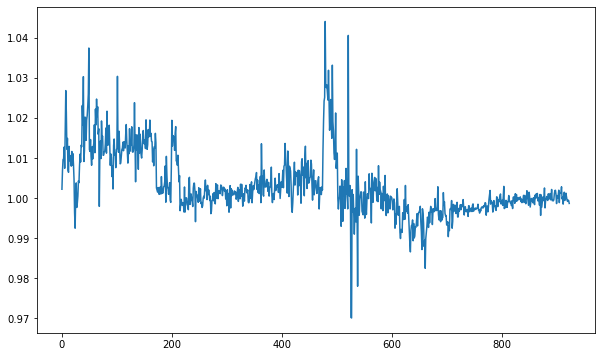

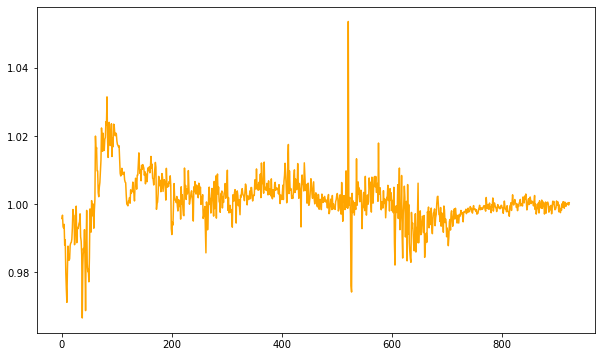

In [7]:
# Time Series Plot
plt.rcParams['figure.figsize'] = (10,6)
dfp['USDC Price'] = dfp['USDC Price'].astype('float64')
plt.plot(dfp['USDC Price'])
plt.show()

plt.rcParams['figure.figsize'] = (10,6)
dfp2['USDT Price'] = dfp2['USDT Price'].astype('float64')
plt.plot(dfp2['USDT Price'], color = 'orange')
plt.show()

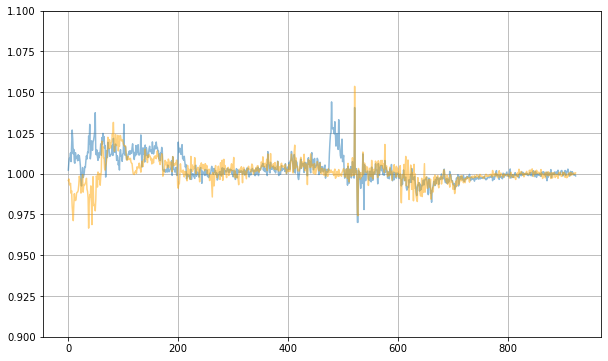

In [8]:
# Time Series Plot
plt.rcParams['figure.figsize'] = (10,6)
dfp['USDC Price'] = dfp['USDC Price'].astype('float64')
plt.plot(dfp['USDC Price'], alpha = 0.5)

plt.rcParams['figure.figsize'] = (10,6)
dfp2['USDT Price'] = dfp2['USDT Price'].astype('float64')
plt.plot(dfp2['USDT Price'], color = 'orange', alpha = 0.5)
plt.ylim([0.9, 1.1])
plt.grid()
plt.show()

In [9]:
#split train and test
from sklearn.model_selection import train_test_split

usdc_train=dfp[dfp['Date']<='2021-01-07']
usdc_test =dfp[dfp['Date']>'2021-01-07']
usdt_train=dfp2[dfp2['Date']<='2021-01-12'] 
usdt_test =dfp2[dfp2['Date']>'2021-01-12']
print(usdc_train)
print(usdc_test)
print(usdt_train)
print(usdt_test)

           Date  USDC Price
0    2018-10-08    1.002210
1    2018-10-09    1.006860
2    2018-10-10    1.009620
3    2018-10-11    1.009780
4    2018-10-12    1.012720
..          ...         ...
818  2021-01-03    0.998120
819  2021-01-04    0.999354
820  2021-01-05    0.997401
821  2021-01-06    1.000171
822  2021-01-07    1.000320

[823 rows x 2 columns]
           Date  USDC Price
823  2021-01-08    0.999768
824  2021-01-09    0.998707
825  2021-01-10    1.001093
826  2021-01-11    0.999213
827  2021-01-12    1.000892
..          ...         ...
919  2021-04-14    0.999534
920  2021-04-15    0.999178
921  2021-04-16    0.999518
922  2021-04-17    0.999383
923  2021-04-18    0.998674

[101 rows x 2 columns]
           Date  USDT Price
0    2018-10-08    0.995814
1    2018-10-09    0.996779
2    2018-10-10    0.993502
3    2018-10-11    0.993026
4    2018-10-12    0.994102
..          ...         ...
823  2021-01-08    1.000620
824  2021-01-09    1.001376
825  2021-01-10    1.000500


In [10]:
usdc_train['Date'] = pd.to_datetime(usdc_train['Date'])
usdc_train = usdc_train[['Date','USDC Price']].set_index('Date')

usdc_test['Date'] = pd.to_datetime(usdc_test['Date'])
usdc_test = usdc_test[['Date','USDC Price']].set_index('Date')

usdt_train['Date'] = pd.to_datetime(usdt_train['Date'])
usdt_train = usdt_train[['Date','USDT Price']].set_index('Date')

usdt_test['Date'] = pd.to_datetime(usdt_test['Date'])
usdt_test = usdt_test[['Date','USDT Price']].set_index('Date')

print(usdc_train)
print(usdc_test)
print(usdt_train)
print(usdt_test)

            USDC Price
Date                  
2018-10-08    1.002210
2018-10-09    1.006860
2018-10-10    1.009620
2018-10-11    1.009780
2018-10-12    1.012720
...                ...
2021-01-03    0.998120
2021-01-04    0.999354
2021-01-05    0.997401
2021-01-06    1.000171
2021-01-07    1.000320

[823 rows x 1 columns]
            USDC Price
Date                  
2021-01-08    0.999768
2021-01-09    0.998707
2021-01-10    1.001093
2021-01-11    0.999213
2021-01-12    1.000892
...                ...
2021-04-14    0.999534
2021-04-15    0.999178
2021-04-16    0.999518
2021-04-17    0.999383
2021-04-18    0.998674

[101 rows x 1 columns]
            USDT Price
Date                  
2018-10-08    0.995814
2018-10-09    0.996779
2018-10-10    0.993502
2018-10-11    0.993026
2018-10-12    0.994102
...                ...
2021-01-08    1.000620
2021-01-09    1.001376
2021-01-10    1.000500
2021-01-11    1.000146
2021-01-12    0.999025

[828 rows x 1 columns]
            USDT Price
Date    

In [11]:
print(usdc_train.shape, usdc_test.shape, usdt_train.shape, usdt_test.shape)

(823, 1) (101, 1) (828, 1) (96, 1)


In [12]:
dfp['Date'] = pd.to_datetime(dfp['Date'])
dfp = dfp[['Date','USDC Price']].set_index('Date')

dfp2['Date'] = pd.to_datetime(dfp2['Date'])
dfp2 = dfp2[['Date','USDT Price']].set_index('Date')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


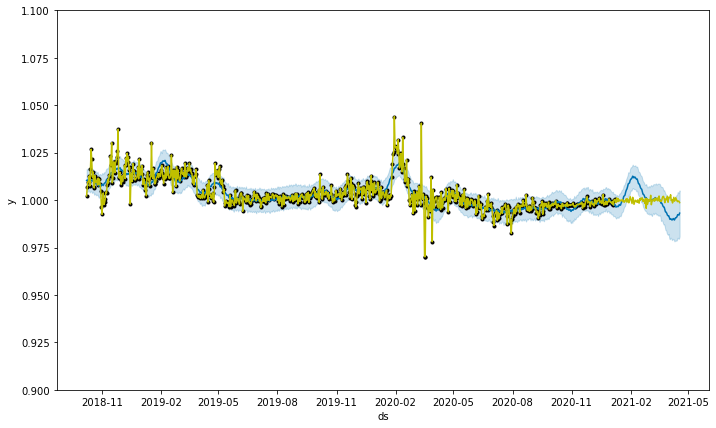

In [13]:
from fbprophet import Prophet

# Prophet requires the time series to be a 2 column data series with the Date as 'ds' and the values as 'y'.

usdc_train_pro = usdc_train.reset_index()
usdc_test_pro = usdc_test.reset_index()
usdc_train_pro = usdc_train_pro.rename({'Date':'ds', 'USDC Price':'y'}, axis='columns')
usdc_test_pro = usdc_test_pro.rename({'Date':'ds', 'USDC Price':'y'}, axis='columns')
dfp_pro = dfp.reset_index()
dfp_pro=dfp_pro.rename({'Date':'ds', 'USDC Price':'y'}, axis='columns')
usdc_prophet = Prophet()


# Fit the model on the time series.
m_prophet = usdc_prophet.fit(usdc_train_pro)


# Create a DataFrame of future dates to create forecasts for. 
future_prophet = m_prophet.make_future_dataframe(periods=101)

# Create forecast
prophet_forecast = m_prophet.predict(future_prophet)

fig1 = m_prophet.plot(prophet_forecast)

plt.plot(dfp['USDC Price'], c = 'y')
plt.ylim([0.9, 1.1])
plt.grid()
plt.show()

In [14]:
def get_mape(actuals, forecasts):
    #np.set_printoptions(precision=5)
    MAPE = np.mean(np.abs(actuals - forecasts)/actuals)
    return MAPE
prophet_forecast = prophet_forecast.reset_index().rename(columns = {'ds':'Date', 'yhat':'USDC Price'})
prophet_forecast = prophet_forecast.set_index('Date')

prophet_mape = get_mape(usdc_test['USDC Price'], prophet_forecast['USDC Price'])


print('Original Prophet MAPE: ', prophet_mape)

Original Prophet MAPE:  0.00552052465414483


# dfp2

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


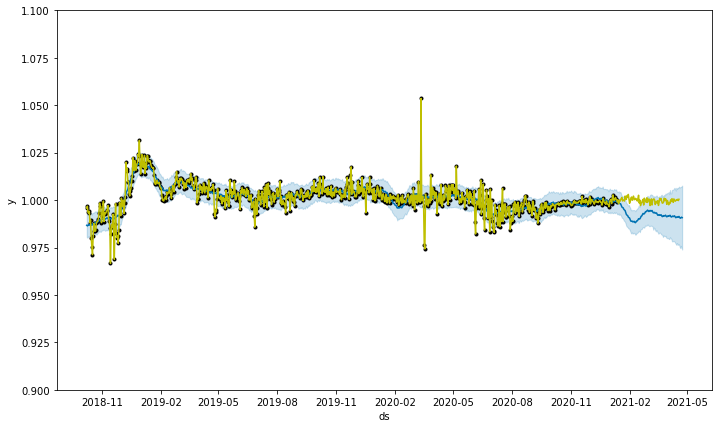

In [15]:
usdt_train_pro = usdt_train.reset_index()
usdt_test_pro = usdt_test.reset_index()
usdt_train_pro = usdt_train_pro.rename({'Date':'ds', 'USDT Price':'y'}, axis='columns')
usdt_test_pro = usdt_test_pro.rename({'Date':'ds', 'USDT Price':'y'}, axis='columns')
dfp2_pro = dfp2.reset_index()
dfp2_pro=dfp2_pro.rename({'Date':'ds', 'USDT rice':'y'}, axis='columns')
usdt_prophet = Prophet()


# Fit the model on the time series.
m_prophet = usdt_prophet.fit(usdt_train_pro)


# Create a DataFrame of future dates to create forecasts for. 
future_prophet = m_prophet.make_future_dataframe(periods=101)

# Create forecast
prophet_forecast = m_prophet.predict(future_prophet)

fig1 = m_prophet.plot(prophet_forecast)
plt.plot(dfp2['USDT Price'], c = 'y')
plt.ylim([0.9, 1.1])
plt.grid()
plt.show()

In [16]:
prophet_forecast = prophet_forecast.reset_index().rename(columns = {'ds':'Date', 'yhat':'USDT Price'})
prophet_forecast = prophet_forecast.set_index('Date')

prophet_mape = get_mape(usdt_test['USDT Price'], prophet_forecast['USDT Price'])


print('Original Prophet MAPE: ', prophet_mape)

Original Prophet MAPE:  0.007507894473913716
